In [1]:
# This first set of packages include Pandas, for data manipulation, numpy for mathematical computation and matplotlib & seaborn, for visualisation.
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')

Data Manipulation, Mathematical Computation and Visualisation packages imported!


In [2]:
# Statistical packages used for transformations
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr
print('Statistical packages imported!')

Statistical packages imported!


In [3]:
# Metrics used for measuring the accuracy and performance of the models
#from sklearn import metrics
#from sklearn.metrics import mean_squared_error
print('Metrics packages imported!')

# Algorithms used for modeling
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
print('Algorithm packages imported!')

Metrics packages imported!
Algorithm packages imported!


In [4]:
# Pipeline and scaling preprocessing will be used for models that are sensitive
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and preprocessing packages imported!')

Pipeline and preprocessing packages imported!


In [5]:
# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Model selection packages imported!')

Model selection packages imported!


In [6]:
# Set visualisation colours
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)
print('My colours are ready! :)')

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

My colours are ready! :)
Deprecation warning will be ignored!


Загрузим данные:

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' column as it's redundant for modeling
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print(train.shape)
print(test.shape)
train.head()

(1460, 80)
(1459, 79)


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

Подготовка данных:

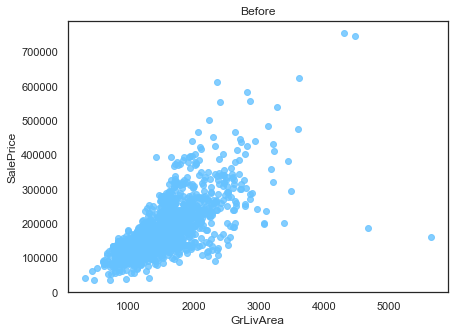

In [8]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("Before")

Удалим 4 выброса:

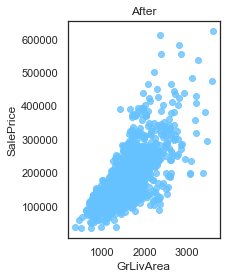

In [9]:
# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['GrLivArea']>4000)].index)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("After")

Работаем с отсутствующими значениями:

In [10]:
# First of all, save the length of the training and test data for use later
ntrain = train.shape[0]
ntest = test.shape[0]

# Also save the target value, as we will remove this
y_train = train.SalePrice.values

# concatenate training and test data into all_data
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2915, 79)


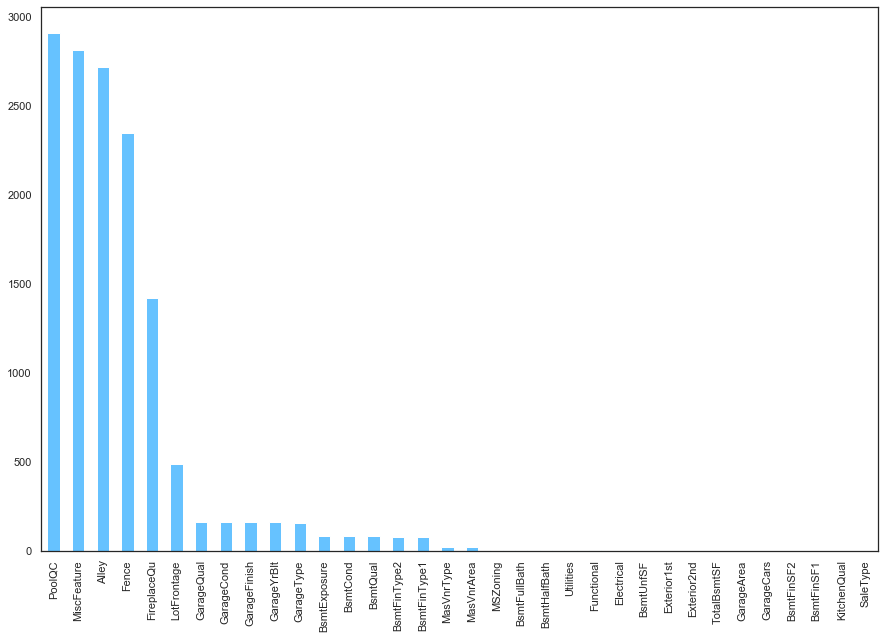

In [11]:
# aggregate all null values 
all_data_na = all_data.isnull().sum()

# get rid of all the values with 0 missing values
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(15, 10))
all_data_na.plot(kind='bar');

In [12]:
# Using data description, fill these missing values with "None"
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MSSubClass", "MasVnrType"):
    all_data[col] = all_data[col].fillna("None")
print("'None' - treated...")

# The area of the lot out front is likely to be similar to the houses in the local neighbourhood
# Therefore, let's use the median value of the houses in the neighbourhood to fill this feature
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
print("'LotFrontage' - treated...")

# Using data description, fill these missing values with 0 
for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)
print("'0' - treated...")


# Fill these features with their mode, the most commonly occuring value. This is okay since there are a low number of missing values for these features
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
print("'mode' - treated...")

all_data_na = all_data.isnull().sum()
print("Features with missing values: ", all_data_na.drop(all_data_na[all_data_na == 0].index))

'None' - treated...
'LotFrontage' - treated...
'0' - treated...
'mode' - treated...
Features with missing values:  Utilities    2
dtype: int64


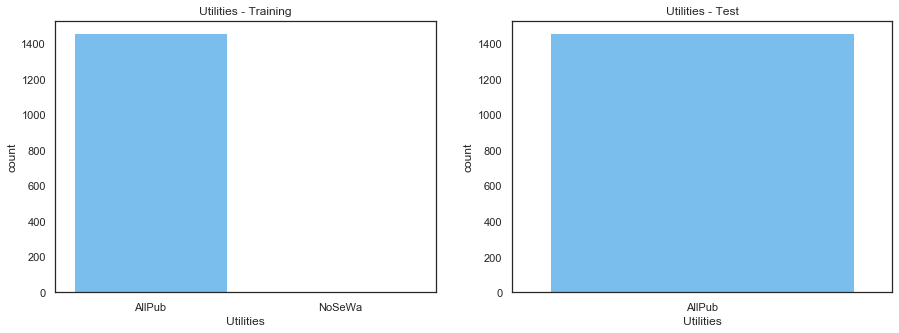

In [13]:
plt.subplots(figsize =(15, 5))

plt.subplot(1, 2, 1)
g = sns.countplot(x = "Utilities", data = train).set_title("Utilities - Training")

plt.subplot(1, 2, 2)
g = sns.countplot(x = "Utilities", data = test).set_title("Utilities - Test")

Можно не учитывать этот признак.

In [14]:
# From inspection, we can remove Utilities
all_data = all_data.drop(['Utilities'], axis=1)

all_data_na = all_data.isnull().sum()
print("Features with missing values: ", len(all_data_na.drop(all_data_na[all_data_na == 0].index)))

Features with missing values:  0


EDA

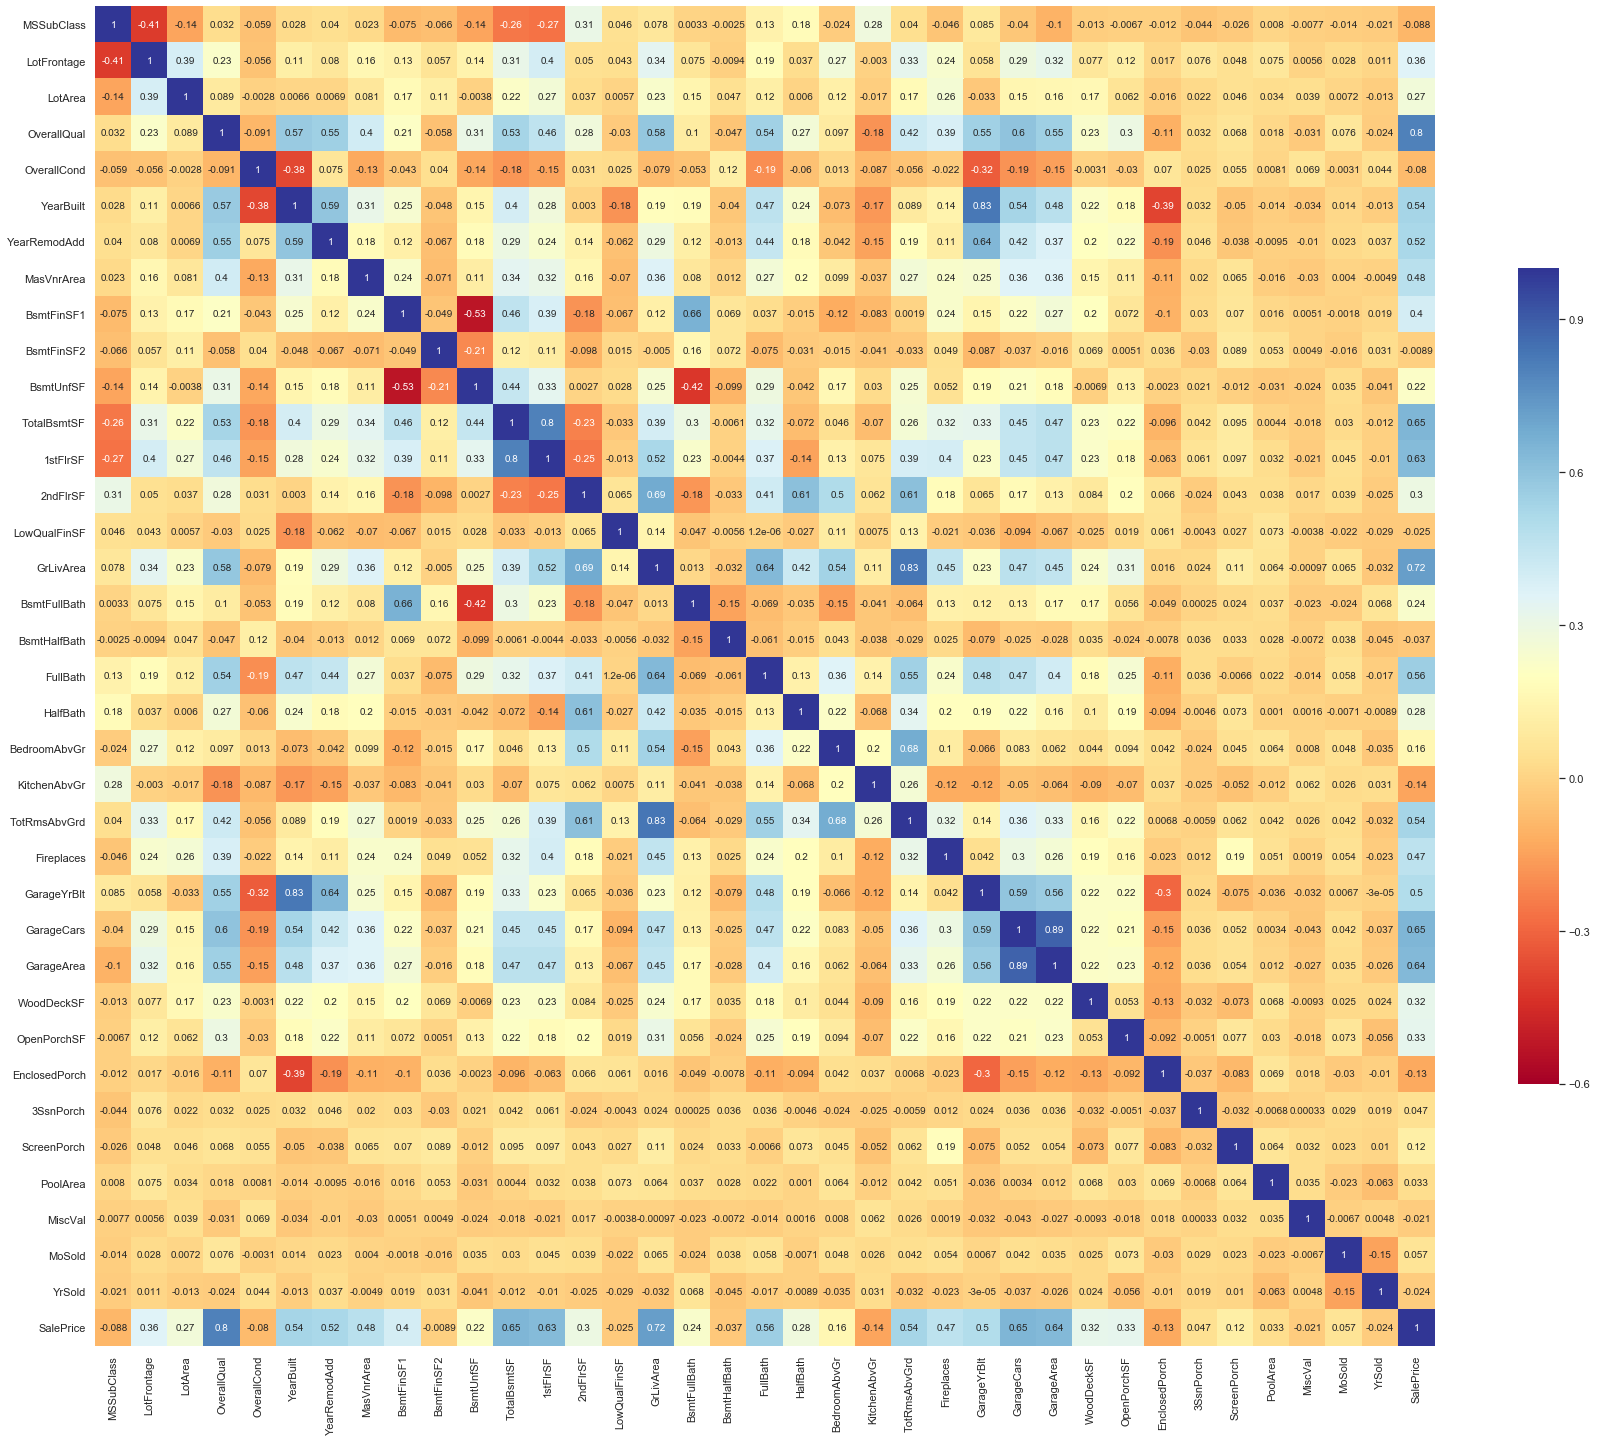

In [15]:
corr = train.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);

Feature engineering

In [16]:
# Quadratic
all_data["OverallQual-2"] = all_data["OverallQual"] ** 2
all_data["GrLivArea-2"] = all_data["GrLivArea"] ** 2
all_data["GarageCars-2"] = all_data["GarageCars"] ** 2
all_data["GarageArea-2"] = all_data["GarageArea"] ** 2
all_data["TotalBsmtSF-2"] = all_data["TotalBsmtSF"] ** 2
all_data["1stFlrSF-2"] = all_data["1stFlrSF"] ** 2
all_data["FullBath-2"] = all_data["FullBath"] ** 2
all_data["TotRmsAbvGrd-2"] = all_data["TotRmsAbvGrd"] ** 2
all_data["Fireplaces-2"] = all_data["Fireplaces"] ** 2
all_data["MasVnrArea-2"] = all_data["MasVnrArea"] ** 2
all_data["BsmtFinSF1-2"] = all_data["BsmtFinSF1"] ** 2
all_data["LotFrontage-2"] = all_data["LotFrontage"] ** 2
all_data["WoodDeckSF-2"] = all_data["WoodDeckSF"] ** 2
all_data["OpenPorchSF-2"] = all_data["OpenPorchSF"] ** 2
all_data["2ndFlrSF-2"] = all_data["2ndFlrSF"] ** 2
print("Quadratics done!...")

# Cubic
all_data["OverallQual-3"] = all_data["OverallQual"] ** 3
all_data["GrLivArea-3"] = all_data["GrLivArea"] ** 3
all_data["GarageCars-3"] = all_data["GarageCars"] ** 3
all_data["GarageArea-3"] = all_data["GarageArea"] ** 3
all_data["TotalBsmtSF-3"] = all_data["TotalBsmtSF"] ** 3
all_data["1stFlrSF-3"] = all_data["1stFlrSF"] ** 3
all_data["FullBath-3"] = all_data["FullBath"] ** 3
all_data["TotRmsAbvGrd-3"] = all_data["TotRmsAbvGrd"] ** 3
all_data["Fireplaces-3"] = all_data["Fireplaces"] ** 3
all_data["MasVnrArea-3"] = all_data["MasVnrArea"] ** 3
all_data["BsmtFinSF1-3"] = all_data["BsmtFinSF1"] ** 3
all_data["LotFrontage-3"] = all_data["LotFrontage"] ** 3
all_data["WoodDeckSF-3"] = all_data["WoodDeckSF"] ** 3
all_data["OpenPorchSF-3"] = all_data["OpenPorchSF"] ** 3
all_data["2ndFlrSF-3"] = all_data["2ndFlrSF"] ** 3
print("Cubics done!...")

# Square Root
all_data["OverallQual-Sq"] = np.sqrt(all_data["OverallQual"])
all_data["GrLivArea-Sq"] = np.sqrt(all_data["GrLivArea"])
all_data["GarageCars-Sq"] = np.sqrt(all_data["GarageCars"])
all_data["GarageArea-Sq"] = np.sqrt(all_data["GarageArea"])
all_data["TotalBsmtSF-Sq"] = np.sqrt(all_data["TotalBsmtSF"])
all_data["1stFlrSF-Sq"] = np.sqrt(all_data["1stFlrSF"])
all_data["FullBath-Sq"] = np.sqrt(all_data["FullBath"])
all_data["TotRmsAbvGrd-Sq"] = np.sqrt(all_data["TotRmsAbvGrd"])
all_data["Fireplaces-Sq"] = np.sqrt(all_data["Fireplaces"])
all_data["MasVnrArea-Sq"] = np.sqrt(all_data["MasVnrArea"])
all_data["BsmtFinSF1-Sq"] = np.sqrt(all_data["BsmtFinSF1"])
all_data["LotFrontage-Sq"] = np.sqrt(all_data["LotFrontage"])
all_data["WoodDeckSF-Sq"] = np.sqrt(all_data["WoodDeckSF"])
all_data["OpenPorchSF-Sq"] = np.sqrt(all_data["OpenPorchSF"])
all_data["2ndFlrSF-Sq"] = np.sqrt(all_data["2ndFlrSF"])
print("Roots done!...")

Quadratics done!...
Cubics done!...
Roots done!...


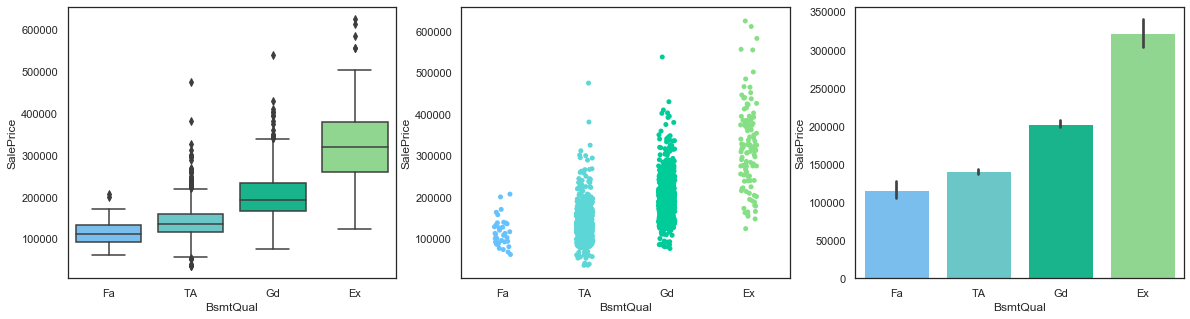

In [17]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtQual", y="SalePrice", data=train, order=['Fa', 'TA', 'Gd', 'Ex']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtQual", y="SalePrice", data=train, size = 5, jitter = True, order=['Fa', 'TA', 'Gd', 'Ex']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtQual", y="SalePrice", data=train, order=['Fa', 'TA', 'Gd', 'Ex']);

На SalePrice явно влияет признак. Заменим вручную.

In [18]:
all_data['BsmtQual'] = all_data['BsmtQual'].map({"None":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['BsmtQual'].unique()

array([3, 2, 4, 0, 1], dtype=int64)

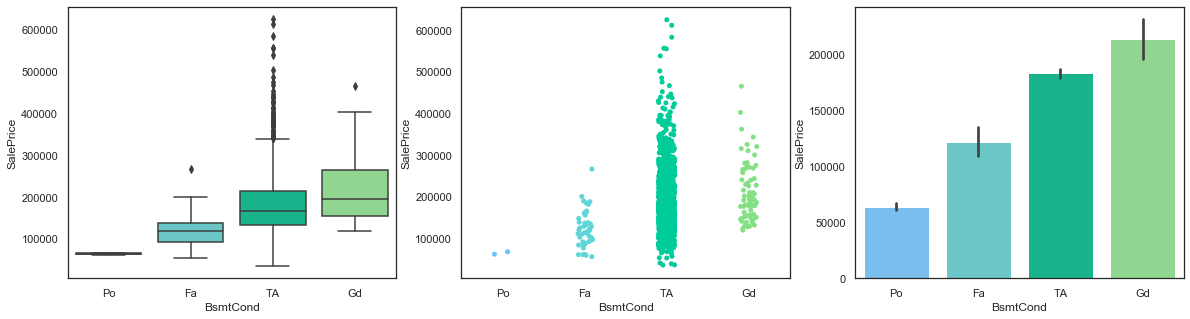

In [19]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtCond", y="SalePrice", data=train, order=['Po', 'Fa', 'TA', 'Gd']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtCond", y="SalePrice", data=train, size = 5, jitter = True, order=['Po', 'Fa', 'TA', 'Gd']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtCond", y="SalePrice", data=train, order=['Po', 'Fa', 'TA', 'Gd']);

По мере улучшения состояния подвала, SalePrice также увеличивается.
Однако мы видим некоторые очень высокие значения SalePrice для домов с "типичными" условиями подвалов. Это, возможно, говорит о том, что, хотя эти две характеристики положительно коррелируют, BsmtCond, возможно, не оказывает существенного влияния на SalePrice.
Мы также видим, что наибольшее количество домов попадает в категорию "TA".
Так как эта характеристика упорядочена, я заменю значения вручную.

In [20]:
all_data['BsmtCond'] = all_data['BsmtCond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['BsmtCond'].unique()

array([3, 4, 0, 2, 1], dtype=int64)

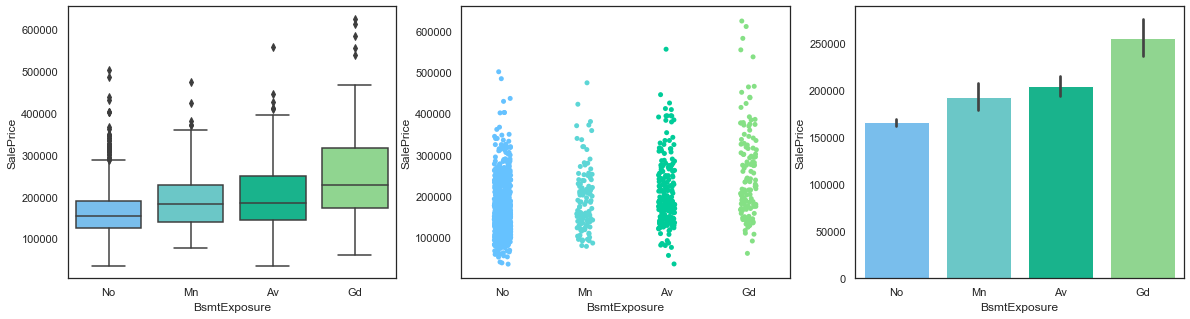

In [21]:

plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtExposure", y="SalePrice", data=train, order=['No', 'Mn', 'Av', 'Gd']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtExposure", y="SalePrice", data=train, size = 5, jitter = True, order=['No', 'Mn', 'Av', 'Gd']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtExposure", y="SalePrice", data=train, order=['No', 'Mn', 'Av', 'Gd']);

С увеличением количества экспозиции увеличивается и типичная SalePrice. Интересно, что средняя разница SalePrice между категориями здесь довольно низкая, что говорит мне о том, что некоторые дома продаются по очень высоким ценам, даже без экспозиции.
Из этого анализа я бы сказал, что это положительно коррелирует с SalePrice, но не сильно влияет.
Так как эта функция упорядочена, я заменю значения вручную.

In [22]:
all_data['BsmtExposure'] = all_data['BsmtExposure'].map({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})
all_data['BsmtExposure'].unique()

array([1, 4, 2, 3, 0], dtype=int64)

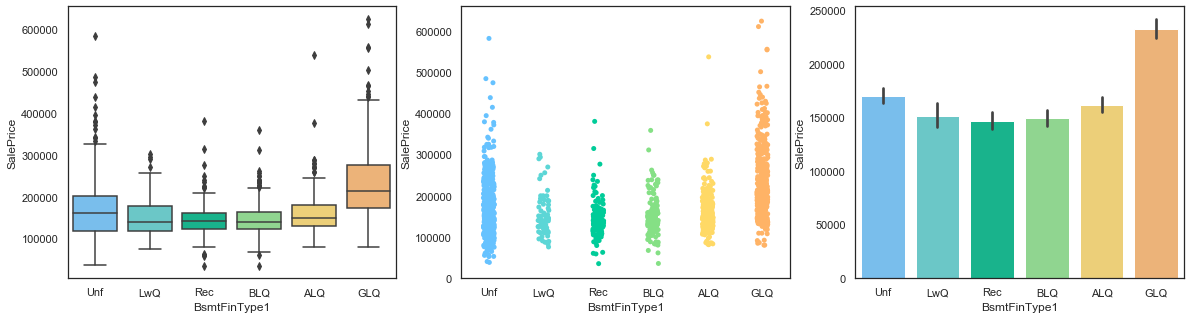

In [23]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtFinType1", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtFinType1", y="SalePrice", data=train, size = 5, jitter = True, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtFinType1", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

Это очень интересно, кажется, что дома с недостроенным подвалом в среднем продаются за большие деньги, чем дома со средним рейтингом...
Однако дома с хорошей отделкой в подвале по-прежнему требуют больше денег, чем недостроенные.
Это порядковая особенность, однако, этот порядок не обязательно вызывает более высокую SalePrice. Создавая порядковую переменную, предполагалось, что по мере увеличения порядка объекта недвижимости будет увеличиваться и целевая переменная. Мы видим, что это не так. Поэтому из этой функции я буду создавать фиктивные переменные.

In [24]:
all_data = pd.get_dummies(all_data, columns = ["BsmtFinType1"], prefix="BsmtFinType1")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFinSF1  BsmtFinSF2  ... WoodDeckSF-Sq  OpenPorchSF-Sq  \
0             1       706.0         0.0  ...      0.000000        7.810250   
1             4       978.0         0.0  ...     17.262677        0.000000   
2             2       486.0         0.0  ...      0.000000        6.480741   

   2ndFlrSF-Sq  BsmtFinType1_ALQ  BsmtFinType1_BLQ BsmtFinType1_GLQ  \
0    29.223278                 0                 0                1   
1     0.000000                 1                 0                0   
2    29.427878                 0                 0                1   

  BsmtFinType1_LwQ BsmtFinType1_None BsmtFinType1_Rec  BsmtFinType1_Unf  
0                0                 0                0                 0  
1                0                 0                0                 0  
2                0                 0                0                 0  

[3 rows x 129 columns]

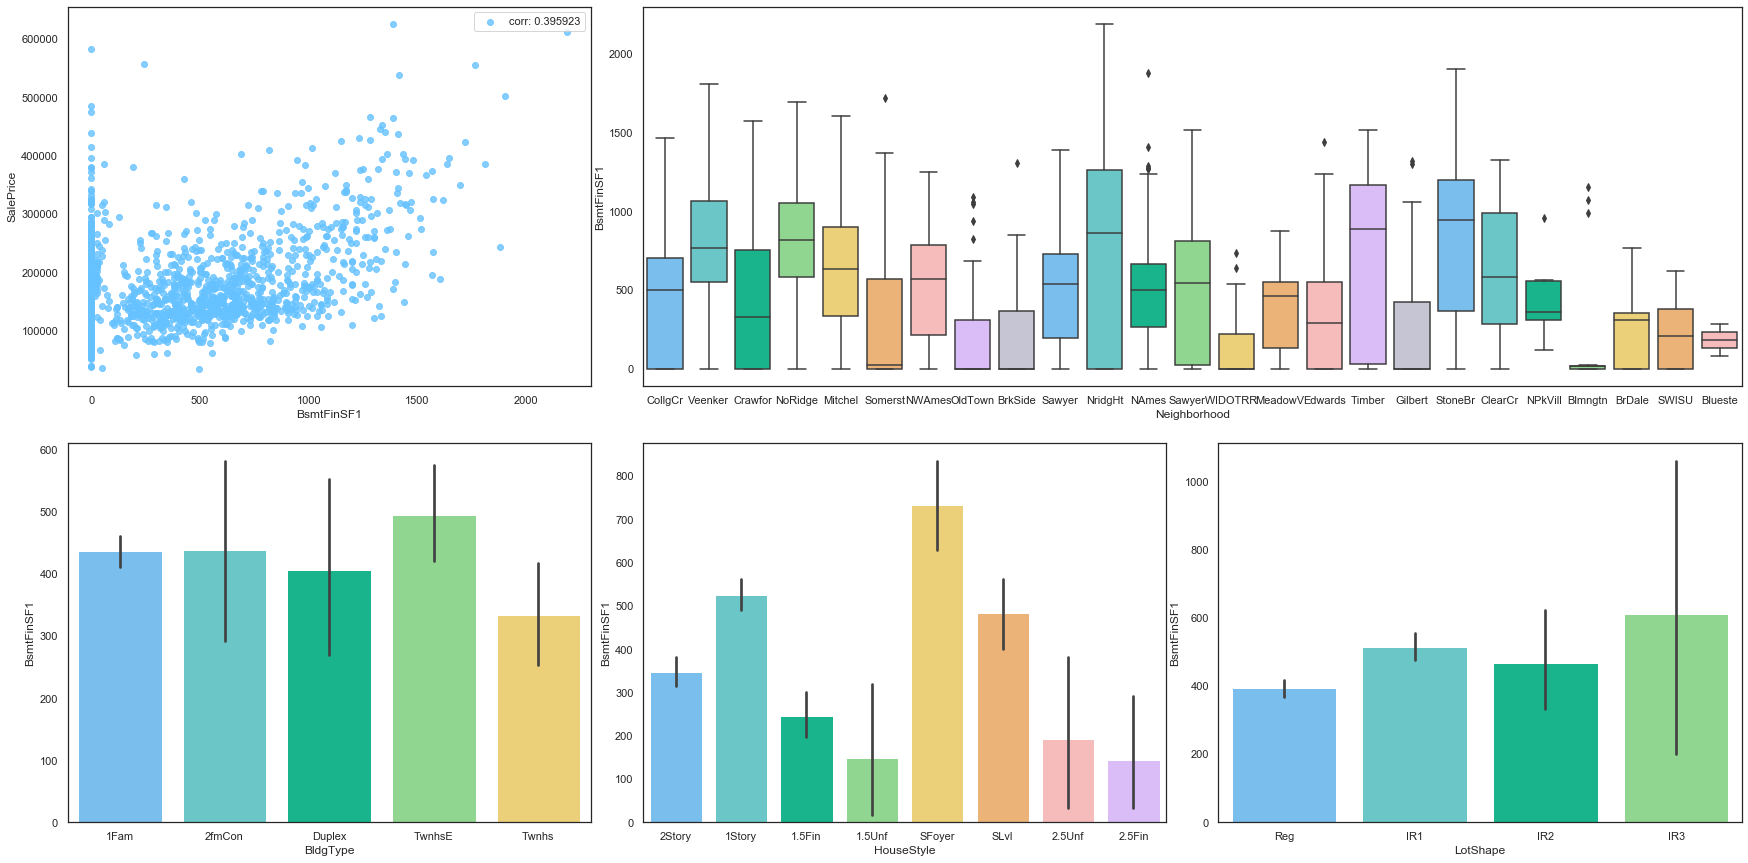

In [25]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtFinSF1'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtFinSF1'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtFinSF1", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtFinSF1", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtFinSF1", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtFinSF1", data=train, palette = mycols);

Эта особенность имеет положительную корреляцию с SalePrice, а разброс точек данных достаточно велик. 
Понятно также, что местный район (Neighborhood) и стиль строительства (BldgType, HouseStyle и LotShape) оказывают различное влияние на эту особенность.
Так как это непрерывная числовая функция, я разобью ее на несколько категорий и создам фиктивные функции.

In [26]:
all_data['BsmtFinSF1_Band'] = pd.cut(all_data['BsmtFinSF1'], 4)
all_data['BsmtFinSF1_Band'].unique()

[(-4.01, 1002.5], (1002.5, 2005.0], (2005.0, 3007.5], (3007.5, 4010.0]]
Categories (4, interval[float64]): [(-4.01, 1002.5] < (1002.5, 2005.0] < (2005.0, 3007.5] < (3007.5, 4010.0]]

In [27]:
all_data.loc[all_data['BsmtFinSF1']<=1002.5, 'BsmtFinSF1'] = 1
all_data.loc[(all_data['BsmtFinSF1']>1002.5) & (all_data['BsmtFinSF1']<=2005), 'BsmtFinSF1'] = 2
all_data.loc[(all_data['BsmtFinSF1']>2005) & (all_data['BsmtFinSF1']<=3007.5), 'BsmtFinSF1'] = 3
all_data.loc[all_data['BsmtFinSF1']>3007.5, 'BsmtFinSF1'] = 4
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].astype(int)

all_data.drop('BsmtFinSF1_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["BsmtFinSF1"], prefix="BsmtFinSF1")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFinSF2 BsmtFinType2  ...  BsmtFinType1_BLQ  \
0             1         0.0          Unf  ...                 0   
1             4         0.0          Unf  ...                 0   
2             2         0.0          Unf  ...                 0   

   BsmtFinType1_GLQ  BsmtFinType1_LwQ  BsmtFinType1_None BsmtFinType1_Rec  \
0                 1                 0                  0                0   
1                 0                 0                  0                0   
2                 1                 0                  0                0   

  BsmtFinType1_Unf BsmtFinSF1_1 BsmtFinSF1_2  BsmtFinSF1_3 BsmtFinSF1_4  
0                0            1            0             0            0  
1                0            1            0             0            0  
2                0            1            0             0            0  

[3 rows x 132 columns]

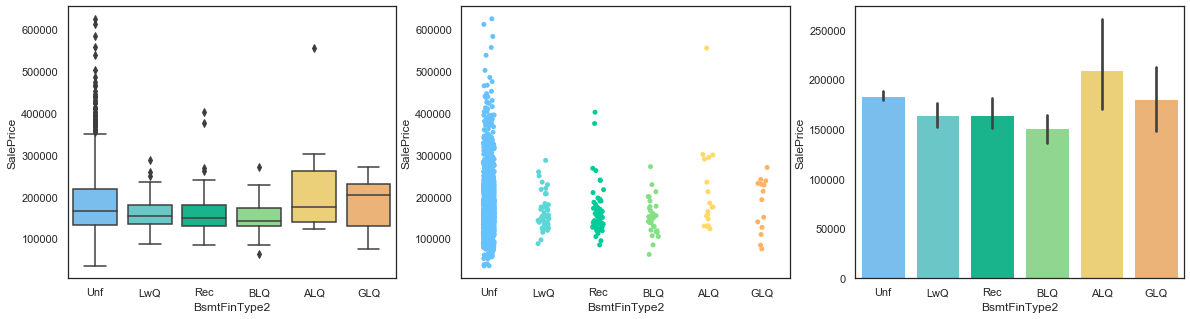

In [28]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtFinType2", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtFinType2", y="SalePrice", data=train, size = 5, jitter = True, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtFinType2", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

Кажется, что есть много домов с незавершенными вторыми подвалами.
Похоже также, что для каждой из других категорий есть только несколько значений, причем самая высокая средняя цена SalePrice относится ко второй лучшей категории.
Несмотря на то, что это должно быть порядковым показателем, мы видим, что SalePrice не обязательно увеличивается с заказом. Следовательно, здесь я проверю фиктивные переменные.

In [29]:
all_data = pd.get_dummies(all_data, columns = ["BsmtFinType2"], prefix="BsmtFinType2")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFinSF2  BsmtFullBath  ...  BsmtFinSF1_2  BsmtFinSF1_3  \
0             1         0.0           1.0  ...             0             0   
1             4         0.0           0.0  ...             0             0   
2             2         0.0           1.0  ...             0             0   

   BsmtFinSF1_4 BsmtFinType2_ALQ BsmtFinType2_BLQ BsmtFinType2_GLQ  \
0             0                0                0                0   
1             0                0                0                0   
2             0                0                0                0   

  BsmtFinType2_LwQ  BsmtFinType2_None BsmtFinType2_Rec BsmtFinType2_Unf  
0                0                  0                0                1  
1                0                  0                0                1  
2                0                  0                0                1  

[3 rows x 138 columns]

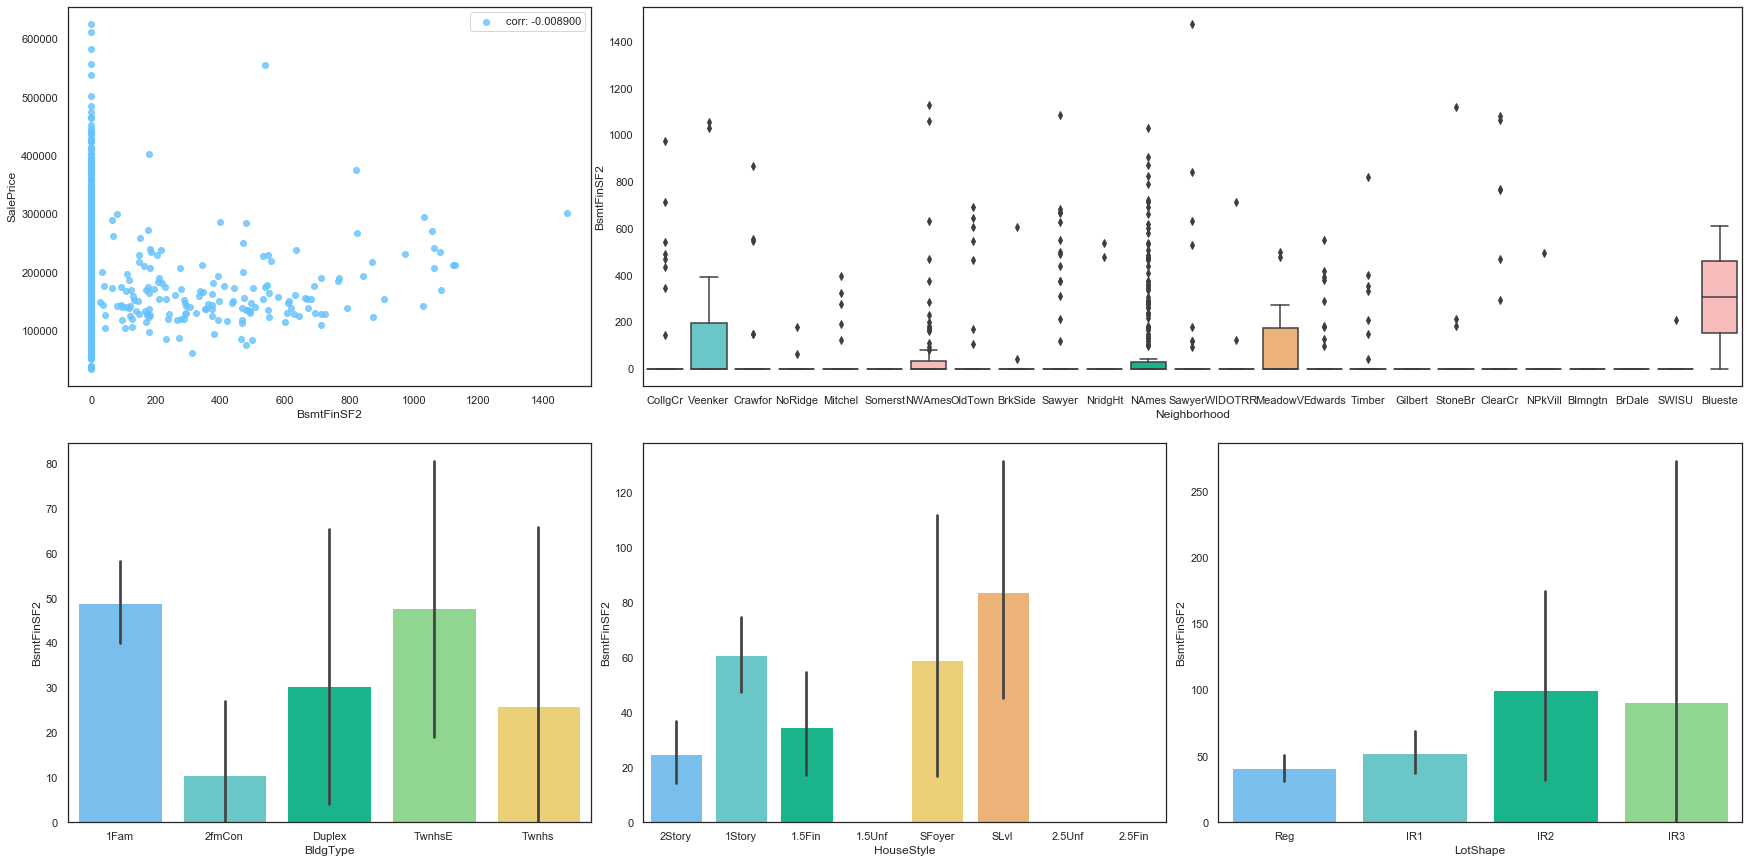

In [30]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtFinSF2'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtFinSF2'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtFinSF2", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtFinSF2", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtFinSF2", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtFinSF2", data=train, palette = mycols);

Существует большое количество точек данных с этим признаком = 0. Кроме того, отсутствует значительная корреляция с SalePrice и большой разброс значений.
Поэтому я заменю эту особенность 1.

In [31]:
all_data['BsmtFinSf2_Flag'] = all_data['BsmtFinSF2'].map(lambda x:0 if x==0 else 1)
all_data.drop('BsmtFinSF2', axis=1, inplace=True)

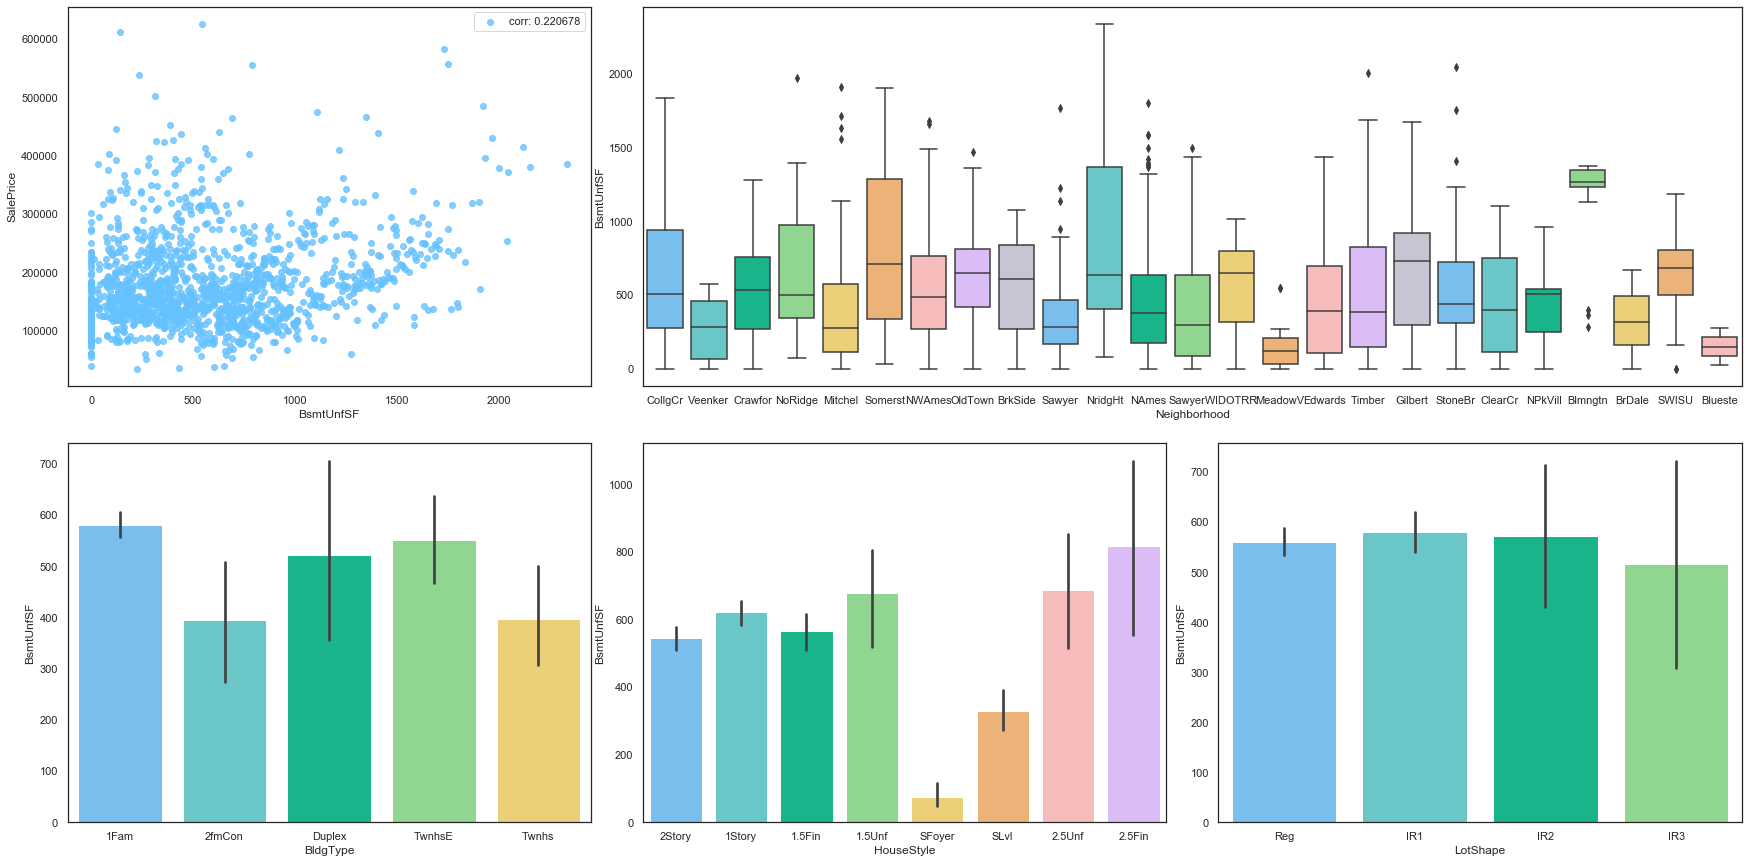

In [32]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtUnfSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtUnfSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtUnfSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtUnfSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtUnfSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtUnfSF", data=train, palette = mycols);

Эта особенность имеет значительную положительную корреляцию с SalePrice, с небольшой долей данных, имеющих значение 0. Это говорит мне о том, что большинство домов будет иметь некоторое количество квадратных футов незавершенного строительства в подвале, и это на самом деле положительно влияет на SalePrice. 
Количество незавершенных квадратных футов также сильно варьируется в зависимости от местоположения и стиля. 
В то время как средний незавершенного квадратного фута в подвале довольно последовательны в различных формах лота.
Так как это непрерывная числовая характеристика со значительной корреляцией, я буду делать это в мусорном ведре и создавать фиктивные переменные

In [33]:
all_data['BsmtUnfSF_Band'] = pd.cut(all_data['BsmtUnfSF'], 3)
all_data['BsmtUnfSF_Band'].unique()

[(-2.336, 778.667], (778.667, 1557.333], (1557.333, 2336.0]]
Categories (3, interval[float64]): [(-2.336, 778.667] < (778.667, 1557.333] < (1557.333, 2336.0]]

In [34]:
all_data.loc[all_data['BsmtUnfSF']<=778.667, 'BsmtUnfSF'] = 1
all_data.loc[(all_data['BsmtUnfSF']>778.667) & (all_data['BsmtUnfSF']<=1557.333), 'BsmtUnfSF'] = 2
all_data.loc[all_data['BsmtUnfSF']>1557.333, 'BsmtUnfSF'] = 3
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].astype(int)

all_data.drop('BsmtUnfSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["BsmtUnfSF"], prefix="BsmtUnfSF")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFullBath  BsmtHalfBath  ...  BsmtFinType2_BLQ  \
0             1           1.0           0.0  ...                 0   
1             4           0.0           1.0  ...                 0   
2             2           1.0           0.0  ...                 0   

  BsmtFinType2_GLQ BsmtFinType2_LwQ BsmtFinType2_None BsmtFinType2_Rec  \
0                0                0                 0                0   
1                0                0                 0                0   
2                0                0                 0                0   

   BsmtFinType2_Unf BsmtFinSf2_Flag BsmtUnfSF_1 BsmtUnfSF_2 BsmtUnfSF_3  
0                 1               0           1           0           0  
1                 1               0           1           0           0  
2                 1               0           1           0           0  

[3 rows x 140 columns]

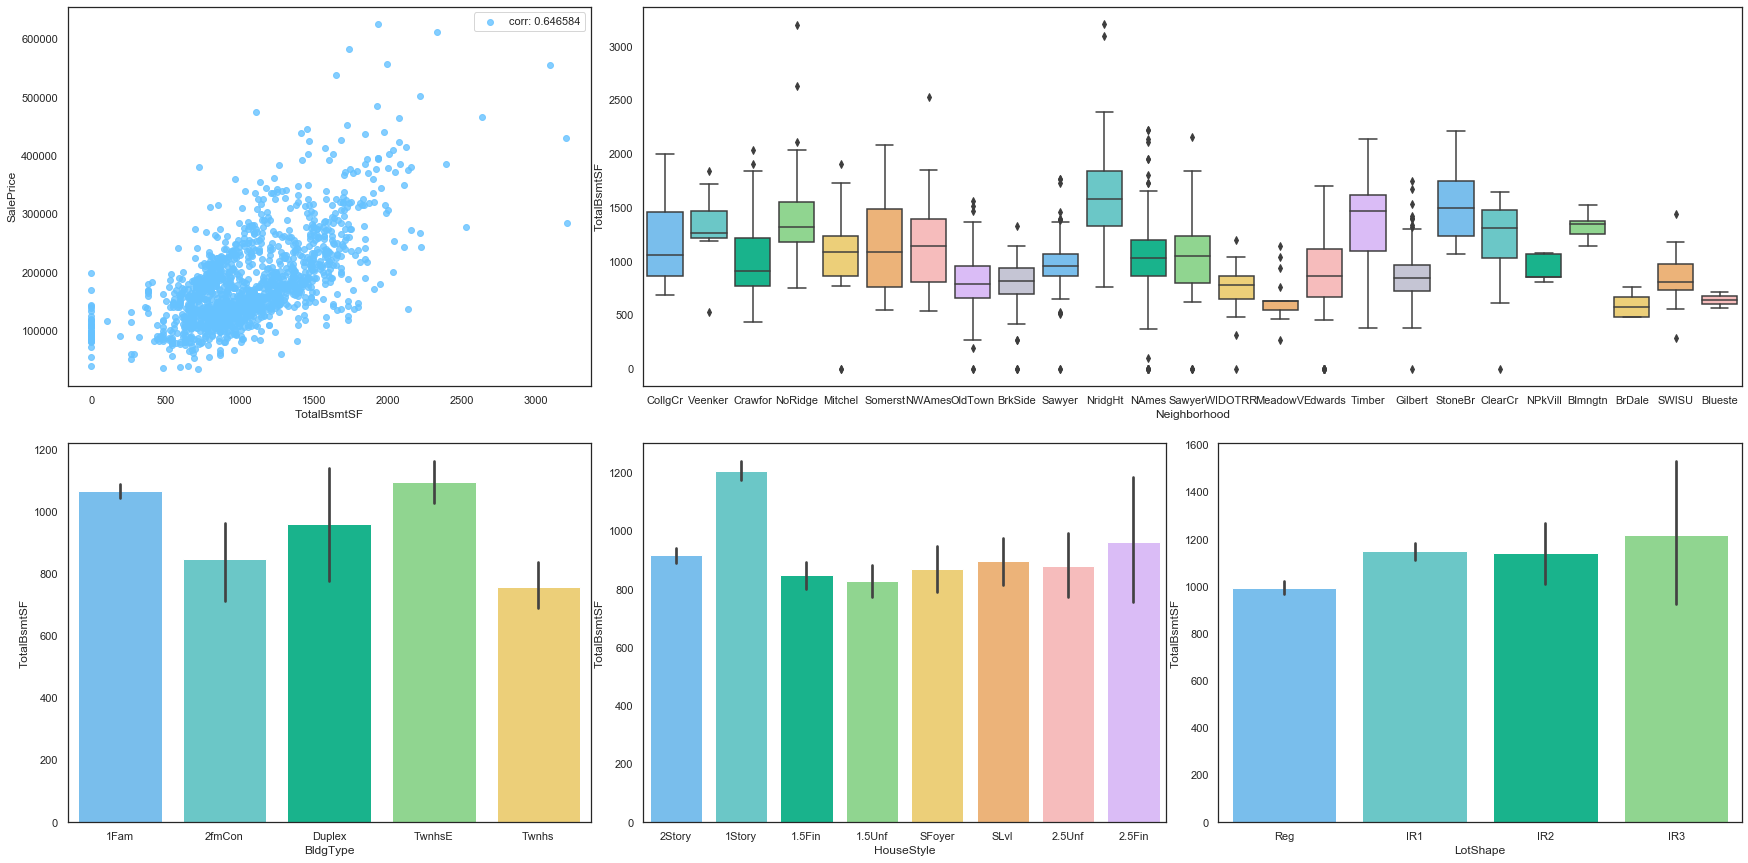

In [35]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['TotalBsmtSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['TotalBsmtSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="TotalBsmtSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="TotalBsmtSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="TotalBsmtSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="TotalBsmtSF", data=train, palette = mycols);

Это будет очень важная особенность в моем анализе из-за такой высокой корреляции с Saleprice.
Мы видим, что она сильно варьируется в зависимости от местоположения, однако средний размер подвала имеет меньшую дисперсию в зависимости от типа, стиля и формы лота.
В связи с тем, что это является непрерывной числовой характеристикой, а также очень важной характеристикой при описании SalePrice, я считаю, что в рамках этой характеристики можно было бы извлечь больше пользы. Поэтому я создам некоторые бининги и фиктивные переменные. 

In [36]:
all_data['TotalBsmtSF_Band'] = pd.cut(all_data['TotalBsmtSF'], 10)
all_data['TotalBsmtSF_Band'].unique()

[(509.5, 1019.0], (1019.0, 1528.5], (1528.5, 2038.0], (-5.095, 509.5], (2038.0, 2547.5], (3057.0, 3566.5], (2547.5, 3057.0], (4585.5, 5095.0]]
Categories (8, interval[float64]): [(-5.095, 509.5] < (509.5, 1019.0] < (1019.0, 1528.5] < (1528.5, 2038.0] < (2038.0, 2547.5] < (2547.5, 3057.0] < (3057.0, 3566.5] < (4585.5, 5095.0]]

In [37]:
all_data.loc[all_data['TotalBsmtSF']<=509.5, 'TotalBsmtSF'] = 1
all_data.loc[(all_data['TotalBsmtSF']>509.5) & (all_data['TotalBsmtSF']<=1019), 'TotalBsmtSF'] = 2
all_data.loc[(all_data['TotalBsmtSF']>1019) & (all_data['TotalBsmtSF']<=1528.5), 'TotalBsmtSF'] = 3
all_data.loc[(all_data['TotalBsmtSF']>1528.5) & (all_data['TotalBsmtSF']<=2038), 'TotalBsmtSF'] = 4
all_data.loc[(all_data['TotalBsmtSF']>2038) & (all_data['TotalBsmtSF']<=2547.5), 'TotalBsmtSF'] = 5
all_data.loc[(all_data['TotalBsmtSF']>2547.5) & (all_data['TotalBsmtSF']<=3057), 'TotalBsmtSF'] = 6
all_data.loc[(all_data['TotalBsmtSF']>3057) & (all_data['TotalBsmtSF']<=3566.5), 'TotalBsmtSF'] = 7
all_data.loc[all_data['TotalBsmtSF']>3566.5, 'TotalBsmtSF'] = 8
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].astype(int)

all_data.drop('TotalBsmtSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["TotalBsmtSF"], prefix="TotalBsmtSF")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFullBath  BsmtHalfBath  ...  BsmtUnfSF_2 BsmtUnfSF_3  \
0             1           1.0           0.0  ...            0           0   
1             4           0.0           1.0  ...            0           0   
2             2           1.0           0.0  ...            0           0   

  TotalBsmtSF_1 TotalBsmtSF_2 TotalBsmtSF_3  TotalBsmtSF_4 TotalBsmtSF_5  \
0             0             1             0              0             0   
1             0             0             1              0             0   
2             0             1             0              0             0   

  TotalBsmtSF_6 TotalBsmtSF_7 TotalBsmtSF_8  
0             0             0             0  
1             0             0             0  
2             0             0             0  

[3 rows x 147 columns]

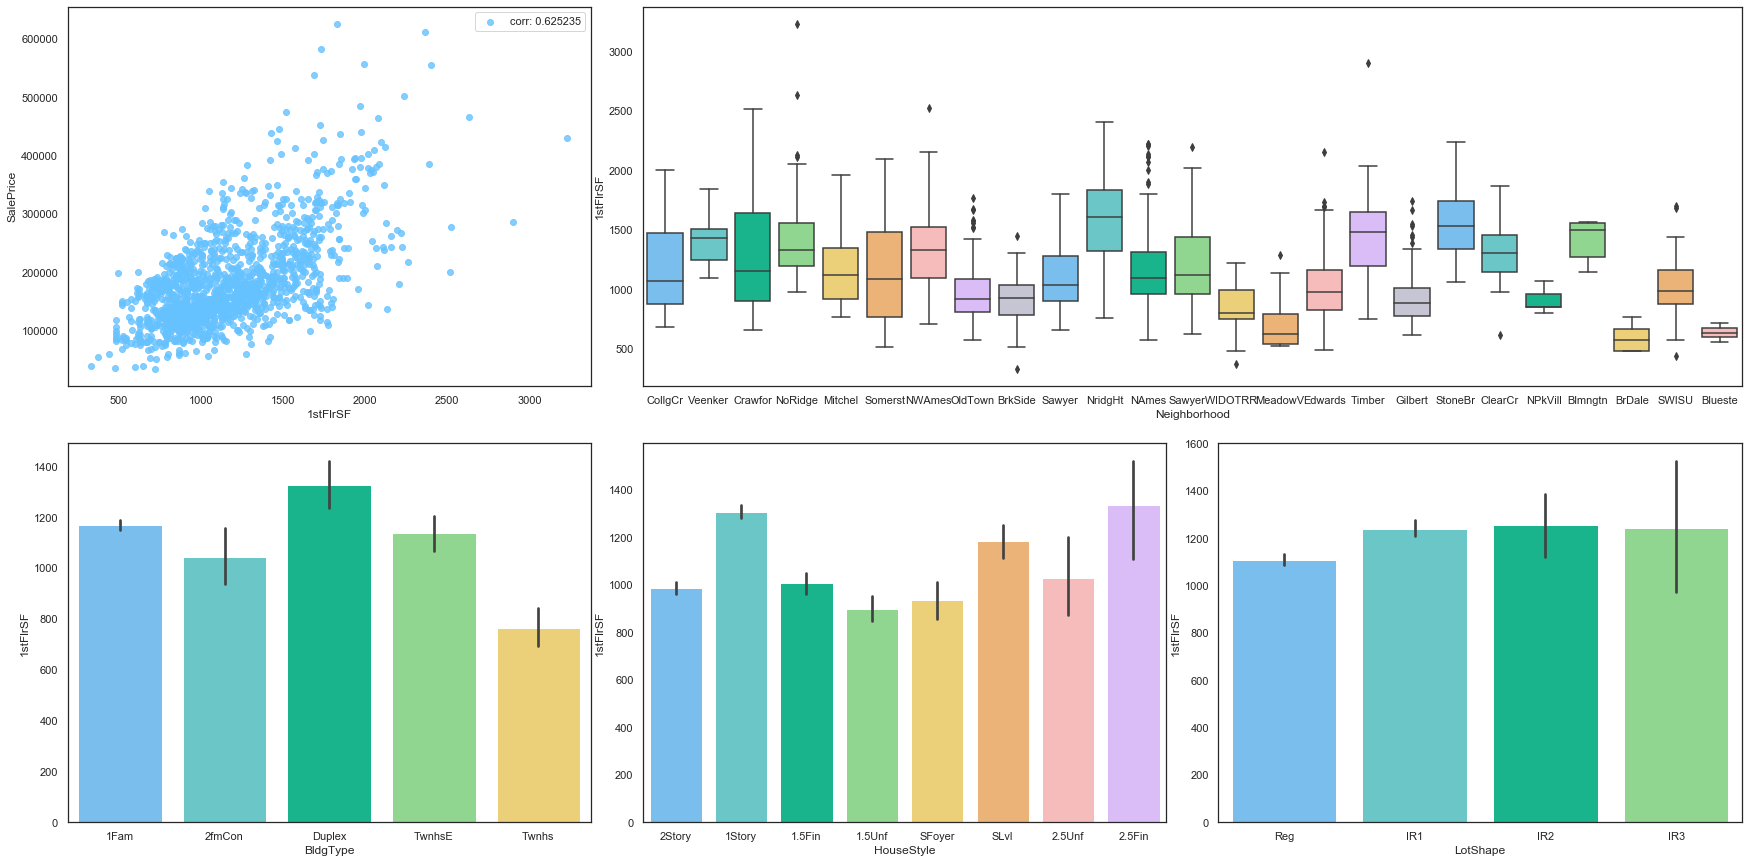

In [38]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['1stFlrSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['1stFlrSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="1stFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="1stFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="1stFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="1stFlrSF", data=train, palette = mycols);

Очевидно, что это показывает очень высокую положительную корреляцию с SalePrice, это будет важной особенностью при моделировании.
Опять же, эта функция сильно варьируется в зависимости от района, и размер этой функции варьируется в зависимости от типа и стиля здания. 
Эта функция не так сильно отличается в зависимости от размера участка.
Так как это непрерывная числовая функция, я еще раз добавлю эту функцию в корзину и создам фиктивные переменные. 

In [39]:
all_data['1stFlrSF_Band'] = pd.cut(all_data['1stFlrSF'], 6)
all_data['1stFlrSF_Band'].unique()

[(329.239, 1127.5], (1127.5, 1921.0], (1921.0, 2714.5], (2714.5, 3508.0], (3508.0, 4301.5], (4301.5, 5095.0]]
Categories (6, interval[float64]): [(329.239, 1127.5] < (1127.5, 1921.0] < (1921.0, 2714.5] < (2714.5, 3508.0] < (3508.0, 4301.5] < (4301.5, 5095.0]]

In [40]:
all_data.loc[all_data['1stFlrSF']<=1127.5, '1stFlrSF'] = 1
all_data.loc[(all_data['1stFlrSF']>1127.5) & (all_data['1stFlrSF']<=1921), '1stFlrSF'] = 2
all_data.loc[(all_data['1stFlrSF']>1921) & (all_data['1stFlrSF']<=2714.5), '1stFlrSF'] = 3
all_data.loc[(all_data['1stFlrSF']>2714.5) & (all_data['1stFlrSF']<=3508), '1stFlrSF'] = 4
all_data.loc[(all_data['1stFlrSF']>3508) & (all_data['1stFlrSF']<=4301.5), '1stFlrSF'] = 5
all_data.loc[all_data['1stFlrSF']>4301.5, '1stFlrSF'] = 6
all_data['1stFlrSF'] = all_data['1stFlrSF'].astype(int)

all_data.drop('1stFlrSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["1stFlrSF"], prefix="1stFlrSF")
all_data.head(3)

2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  \
0       854          0  None             3     1Fam         3             1   
1         0          0  None             3     1Fam         3             4   
2       866          0  None             3     1Fam         3             2   

   BsmtFullBath  BsmtHalfBath  BsmtQual  ... TotalBsmtSF_5 TotalBsmtSF_6  \
0           1.0           0.0         3  ...             0             0   
1           0.0           1.0         3  ...             0             0   
2           1.0           0.0         3  ...             0             0   

  TotalBsmtSF_7 TotalBsmtSF_8  1stFlrSF_1 1stFlrSF_2 1stFlrSF_3 1stFlrSF_4  \
0             0             0           1          0          0          0   
1             0             0           0          1          0          0   
2             0             0           1          0          0          0   

  1stFlrSF_5 1stFlrSF_6  
0          0          0  
1          0          0  
2          0          0  

[3 rows x 152 columns]

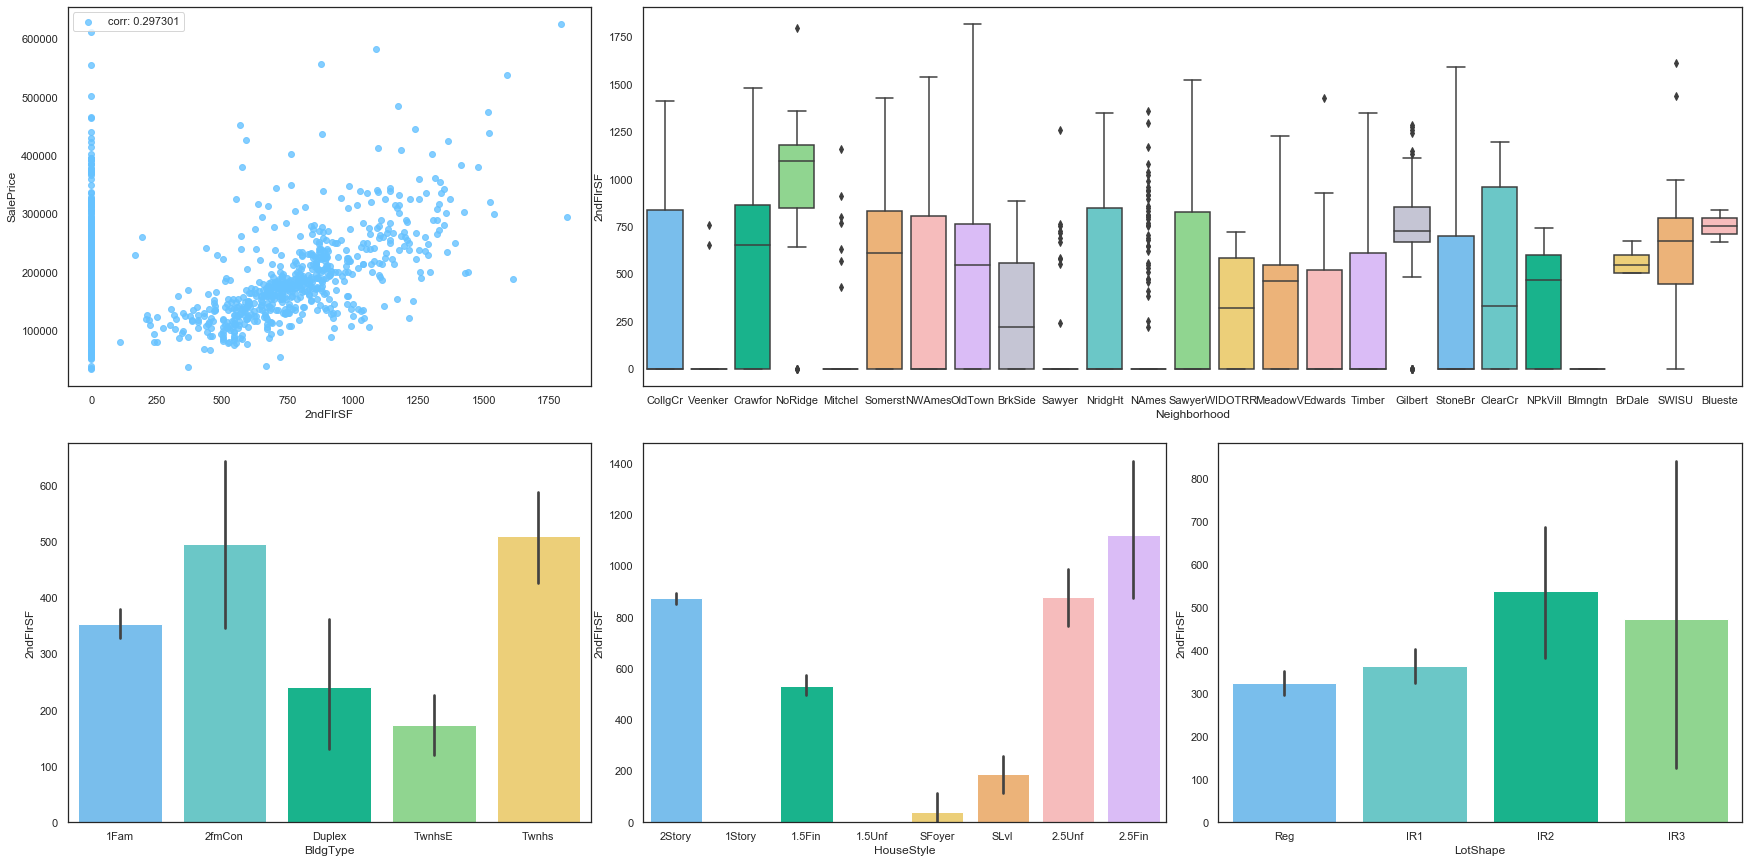

In [41]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['2ndFlrSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['2ndFlrSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="2ndFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="2ndFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="2ndFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="2ndFlrSF", data=train, palette = mycols);

Интересно, что мы видим весьма положительно коррелированные отношения с SalePrice, однако мы также видим значительное количество домов со значением = 0.
Это объясняется и другими визуальными эффектами, показывающими, что некоторые стили домов, возможно, не имеют второго этажа, следовательно, не могут иметь значения для этой особенности - например, "1Story" дома.
Мы также видим высокую зависимость и вариативность между районами, типами зданий и размерами участков.
Очевидно, что в данном анализе важны все переменные, связанные с "пространством". Так как эта особенность является непрерывной числовой, то я ее разобью и создам фиктивные переменные.

In [42]:

all_data['2ndFlrSF_Band'] = pd.cut(all_data['2ndFlrSF'], 6)
all_data['2ndFlrSF_Band'].unique()

[(620.667, 931.0], (-1.862, 310.333], (931.0, 1241.333], (310.333, 620.667], (1241.333, 1551.667], (1551.667, 1862.0]]
Categories (6, interval[float64]): [(-1.862, 310.333] < (310.333, 620.667] < (620.667, 931.0] < (931.0, 1241.333] < (1241.333, 1551.667] < (1551.667, 1862.0]]

In [43]:

all_data.loc[all_data['2ndFlrSF']<=310.333, '2ndFlrSF'] = 1
all_data.loc[(all_data['2ndFlrSF']>310.333) & (all_data['2ndFlrSF']<=620.667), '2ndFlrSF'] = 2
all_data.loc[(all_data['2ndFlrSF']>620.667) & (all_data['2ndFlrSF']<=931), '2ndFlrSF'] = 3
all_data.loc[(all_data['2ndFlrSF']>931) & (all_data['2ndFlrSF']<=1241.333), '2ndFlrSF'] = 4
all_data.loc[(all_data['2ndFlrSF']>1241.333) & (all_data['2ndFlrSF']<=1551.667), '2ndFlrSF'] = 5
all_data.loc[all_data['2ndFlrSF']>1551.667, '2ndFlrSF'] = 6
all_data['2ndFlrSF'] = all_data['2ndFlrSF'].astype(int)

all_data.drop('2ndFlrSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["2ndFlrSF"], prefix="2ndFlrSF")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  \
0          0  None             3     1Fam         3             1   
1          0  None             3     1Fam         3             4   
2          0  None             3     1Fam         3             2   

   BsmtFullBath  BsmtHalfBath  BsmtQual CentralAir  ... 1stFlrSF_3 1stFlrSF_4  \
0           1.0           0.0         3          Y  ...          0          0   
1           0.0           1.0         3          Y  ...          0          0   
2           1.0           0.0         3          Y  ...          0          0   

  1stFlrSF_5  1stFlrSF_6 2ndFlrSF_1 2ndFlrSF_2 2ndFlrSF_3 2ndFlrSF_4  \
0          0           0          0          0          1          0   
1          0           0          1          0          0          0   
2          0           0          0          0          1          0   

  2ndFlrSF_5 2ndFlrSF_6  
0          0          0  
1          0          0  
2          0          0  

[3 rows x 157 columns]

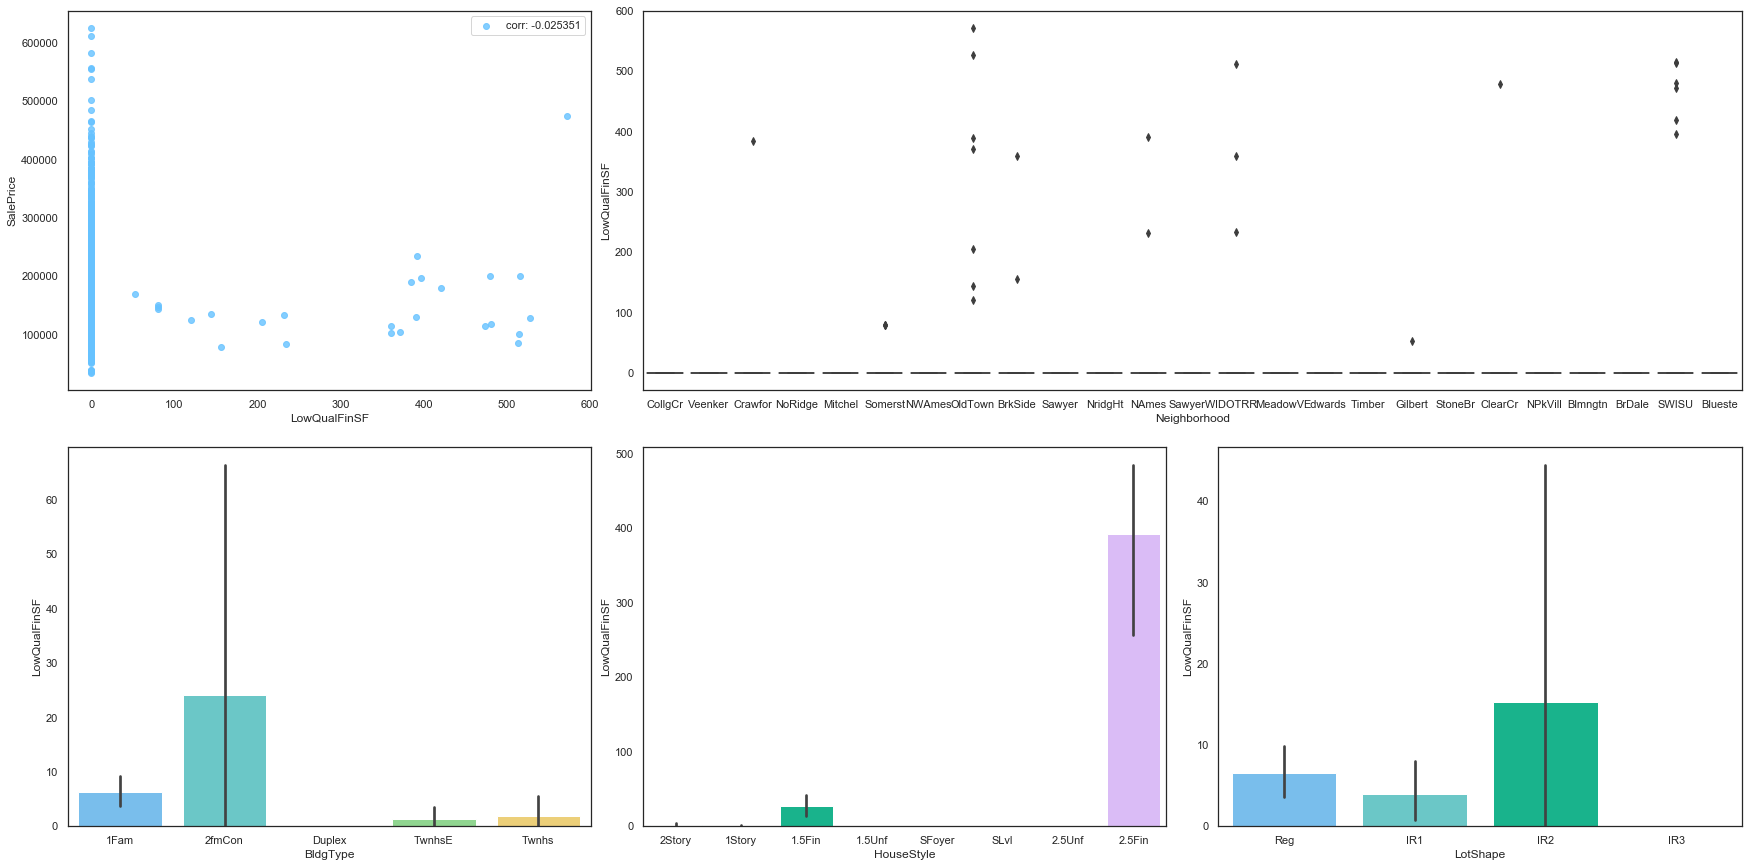

In [44]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['LowQualFinSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['LowQualFinSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="LowQualFinSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="LowQualFinSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="LowQualFinSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="LowQualFinSF", data=train, palette = mycols);

Мы видим, что существует большое количество свойств со значением 0 для этой функции. Очевидно, что она не имеет значительной корреляции с SalePrice.
По этой причине я заменю на 1.

In [45]:

all_data['LowQualFinSF_Flag'] = all_data['LowQualFinSF'].map(lambda x:0 if x==0 else 1)
all_data.drop('LowQualFinSF', axis=1, inplace=True)

In [46]:
all_data['TotalBathrooms'] = all_data['BsmtHalfBath'] + all_data['BsmtFullBath'] + all_data['HalfBath'] + all_data['FullBath']

columns = ['BsmtHalfBath', 'BsmtFullBath', 'HalfBath', 'FullBath']
all_data.drop(columns, axis=1, inplace=True)

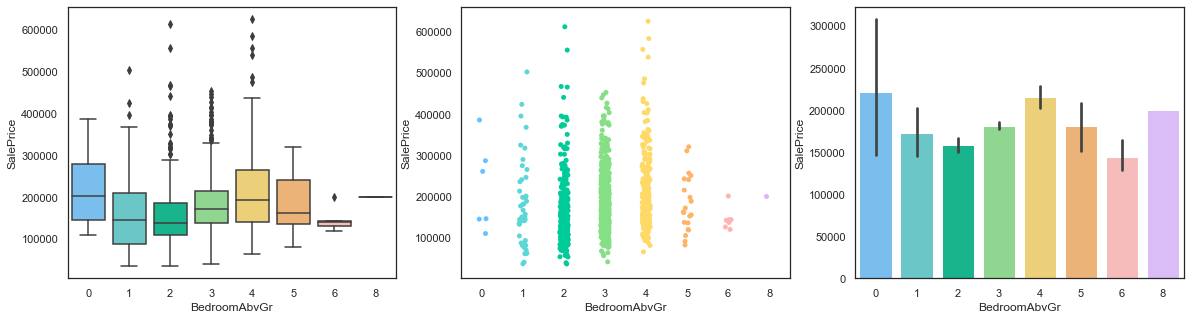

In [47]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BedroomAbvGr", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="BedroomAbvGr", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BedroomAbvGr", y="SalePrice", data=train, palette = mycols);

Мы видим много домов с 2 3 и 4 спальнями над землей, и очень мало домов с 6 и выше.
Так как это непрерывная числовая функция, я оставлю ее такой, какая она есть.

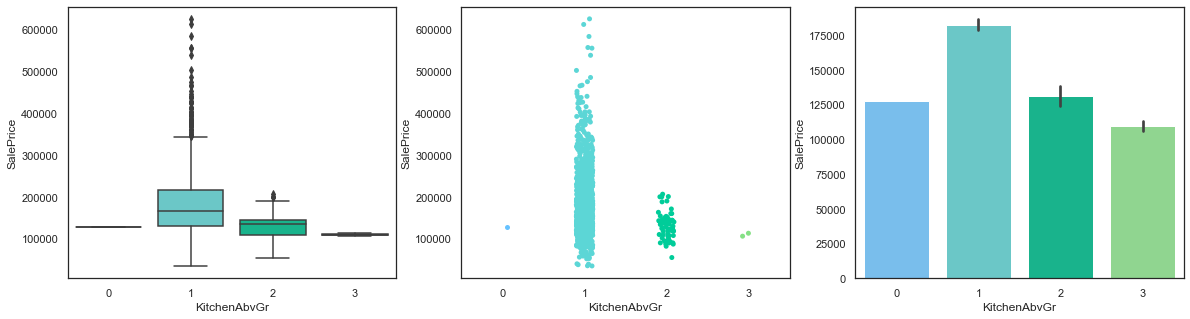

In [48]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="KitchenAbvGr", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="KitchenAbvGr", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="KitchenAbvGr", y="SalePrice", data=train, palette = mycols);

Как и в прошлый раз, мы видим лишь небольшое количество домов с большим количеством кухонь выше класса. Это показывает, что большинство домов имеют 1 кухню выше класса.
Поскольку это непрерывная числовая функция, я оставлю ее такой, какая она есть.

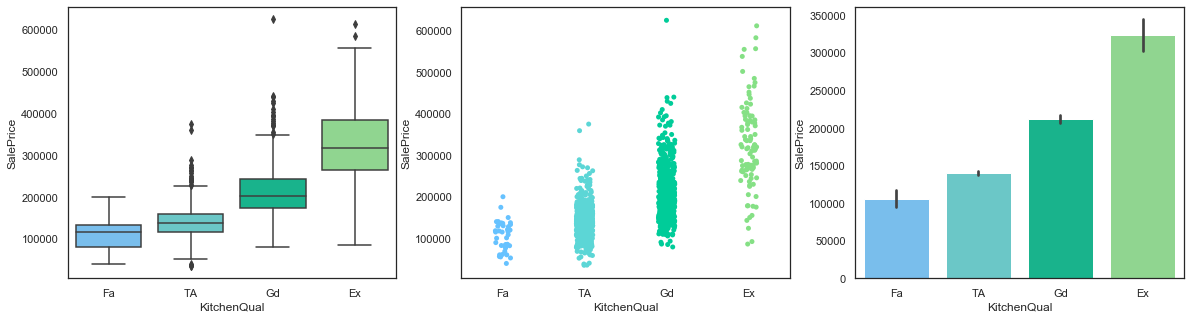

In [49]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="KitchenQual", y="SalePrice", data=train, order=["Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="KitchenQual", y="SalePrice", data=train, size = 5, jitter = True, order=["Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="KitchenQual", y="SalePrice", data=train, order=["Fa", "TA", "Gd", "Ex"], palette = mycols);

Существует явная положительная корреляция с SalePrice и качеством кухни.
Есть, однако, одно значение для "Gd", которое имеет чрезвычайно высокую цену SalePrice.
Для этой функции, так как она категорична с заказом, я заменю эти значения вручную.

In [50]:
all_data['KitchenQual'] = all_data['KitchenQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['KitchenQual'].unique()

array([3, 2, 4, 1], dtype=int64)

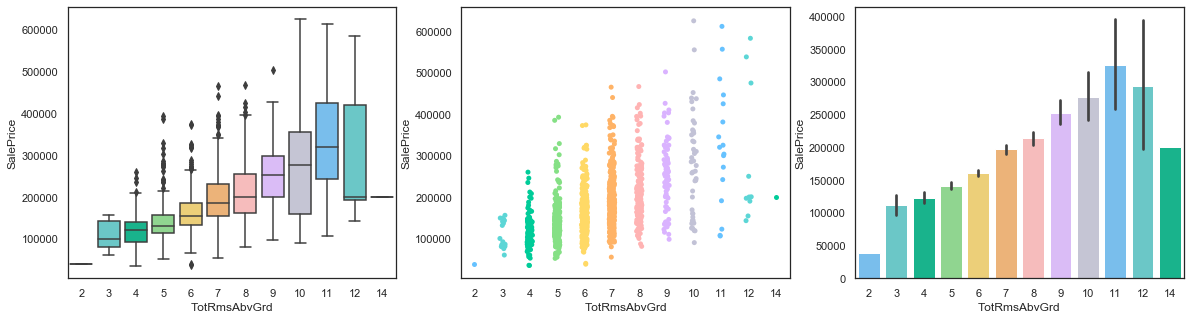

In [51]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="TotRmsAbvGrd", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="TotRmsAbvGrd", y="SalePrice", data=train, palette = mycols);

В целом мы видим положительную корреляцию, так как количество комнат увеличивается, как и SalePrice.
Однако из-за низкой частоты, мы видим некоторые ненадежные результаты для очень больших и маленьких значений для этой особенности.
Так как это непрерывная числовая функция, я оставлю ее такой, какая она есть.

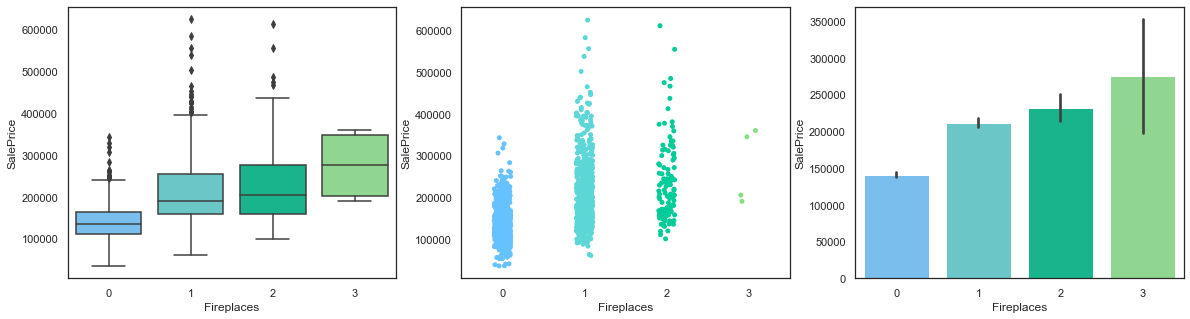

In [52]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Fireplaces", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Fireplaces", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Fireplaces", y="SalePrice", data=train, palette = mycols);

В очередной раз мы имеем положительную корреляцию с SalePrice, так как большинство домов имеют всего 1 или 0 каминов.
Я оставлю эту функцию как есть.

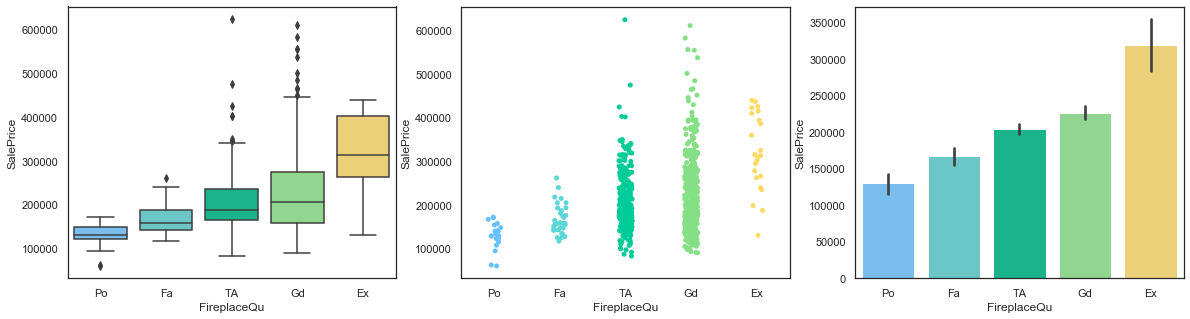

In [53]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="FireplaceQu", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="FireplaceQu", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="FireplaceQu", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

Мы также видим положительную корреляцию и повышение качества камина. Большинство домов имеют камины качества "TA" или "Gd". 
Так как это категорическая особенность с порядком, я заменю значения вручную.

In [54]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['FireplaceQu'].unique()

array([0, 3, 4, 2, 5, 1], dtype=int64)

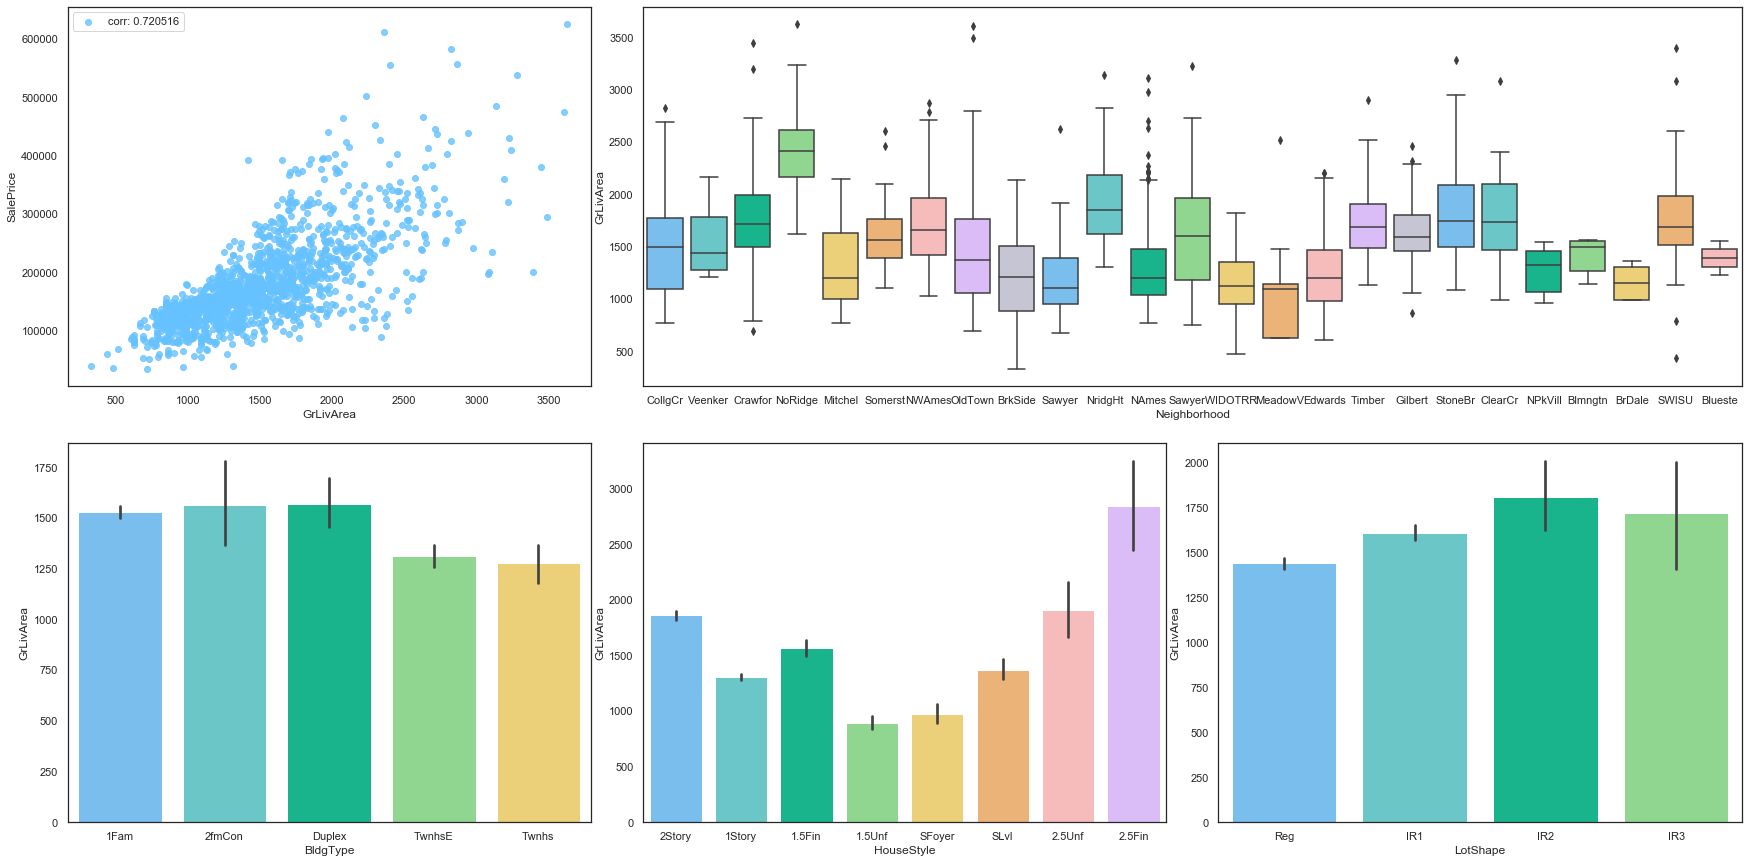

In [55]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['GrLivArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="GrLivArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="GrLivArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="GrLivArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="GrLivArea", data=train, palette = mycols);

Мы видим очень высокую положительную корреляцию с SalePrice.
Мы также видим очень высокую разницу в ценах между стилями домов и воспитания детей.
Так как это будет важной особенностью в нашем моделировании, я буду создавать мусорные ящики и манекены.

In [56]:

all_data['GrLivArea_Band'] = pd.cut(all_data['GrLivArea'], 6)
all_data['GrLivArea_Band'].unique()

[(1127.5, 1921.0], (1921.0, 2714.5], (329.239, 1127.5], (2714.5, 3508.0], (3508.0, 4301.5], (4301.5, 5095.0]]
Categories (6, interval[float64]): [(329.239, 1127.5] < (1127.5, 1921.0] < (1921.0, 2714.5] < (2714.5, 3508.0] < (3508.0, 4301.5] < (4301.5, 5095.0]]

In [57]:
all_data.loc[all_data['GrLivArea']<=1127.5, 'GrLivArea'] = 1
all_data.loc[(all_data['GrLivArea']>1127.5) & (all_data['GrLivArea']<=1921), 'GrLivArea'] = 2
all_data.loc[(all_data['GrLivArea']>1921) & (all_data['GrLivArea']<=2714.5), 'GrLivArea'] = 3
all_data.loc[(all_data['GrLivArea']>2714.5) & (all_data['GrLivArea']<=3508), 'GrLivArea'] = 4
all_data.loc[(all_data['GrLivArea']>3508) & (all_data['GrLivArea']<=4301.5), 'GrLivArea'] = 5
all_data.loc[all_data['GrLivArea']>4301.5, 'GrLivArea'] = 6
all_data['GrLivArea'] = all_data['GrLivArea'].astype(int)

all_data.drop('GrLivArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GrLivArea"], prefix="GrLivArea")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  BsmtQual  \
0          0  None             3     1Fam         3             1         3   
1          0  None             3     1Fam         3             4         3   
2          0  None             3     1Fam         3             2         3   

  CentralAir Condition1 Condition2  ... 2ndFlrSF_5  2ndFlrSF_6  \
0          Y       Norm       Norm  ...          0           0   
1          Y      Feedr       Norm  ...          0           0   
2          Y       Norm       Norm  ...          0           0   

  LowQualFinSF_Flag TotalBathrooms GrLivArea_1 GrLivArea_2 GrLivArea_3  \
0                 0            4.0           0           1           0   
1                 0            3.0           0           1           0   
2                 0            4.0           0           1           0   

   GrLivArea_4  GrLivArea_5 GrLivArea_6  
0            0            0           0  
1            0            0           0  
2            0            0           0  

[3 rows x 159 columns]

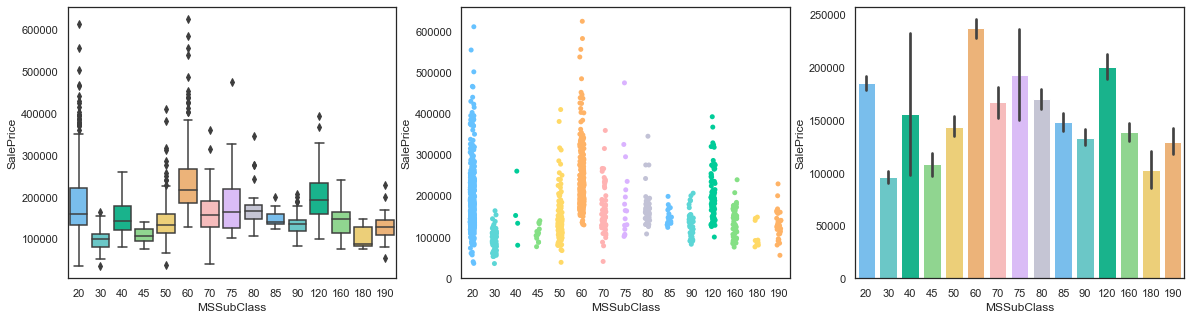

In [58]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MSSubClass", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="MSSubClass", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MSSubClass", y="SalePrice", data=train, palette = mycols);

Каждый из этих классов представляет собой совершенно другой стиль построения, как показано в описании данных. Следовательно, мы можем видеть большие различия между классами с SalePrice. 
Это числовая характеристика, но на самом деле она должна быть категоричной. Я мог бы сгруппировать некоторые из этих категорий вместе, но пока что я создам фиктивную особенность для каждой категории.

In [59]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

all_data = pd.get_dummies(all_data, columns = ["MSSubClass"], prefix="MSSubClass")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  BsmtQual  \
0          0  None             3     1Fam         3             1         3   
1          0  None             3     1Fam         3             4         3   
2          0  None             3     1Fam         3             2         3   

  CentralAir Condition1 Condition2  ... MSSubClass_30  MSSubClass_40  \
0          Y       Norm       Norm  ...             0              0   
1          Y      Feedr       Norm  ...             0              0   
2          Y       Norm       Norm  ...             0              0   

  MSSubClass_45 MSSubClass_50 MSSubClass_60 MSSubClass_70 MSSubClass_75  \
0             0             0             1             0             0   
1             0             0             0             0             0   
2             0             0             1             0             0   

   MSSubClass_80  MSSubClass_85 MSSubClass_90  
0              0              0             0  
1              0              0             0  
2              0              0             0  

[3 rows x 174 columns]

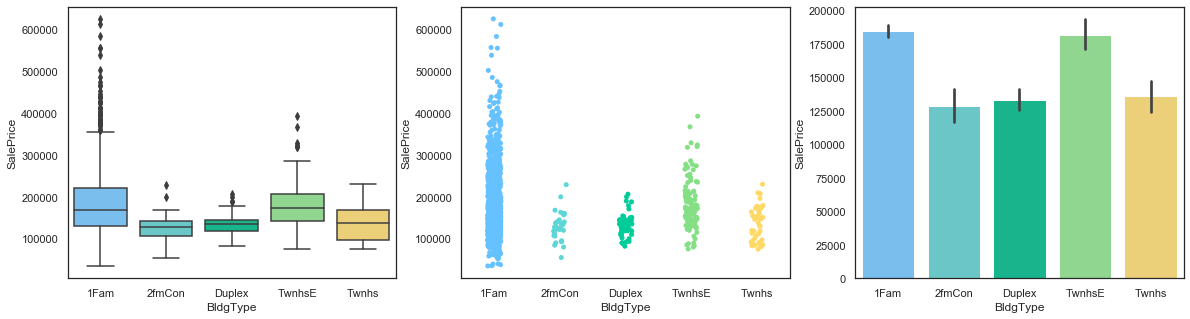

In [60]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BldgType", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="BldgType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BldgType", y="SalePrice", data=train, palette = mycols);

В различных категориях представлен диапазон средних цен SalePrice's. Класс с наибольшим количеством наблюдений - "1Fam". 
Мы также видим, что дисперсия внутри классов достаточно жесткая, в каждом случае всего несколько экстремальных значений.
Можно было бы объединить эти классы в кластеры, однако пока что я собираюсь создать фиктивные признаки.

In [61]:
all_data['BldgType'] = all_data['BldgType'].astype(str)

all_data = pd.get_dummies(all_data, columns = ["BldgType"], prefix="BldgType")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  MSSubClass_70 MSSubClass_75  \
0       Norm       Norm      SBrkr  ...              0             0   
1      Feedr       Norm      SBrkr  ...              0             0   
2       Norm       Norm      SBrkr  ...              0             0   

  MSSubClass_80 MSSubClass_85 MSSubClass_90 BldgType_1Fam  BldgType_2fmCon  \
0             0             0             0             1                0   
1             0             0             0             1                0   
2             0             0             0             1                0   

   BldgType_Duplex BldgType_Twnhs BldgType_TwnhsE  
0                0              0               0  
1                0              0               0  
2                0              0               0  

[3 rows x 178 columns]

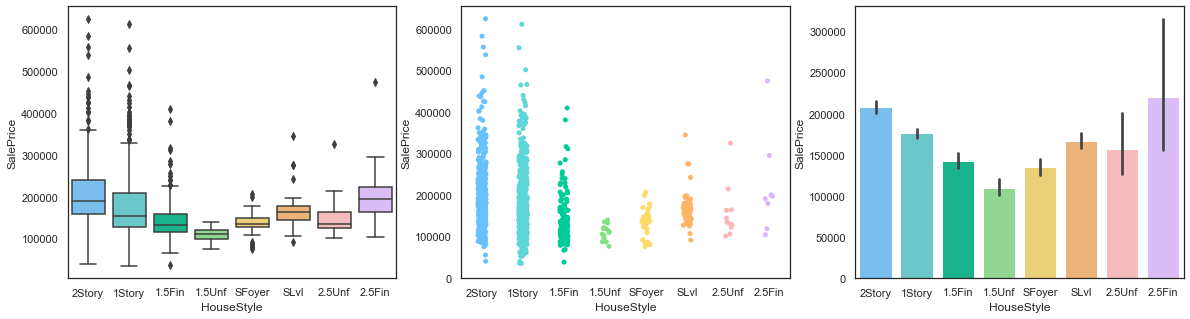

In [62]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="HouseStyle", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="HouseStyle", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="HouseStyle", y="SalePrice", data=train, palette = mycols);

Здесь мы видим довольно много экстремальных значений по категориям и большой вес наблюдений по отношению к целочисленным сюжетным домам.
Несмотря на то, что самый высокий средний показатель SalePrice исходит от "2,5Fin", он имеет очень высокое стандартное отклонение и поэтому более надежно, "2Story" дома в среднем также имеют очень высокую цену.
Так как есть некоторые категории с очень небольшим количеством значений, я буду объединять их в другую категорию и создавать фиктивные переменные.

In [63]:
all_data['HouseStyle'] = all_data['HouseStyle'].map({"2Story":"2Story", "1Story":"1Story", "1.5Fin":"1.5Story", "1.5Unf":"1.5Story", 
                                                     "SFoyer":"SFoyer", "SLvl":"SLvl", "2.5Unf":"2.5Story", "2.5Fin":"2.5Story"})

all_data = pd.get_dummies(all_data, columns = ["HouseStyle"], prefix="HouseStyle")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  BldgType_2fmCon BldgType_Duplex  \
0       Norm       Norm      SBrkr  ...                0               0   
1      Feedr       Norm      SBrkr  ...                0               0   
2       Norm       Norm      SBrkr  ...                0               0   

  BldgType_Twnhs BldgType_TwnhsE HouseStyle_1.5Story HouseStyle_1Story  \
0              0               0                   0                 0   
1              0               0                   0                 1   
2              0               0                   0                 0   

   HouseStyle_2.5Story  HouseStyle_2Story HouseStyle_SFoyer HouseStyle_SLvl  
0                    0                  1                 0               0  
1                    0                  0                 0               0  
2                    0                  1                 0               0  

[3 rows x 183 columns]

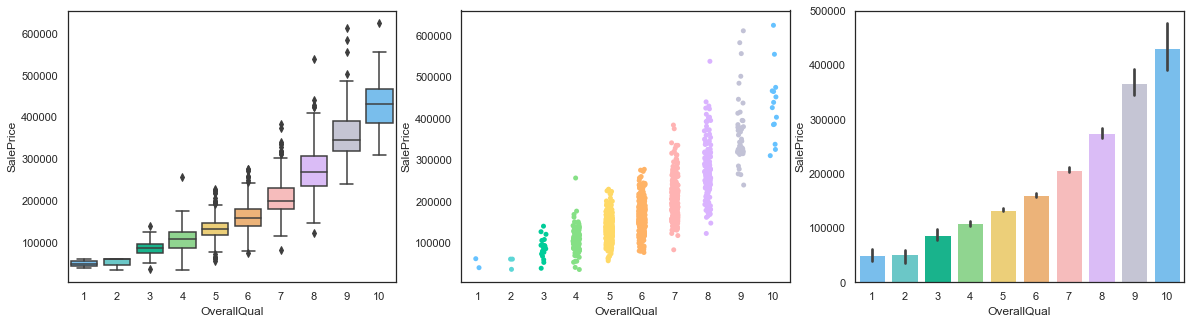

In [64]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="OverallQual", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="OverallQual", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="OverallQual", y="SalePrice", data=train, palette = mycols);

Эта функция, хотя и числовая, на самом деле является категоричной и порядковой, так как значение увеличивается, как и SalePrice. Следовательно, я сохраню его в качестве числового элемента.
Мы видим здесь хорошую положительную корреляцию с увеличением TotalQual и SalePrice, как и ожидали.

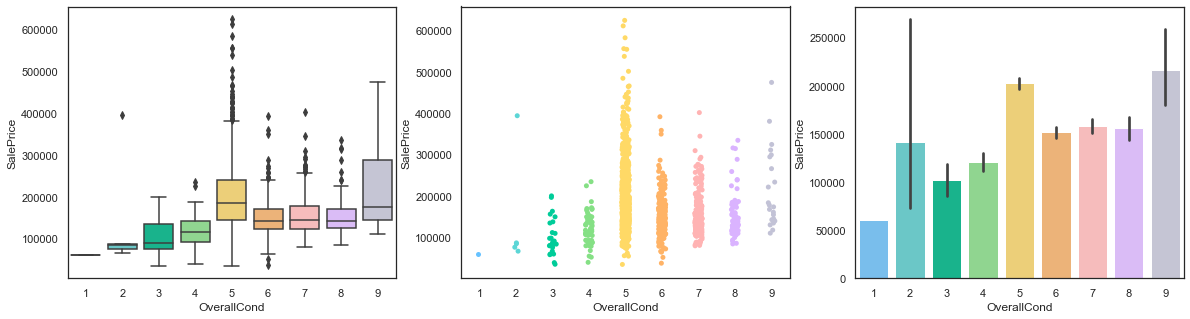

In [65]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="OverallCond", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="OverallCond", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="OverallCond", y="SalePrice", data=train, palette = mycols);

Интересно, что здесь мы видим, что она действительно следует за положительной корреляцией с SalePrice, однако мы видим пик на значении 5, наряду с большим количеством наблюдений на этом значении.
Самый высокий средний SalePrice на самом деле исходит из значения 5, а не 10, что может быть разумным предположением.
Для этой особенности я оставлю ее числовой и порядковой.

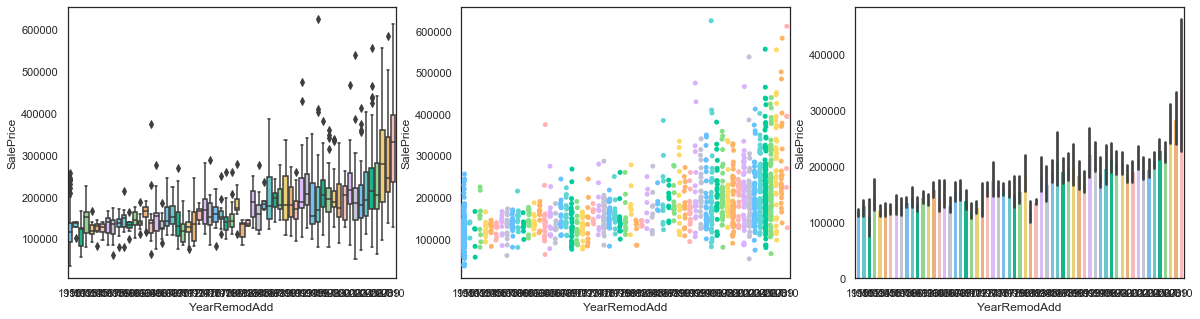

In [66]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="YearRemodAdd", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="YearRemodAdd", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="YearRemodAdd", y="SalePrice", data=train, palette = mycols);

Здесь мы видим, что чем больше дом перестраивается, тем выше цена продажи.
Из описания данных я считаю, что создание новой функции, описывающей разницу в количестве лет между перепланировкой и строительством, может быть хорошим выбором.

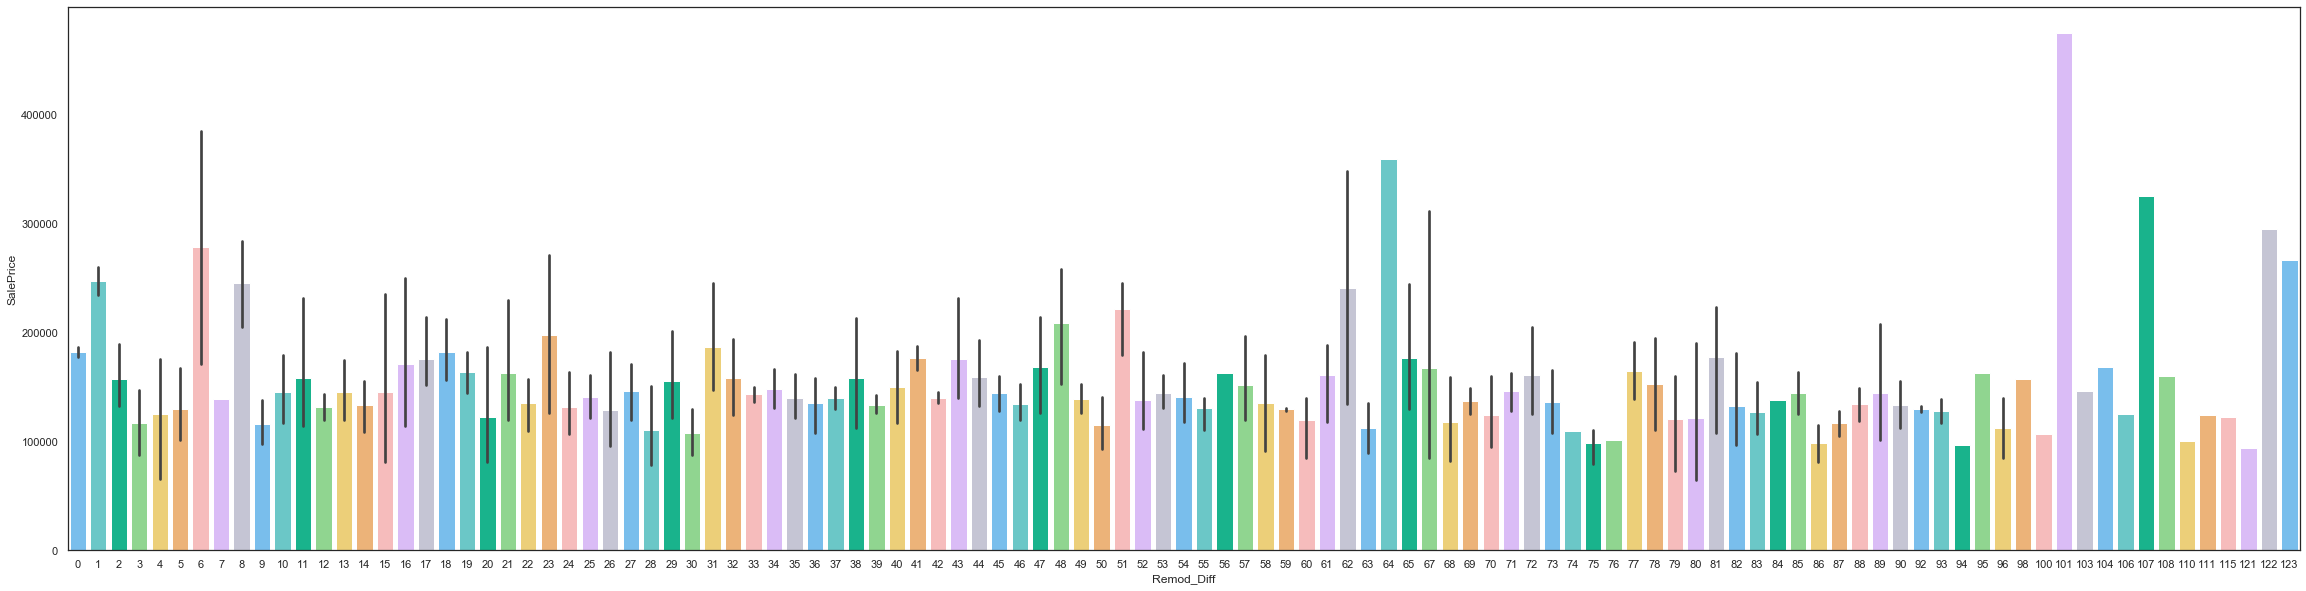

In [67]:
train['Remod_Diff'] = train['YearRemodAdd'] - train['YearBuilt']

plt.subplots(figsize =(40, 10))
sns.barplot(x="Remod_Diff", y="SalePrice", data=train, palette = mycols);

Очевидно, что существуют ценности, которые имеют гораздо более высокую цену продажи, чем другие. Я оставлю эту функцию как есть.

In [68]:
all_data['Remod_Diff'] = all_data['YearRemodAdd'] - all_data['YearBuilt']

all_data.drop('YearRemodAdd', axis=1, inplace=True)

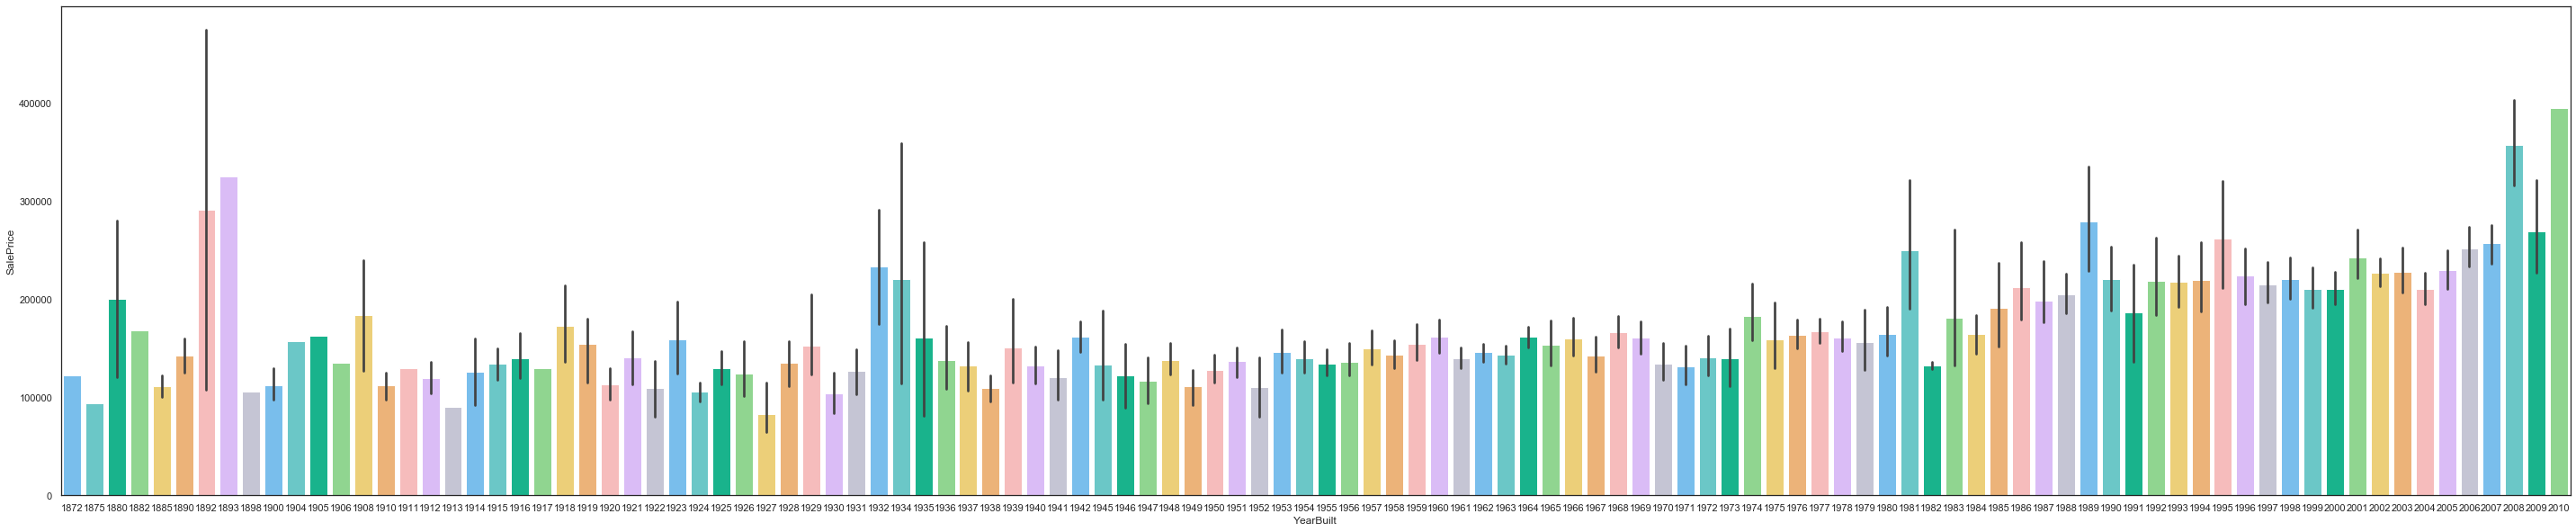

In [69]:
plt.subplots(figsize =(50, 10))

sns.barplot(x="YearBuilt", y="SalePrice", data=train, palette = mycols);

Здесь мы видим довольно устойчивую восходящую тенденцию для SalePrice, так как дома более современные. 
Для этой функции я собираюсь создать мусорные ящики и манекены.

In [70]:
all_data['YearBuilt_Band'] = pd.cut(all_data['YearBuilt'], 7)
all_data['YearBuilt_Band'].unique()

[(1990.286, 2010.0], (1970.571, 1990.286], (1911.429, 1931.143], (1931.143, 1950.857], (1950.857, 1970.571], (1891.714, 1911.429], (1871.862, 1891.714]]
Categories (7, interval[float64]): [(1871.862, 1891.714] < (1891.714, 1911.429] < (1911.429, 1931.143] < (1931.143, 1950.857] < (1950.857, 1970.571] < (1970.571, 1990.286] < (1990.286, 2010.0]]

In [71]:
all_data.loc[all_data['YearBuilt']<=1892, 'YearBuilt'] = 1
all_data.loc[(all_data['YearBuilt']>1892) & (all_data['YearBuilt']<=1911), 'YearBuilt'] = 2
all_data.loc[(all_data['YearBuilt']>1911) & (all_data['YearBuilt']<=1931), 'YearBuilt'] = 3
all_data.loc[(all_data['YearBuilt']>1931) & (all_data['YearBuilt']<=1951), 'YearBuilt'] = 4
all_data.loc[(all_data['YearBuilt']>1951) & (all_data['YearBuilt']<=1971), 'YearBuilt'] = 5
all_data.loc[(all_data['YearBuilt']>1971) & (all_data['YearBuilt']<=1990), 'YearBuilt'] = 6
all_data.loc[all_data['YearBuilt']>1990, 'YearBuilt'] = 7
all_data['YearBuilt'] = all_data['YearBuilt'].astype(int)

all_data.drop('YearBuilt_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["YearBuilt"], prefix="YearBuilt")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  HouseStyle_SFoyer HouseStyle_SLvl  \
0       Norm       Norm      SBrkr  ...                  0               0   
1      Feedr       Norm      SBrkr  ...                  0               0   
2       Norm       Norm      SBrkr  ...                  0               0   

  Remod_Diff YearBuilt_1 YearBuilt_2 YearBuilt_3  YearBuilt_4  YearBuilt_5  \
0          0           0           0           0            0            0   
1          0           0           0           0            0            0   
2          1           0           0           0            0            0   

  YearBuilt_6 YearBuilt_7  
0           0           1  
1           1           0  
2           0           1  

[3 rows x 189 columns]

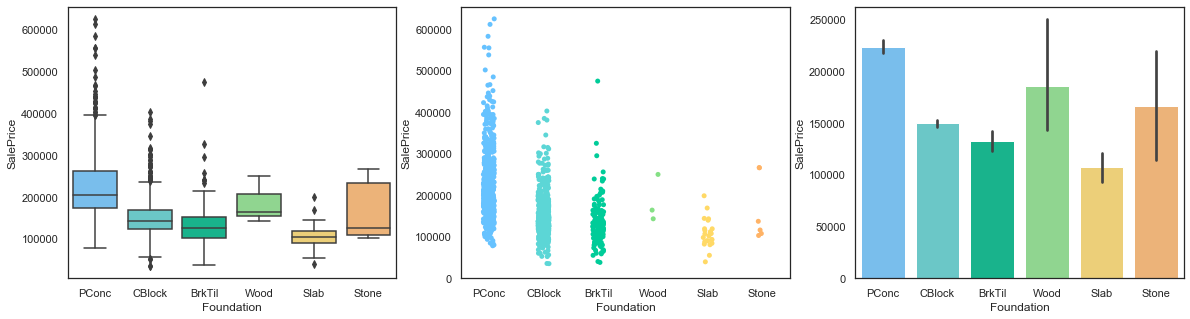

In [72]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Foundation", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="Foundation", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Foundation", y="SalePrice", data=train, palette = mycols);

У нас есть 3 класса с высокой частотой, однако у нас есть 3 класса с низкой частотой.
В связи с большой разницей в средней и средней SalePrice's через 3 нижних частотных классов, я не собираюсь кластеризовать их вместе. 
Кроме того, поскольку эта функция не является порядковым, маркировка не имеет смысла. Вместо этого я создам фиктивные переменные.

In [73]:
all_data = pd.get_dummies(all_data, columns = ["Foundation"], prefix="Foundation")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  YearBuilt_4 YearBuilt_5 YearBuilt_6  \
0       Norm       Norm      SBrkr  ...            0           0           0   
1      Feedr       Norm      SBrkr  ...            0           0           1   
2       Norm       Norm      SBrkr  ...            0           0           0   

  YearBuilt_7 Foundation_BrkTil Foundation_CBlock  Foundation_PConc  \
0           1                 0                 0                 1   
1           0                 0                 1                 0   
2           1                 0                 0                 1   

   Foundation_Slab Foundation_Stone  Foundation_Wood  
0                0                0                0  
1                0                0                0  
2                0                0                0  

[3 rows x 194 columns]

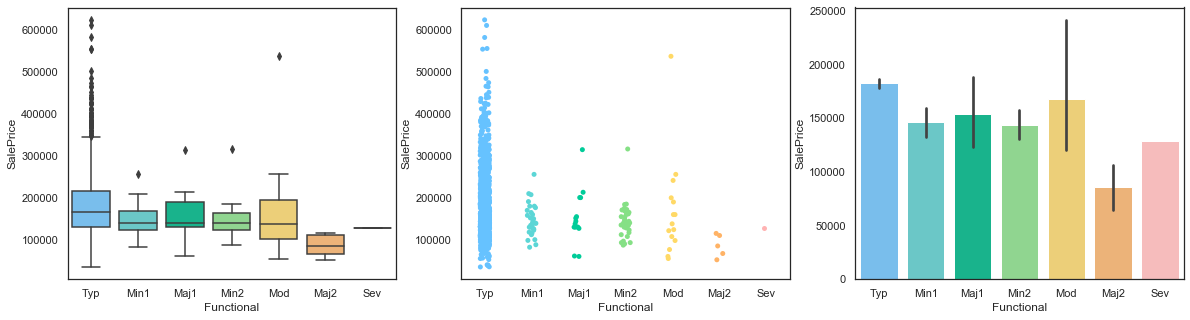

In [74]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Functional", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Functional", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Functional", y="SalePrice", data=train, palette = mycols);

Эта категоричная особенность показывает, что большинство домов имеют функциональность "Typ", и просмотр описания данных приводит меня к убеждению, что внутри этих категорий есть порядок, "Typ" - самый высокий порядок.
Поэтому я буду вручную заменять значения этой функции цифрами.

In [75]:
all_data['Functional'] = all_data['Functional'].map({"Sev":1, "Maj2":2, "Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7})
all_data['Functional'].unique()

array([7, 6, 3, 5, 4, 2, 1], dtype=int64)

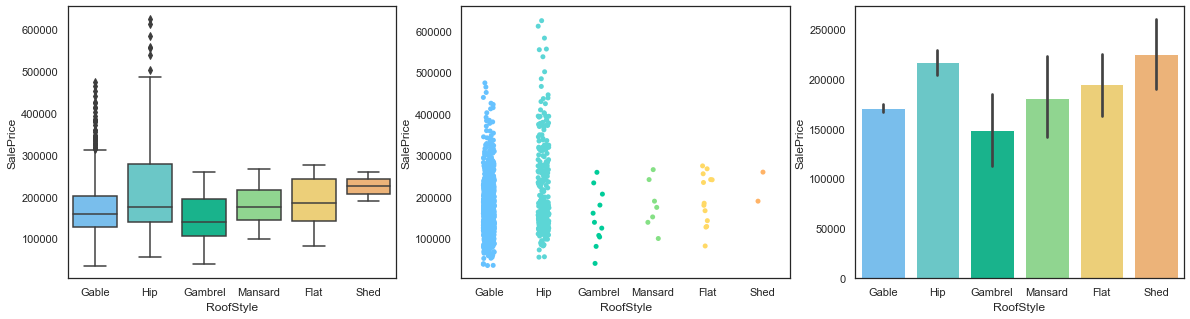

In [76]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="RoofStyle", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="RoofStyle", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="RoofStyle", y="SalePrice", data=train, palette = mycols);

Эта функция имеет две очень часто встречающиеся категории, но значения SalePrice различаются в каждой из них.
Так как это категорическая функция без порядка, я создам фиктивные переменные.

In [77]:
all_data = pd.get_dummies(all_data, columns = ["RoofStyle"], prefix="RoofStyle")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  Foundation_PConc Foundation_Slab  \
0       Norm       Norm      SBrkr  ...                 1               0   
1      Feedr       Norm      SBrkr  ...                 0               0   
2       Norm       Norm      SBrkr  ...                 1               0   

  Foundation_Stone Foundation_Wood RoofStyle_Flat RoofStyle_Gable  \
0                0               0              0               1   
1                0               0              0               1   
2                0               0              0               1   

   RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  RoofStyle_Shed  
0                  0              0                  0               0  
1                  0              0                  0               0  
2                  0              0                  0               0  

[3 rows x 199 columns]

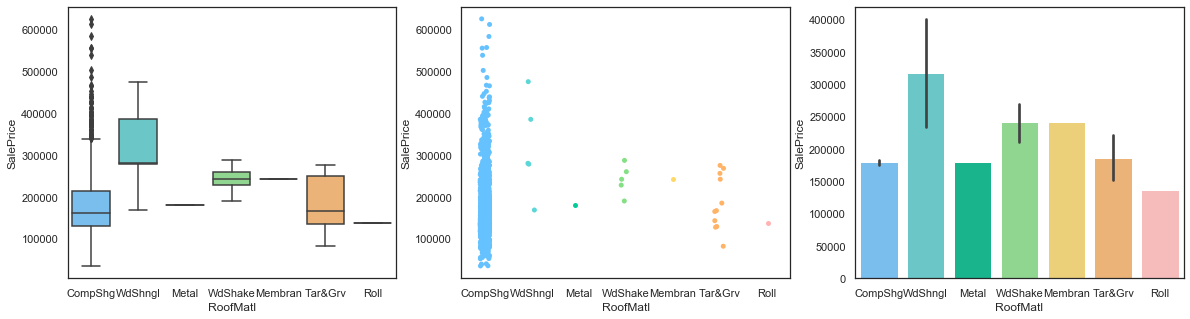

In [78]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="RoofMatl", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="RoofMatl", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="RoofMatl", y="SalePrice", data=train, palette = mycols);

Интересно, что в учебных данных по нескольким классам очень мало наблюдений. Однако, если они окажутся незначительными, то при уменьшении характеристик они будут опущены.
Поэтому я создам фиктивные переменные.

In [79]:
all_data = pd.get_dummies(all_data, columns = ["RoofMatl"], prefix="RoofMatl")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  RoofStyle_Hip RoofStyle_Mansard  \
0       Norm       Norm      SBrkr  ...              0                 0   
1      Feedr       Norm      SBrkr  ...              0                 0   
2       Norm       Norm      SBrkr  ...              0                 0   

  RoofStyle_Shed RoofMatl_CompShg RoofMatl_Membran RoofMatl_Metal  \
0              0                1                0              0   
1              0                1                0              0   
2              0                1                0              0   

   RoofMatl_Roll  RoofMatl_Tar&Grv  RoofMatl_WdShake  RoofMatl_WdShngl  
0              0                 0                 0                 0  
1              0                 0                 0                 0  
2              0                 0                 0                 0  

[3 rows x 205 columns]

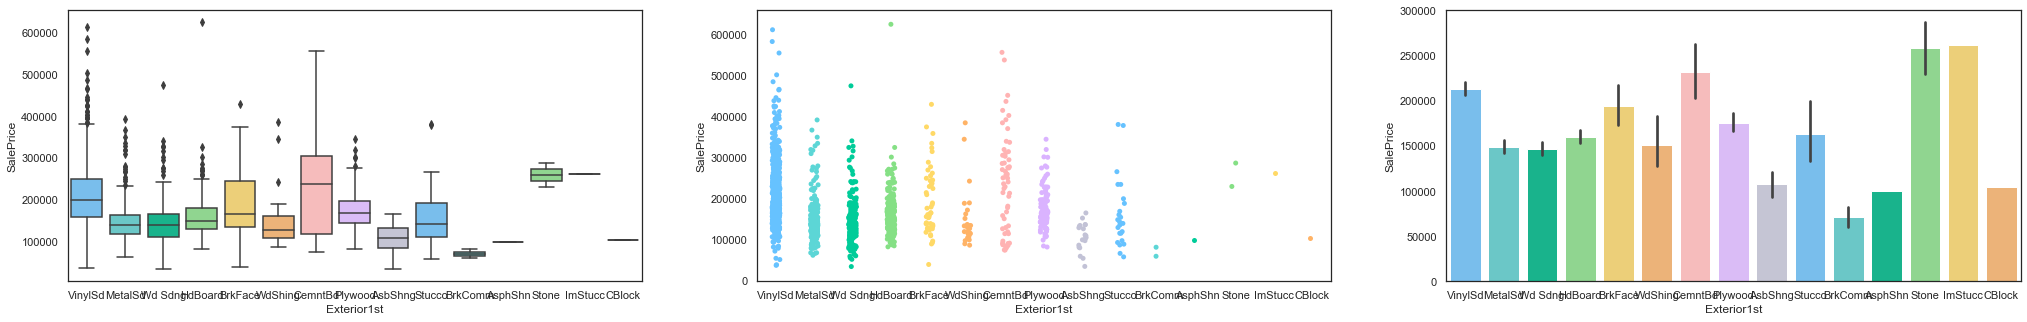

In [80]:
plt.subplots(figsize =(35, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Exterior1st", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="Exterior1st", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Exterior1st", y="SalePrice", data=train, palette = mycols);

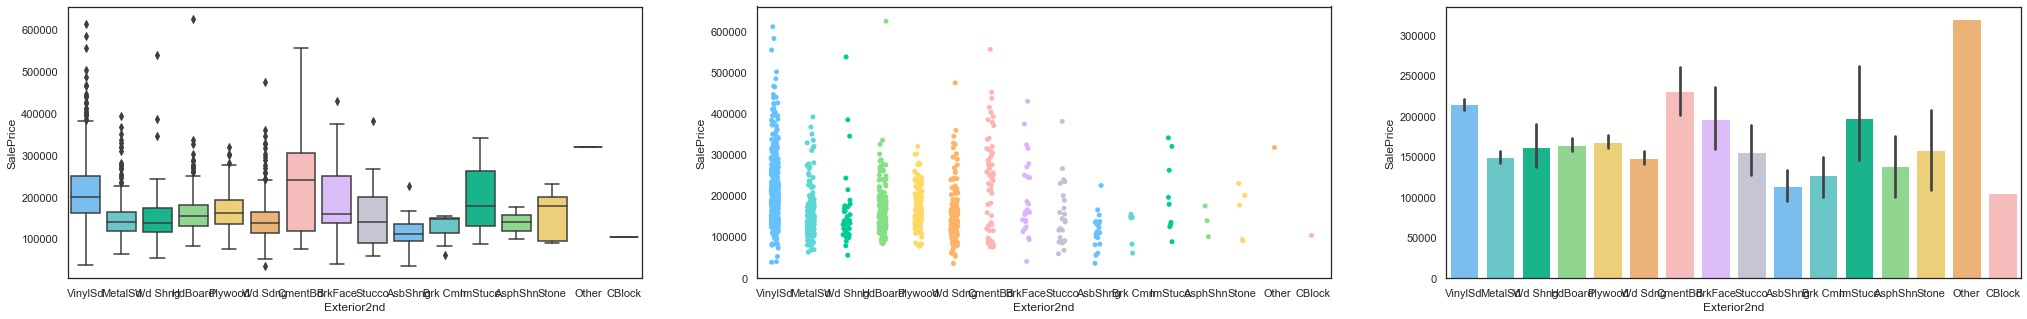

In [81]:
plt.subplots(figsize =(35, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Exterior2nd", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="Exterior2nd", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Exterior2nd", y="SalePrice", data=train, palette = mycols);

Глядя на эти две особенности вместе, мы видим, что они демонстрируют очень похожее поведение против SalePrice. Это говорит мне о том, что они очень тесно связаны. 
Поэтому я создам флаг, чтобы указать, есть ли другое 2-е внешнее покрытие по сравнению с первым.
Затем я сохраню "Exterior1st" и создам из этого фиктивные переменные.

In [82]:
def Exter2(col):
    if col['Exterior2nd'] == col['Exterior1st']:
        return 1
    else:
        return 0
    
all_data['ExteriorMatch_Flag'] = all_data.apply(Exter2, axis=1)
all_data.drop('Exterior2nd', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["Exterior1st"], prefix="Exterior1st")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  Exterior1st_CemntBd  \
0       Norm       Norm      SBrkr  ...                    0   
1      Feedr       Norm      SBrkr  ...                    0   
2       Norm       Norm      SBrkr  ...                    0   

  Exterior1st_HdBoard Exterior1st_ImStucc Exterior1st_MetalSd  \
0                   0                   0                   0   
1                   0                   0                   1   
2                   0                   0                   0   

   Exterior1st_Plywood  Exterior1st_Stone  Exterior1st_Stucco  \
0                    0                  0                   0   
1                    0                  0                   0   
2                    0                  0                   0   

   Exterior1st_VinylSd  Exterior1st_Wd Sdng Exterior1st_WdShing  
0                    1                    0                   0  
1                    0                    0                   0  
2                    1                    0                   0  

[3 rows x 219 columns]

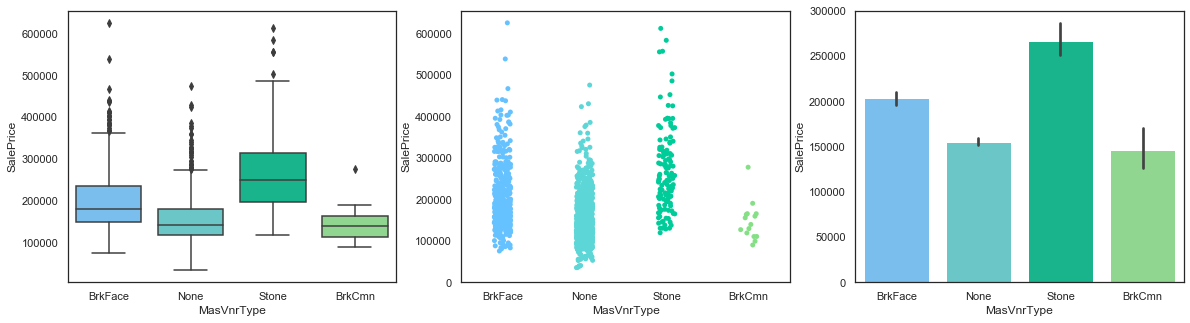

In [83]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MasVnrType", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="MasVnrType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MasVnrType", y="SalePrice", data=train, palette = mycols);

Каждый класс имеет достаточно уникальный диапазон значений для SalePrice, единственный класс, который выделяется - "BrkCmn", который имеет низкую частоту.
Очевидно, что "Камень" требует в среднем самой высокой SalePrice, хотя в пределах "BrkFace" есть некоторые экстремальные значения.
Так как это категорическая особенность без порядка, то здесь я создам фиктивные переменные.

In [84]:
all_data = pd.get_dummies(all_data, columns = ["MasVnrType"], prefix="MasVnrType")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  Exterior1st_Plywood  \
0       Norm       Norm      SBrkr  ...                    0   
1      Feedr       Norm      SBrkr  ...                    0   
2       Norm       Norm      SBrkr  ...                    0   

  Exterior1st_Stone Exterior1st_Stucco Exterior1st_VinylSd  \
0                 0                  0                   1   
1                 0                  0                   0   
2                 0                  0                   1   

   Exterior1st_Wd Sdng  Exterior1st_WdShing  MasVnrType_BrkCmn  \
0                    0                    0                  0   
1                    0                    0                  0   
2                    0                    0                  0   

   MasVnrType_BrkFace  MasVnrType_None MasVnrType_Stone  
0                   1                0                0  
1                   0                1                0  
2                   1                0                0  

[3 rows x 222 columns]

In [85]:
all_data.drop('MasVnrArea', axis=1, inplace=True)

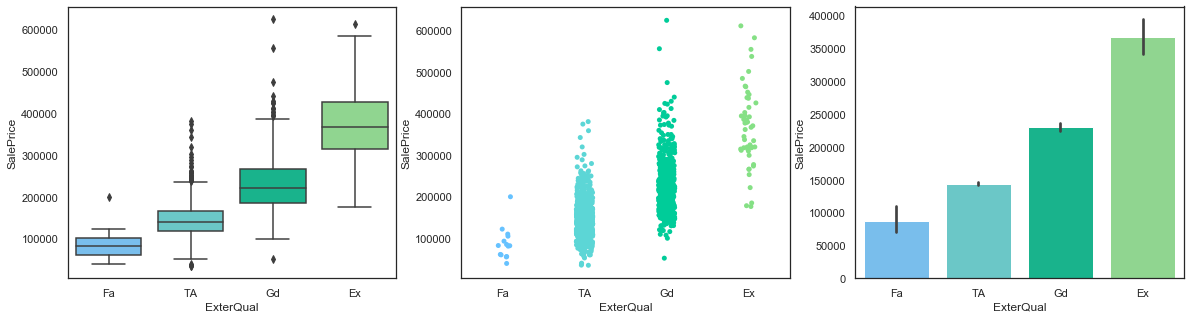

In [86]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="ExterQual", y="SalePrice", data=train, order=['Fa','TA','Gd', 'Ex'], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="ExterQual", y="SalePrice", data=train, size = 5, jitter = True, order=['Fa','TA','Gd', 'Ex'], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="ExterQual", y="SalePrice", data=train, order=['Fa','TA','Gd', 'Ex'], palette = mycols);

Здесь мы видим, что эта функция показывает четкий порядок и имеет положительную корреляцию с SalePrice. С ростом качества растет и SalePrice. 
Мы видим наибольшее количество наблюдений в двух средних классах, и наименьшее - в низшем.
Так как это категорическая особенность с порядком, я заменю эти значения вручную.

In [87]:
all_data['ExterQual'] = all_data['ExterQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['ExterQual'].unique()

array([3, 2, 4, 1], dtype=int64)

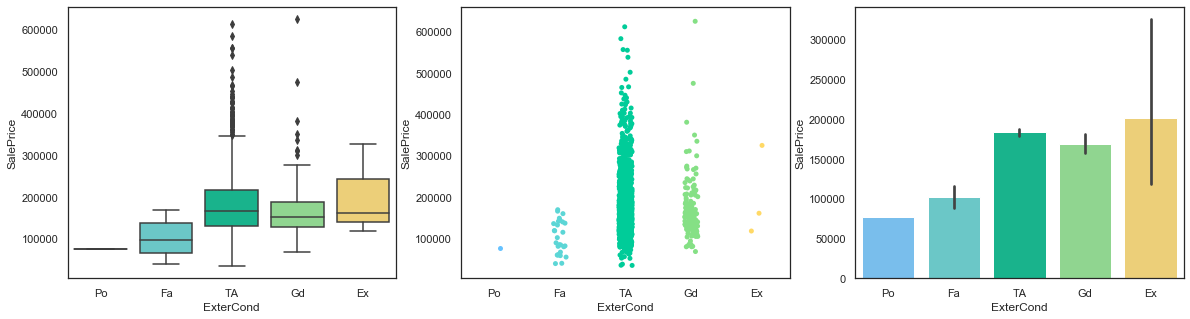

In [88]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="ExterCond", y="SalePrice", data=train, order=['Po','Fa','TA','Gd', 'Ex'], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="ExterCond", y="SalePrice", data=train, size = 5, jitter = True, order=['Po','Fa','TA','Gd', 'Ex'], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="ExterCond", y="SalePrice", data=train, order=['Po','Fa','TA','Gd', 'Ex'], palette = mycols);

Интересно, что мы видим самые большие значения SalePrice для второго и третьего лучших классов. Возможно, это связано с большой частотой значений внутри этих классов, в то время как мы видим только 3 наблюдения внутри "Ex" из учебных данных.
Так как эта категорическая особенность имеет порядок, но три SalePrice не обязательно коррелируют с этим порядком.... Я создам фиктивные переменные.

In [89]:

all_data = pd.get_dummies(all_data, columns = ["ExterCond"], prefix="ExterCond")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  Exterior1st_WdShing  \
0       Norm       Norm      SBrkr  ...                    0   
1      Feedr       Norm      SBrkr  ...                    0   
2       Norm       Norm      SBrkr  ...                    0   

   MasVnrType_BrkCmn MasVnrType_BrkFace  MasVnrType_None  MasVnrType_Stone  \
0                  0                  1                0                 0   
1                  0                  0                1                 0   
2                  0                  1                0                 0   

   ExterCond_Ex  ExterCond_Fa  ExterCond_Gd ExterCond_Po ExterCond_TA  
0             0             0             0            0            1  
1             0             0             0            0            1  
2             0             0             0            0            1  

[3 rows x 225 columns]

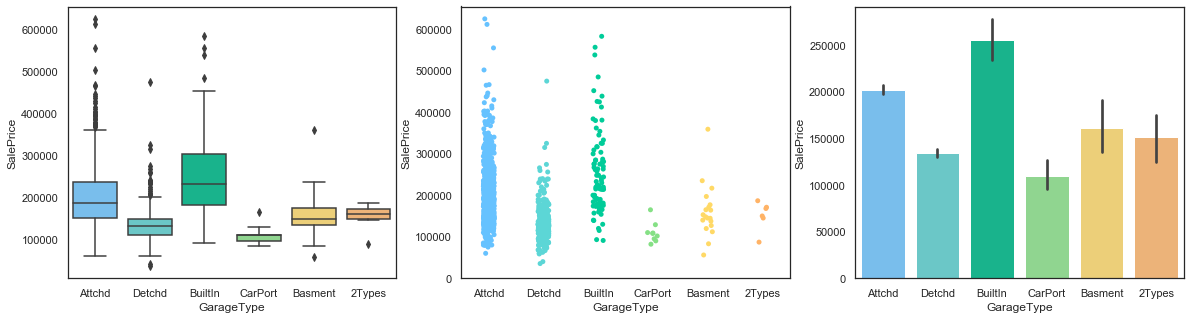

In [90]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageType", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageType", y="SalePrice", data=train, palette = mycols);

Здесь мы видим "BuiltIn" и "Attched" с 2 самыми высокими средними SalePrices, с небольшим количеством экстремальных значений в каждом классе.
Так как это категорично без порядка, я создам фиктивные переменные.

In [91]:
all_data = pd.get_dummies(all_data, columns = ["GarageType"], prefix="GarageType")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  ExterCond_Gd  ExterCond_Po  \
0       Norm       Norm      SBrkr  ...             0             0   
1      Feedr       Norm      SBrkr  ...             0             0   
2       Norm       Norm      SBrkr  ...             0             0   

  ExterCond_TA  GarageType_2Types  GarageType_Attchd  GarageType_Basment  \
0            1                  0                  1                   0   
1            1                  0                  1                   0   
2            1                  0                  1                   0   

   GarageType_BuiltIn  GarageType_CarPort GarageType_Detchd GarageType_None  
0                   0                   0                 0               0  
1                   0                   0                 0               0  
2                   0                   0                 0               0  

[3 rows x 231 columns]

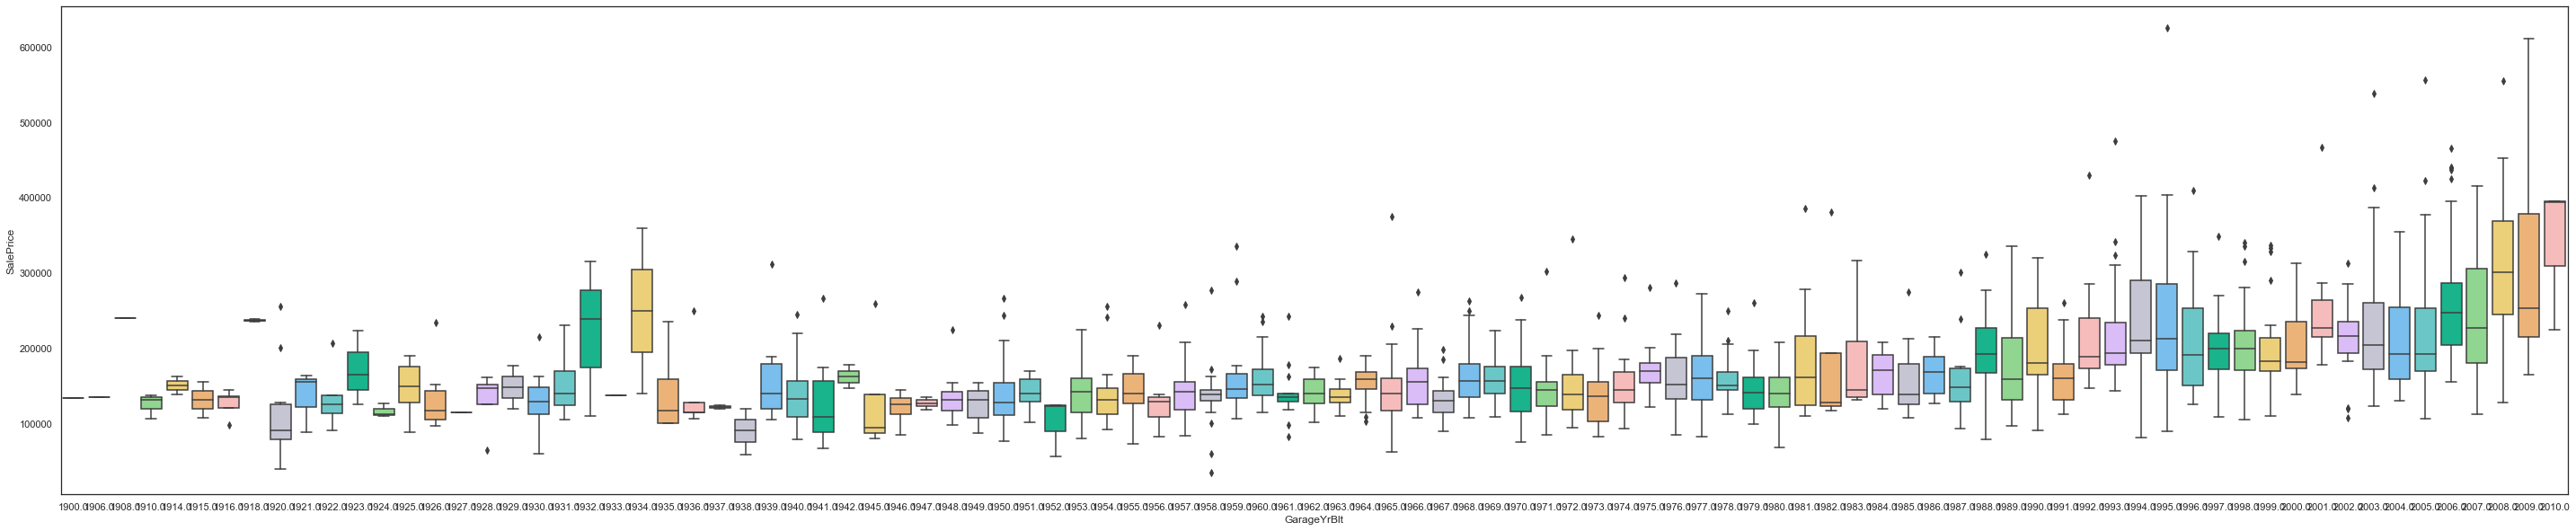

In [92]:
plt.subplots(figsize =(50, 10))

sns.boxplot(x="GarageYrBlt", y="SalePrice", data=train, palette = mycols);

По мере того, как год постройки гаражей становится все более современным, мы видим тенденцию к небольшому росту.
Для этой функции я собираюсь создать мусорные баки и фиктивные переменные.

In [93]:
all_data['GarageYrBlt_Band'] = pd.qcut(all_data['GarageYrBlt'], 3)
all_data['GarageYrBlt_Band'].unique()

[(1996.0, 2207.0], (1964.0, 1996.0], (-0.001, 1964.0]]
Categories (3, interval[float64]): [(-0.001, 1964.0] < (1964.0, 1996.0] < (1996.0, 2207.0]]

In [94]:
all_data.loc[all_data['GarageYrBlt']<=1964, 'GarageYrBlt'] = 1
all_data.loc[(all_data['GarageYrBlt']>1964) & (all_data['GarageYrBlt']<=1996), 'GarageYrBlt'] = 2
all_data.loc[all_data['GarageYrBlt']>1996, 'GarageYrBlt'] = 3
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(int)

all_data.drop('GarageYrBlt_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GarageYrBlt"], prefix="GarageYrBlt")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  GarageType_2Types  GarageType_Attchd  \
0       Norm       Norm      SBrkr  ...                  0                  1   
1      Feedr       Norm      SBrkr  ...                  0                  1   
2       Norm       Norm      SBrkr  ...                  0                  1   

  GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  \
0                  0                   0                   0   
1                  0                   0                   0   
2                  0                   0                   0   

   GarageType_Detchd  GarageType_None  GarageYrBlt_1 GarageYrBlt_2  \
0                  0                0              0             0   
1                  0                0              0             1   
2                  0                0              0             0   

  GarageYrBlt_3  
0             1  
1             0  
2             1  

[3 rows x 233 columns]

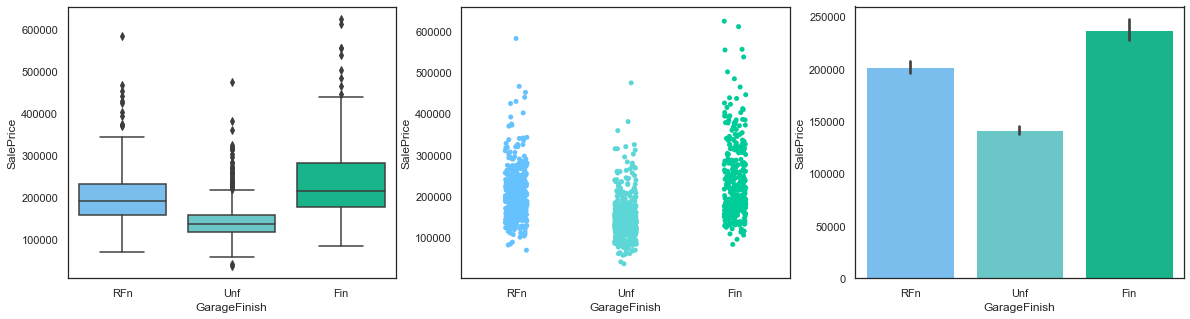

In [95]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageFinish", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageFinish", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageFinish", y="SalePrice", data=train, palette = mycols);

Здесь мы видим хорошее деление между 3 классами, с "Фин" производит в среднем самые высокие SalePrice's.
Я создам фиктивные переменные для этой функции.

In [96]:
all_data = pd.get_dummies(all_data, columns = ["GarageFinish"], prefix="GarageFinish")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  GarageType_CarPort  \
0       Norm       Norm      SBrkr  ...                   0   
1      Feedr       Norm      SBrkr  ...                   0   
2       Norm       Norm      SBrkr  ...                   0   

   GarageType_Detchd GarageType_None  GarageYrBlt_1  GarageYrBlt_2  \
0                  0               0              0              0   
1                  0               0              0              1   
2                  0               0              0              0   

   GarageYrBlt_3  GarageFinish_Fin  GarageFinish_None GarageFinish_RFn  \
0              1                 0                  0                1   
1              0                 0                  0                1   
2              1                 0                  0                1   

  GarageFinish_Unf  
0                0  
1                0  
2                0  

[3 rows x 236 columns]

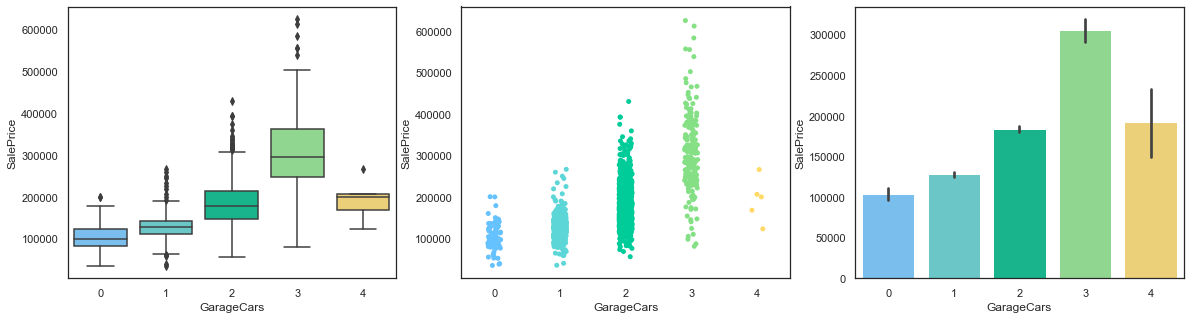

In [97]:

plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageCars", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageCars", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageCars", y="SalePrice", data=train, palette = mycols);

В целом мы видим положительную корреляцию с увеличением вместимости гаражных вагонов. Тем не менее, мы видим небольшое падение на 4 автомобиля, я полагаю, из-за низкой частоты домов с гаражом на 4 автомобиля.

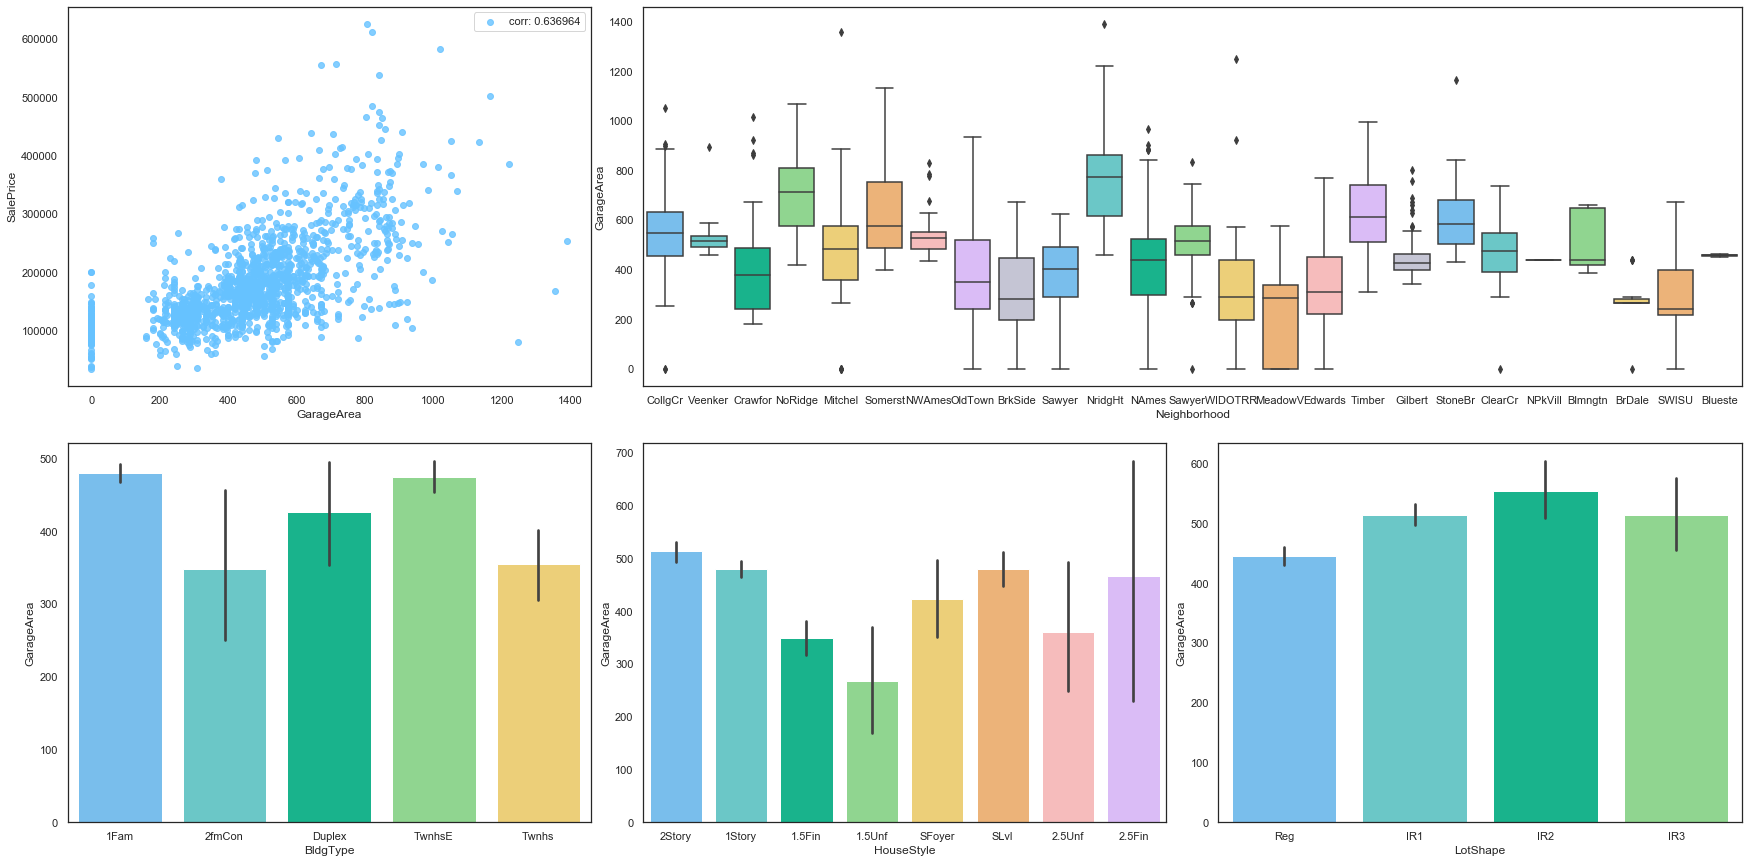

In [98]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['GarageArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['GarageArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="GarageArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="GarageArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="GarageArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="GarageArea", data=train, palette = mycols);

Это имеет чрезвычайно высокую положительную корреляцию с SalePrice, и сильно зависит от района, типа здания и стиля дома.
Это может быть важной функцией при анализе, поэтому я буду выстраивать эту функцию в бинарный список и создавать фиктивные переменные.

In [99]:
all_data['GarageArea_Band'] = pd.cut(all_data['GarageArea'], 3)
all_data['GarageArea_Band'].unique()

[(496.0, 992.0], (-1.488, 496.0], (992.0, 1488.0]]
Categories (3, interval[float64]): [(-1.488, 496.0] < (496.0, 992.0] < (992.0, 1488.0]]

In [100]:
all_data.loc[all_data['GarageArea']<=496, 'GarageArea'] = 1
all_data.loc[(all_data['GarageArea']>496) & (all_data['GarageArea']<=992), 'GarageArea'] = 2
all_data.loc[all_data['GarageArea']>992, 'GarageArea'] = 3
all_data['GarageArea'] = all_data['GarageArea'].astype(int)

all_data.drop('GarageArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GarageArea"], prefix="GarageArea")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  GarageYrBlt_1  GarageYrBlt_2  \
0       Norm       Norm      SBrkr  ...              0              0   
1      Feedr       Norm      SBrkr  ...              0              1   
2       Norm       Norm      SBrkr  ...              0              0   

  GarageYrBlt_3  GarageFinish_Fin  GarageFinish_None  GarageFinish_RFn  \
0             1                 0                  0                 1   
1             0                 0                  0                 1   
2             1                 0                  0                 1   

   GarageFinish_Unf GarageArea_1 GarageArea_2 GarageArea_3  
0                 0            0            1            0  
1                 0            1            0            0  
2                 0            0            1            0  

[3 rows x 238 columns]

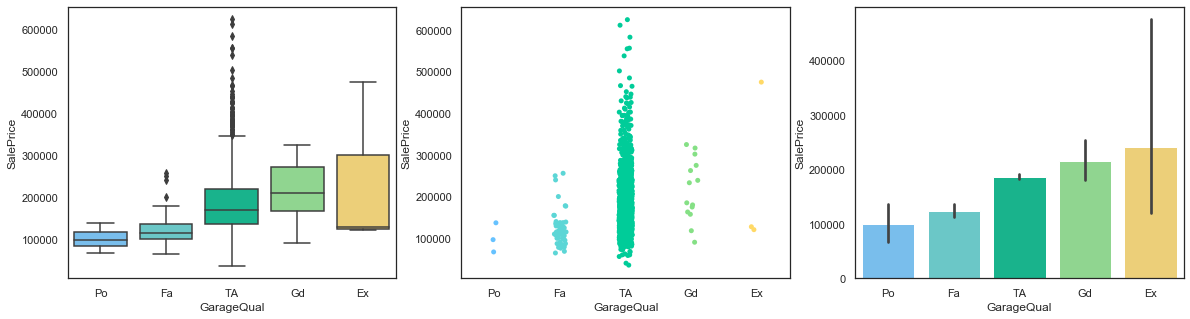

In [101]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageQual", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageQual", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageQual", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

Мы видим много домов, имеющих качественные гаражи "TA", и очень мало домов, имеющих качественные и низкокачественные.
Здесь я собираюсь сконцентрировать классы, а затем создать фиктивные переменные.

In [102]:
all_data['GarageQual'] = all_data['GarageQual'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data['GarageQual'].unique()

array(['TA', 'Low', 'High', 'None'], dtype=object)

In [103]:
all_data = pd.get_dummies(all_data, columns = ["GarageQual"], prefix="GarageQual")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  GarageFinish_None  GarageFinish_RFn  \
0       Norm       Norm      SBrkr  ...                  0                 1   
1      Feedr       Norm      SBrkr  ...                  0                 1   
2       Norm       Norm      SBrkr  ...                  0                 1   

  GarageFinish_Unf  GarageArea_1  GarageArea_2  GarageArea_3  GarageQual_High  \
0                0             0             1             0                0   
1                0             1             0             0                0   
2                0             0             1             0                0   

  GarageQual_Low GarageQual_None GarageQual_TA  
0              0               0             1  
1              0               0             1  
2              0               0             1  

[3 rows x 241 columns]

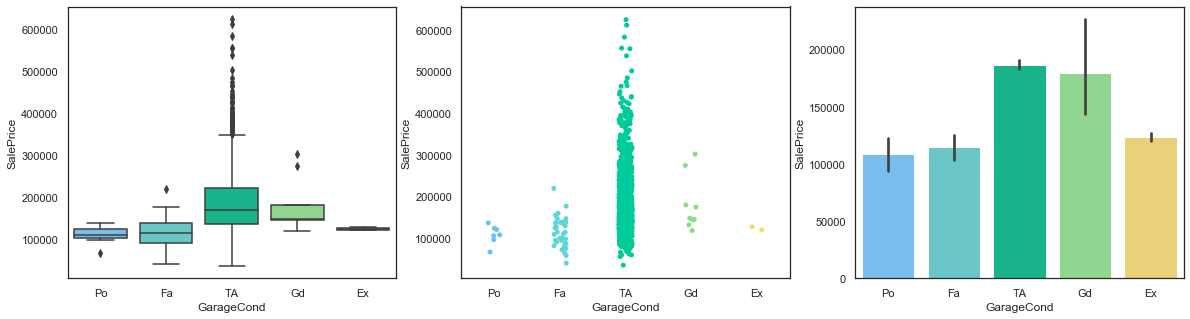

In [104]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageCond", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageCond", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageCond", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

Здесь мы видим довольно похожую картину с предыдущей функцией. Мы видим небольшую положительную корреляцию, а затем падение, я полагаю, в связи с небольшим количеством домов, имеющих "Ex" или "Gd" гаражные условия. 
Как и раньше, я собираюсь собраться в кластеры, а затем манекенировать эту особенность.

In [105]:
all_data['GarageCond'] = all_data['GarageCond'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data['GarageCond'].unique()

array(['TA', 'Low', 'None', 'High'], dtype=object)

In [106]:
all_data = pd.get_dummies(all_data, columns = ["GarageCond"], prefix="GarageCond")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  GarageArea_2  GarageArea_3  \
0       Norm       Norm      SBrkr  ...             1             0   
1      Feedr       Norm      SBrkr  ...             0             0   
2       Norm       Norm      SBrkr  ...             1             0   

  GarageQual_High  GarageQual_Low  GarageQual_None  GarageQual_TA  \
0               0               0                0              1   
1               0               0                0              1   
2               0               0                0              1   

   GarageCond_High GarageCond_Low GarageCond_None  GarageCond_TA  
0                0              0               0              1  
1                0              0               0              1  
2                0              0               0              1  

[3 rows x 244 columns]

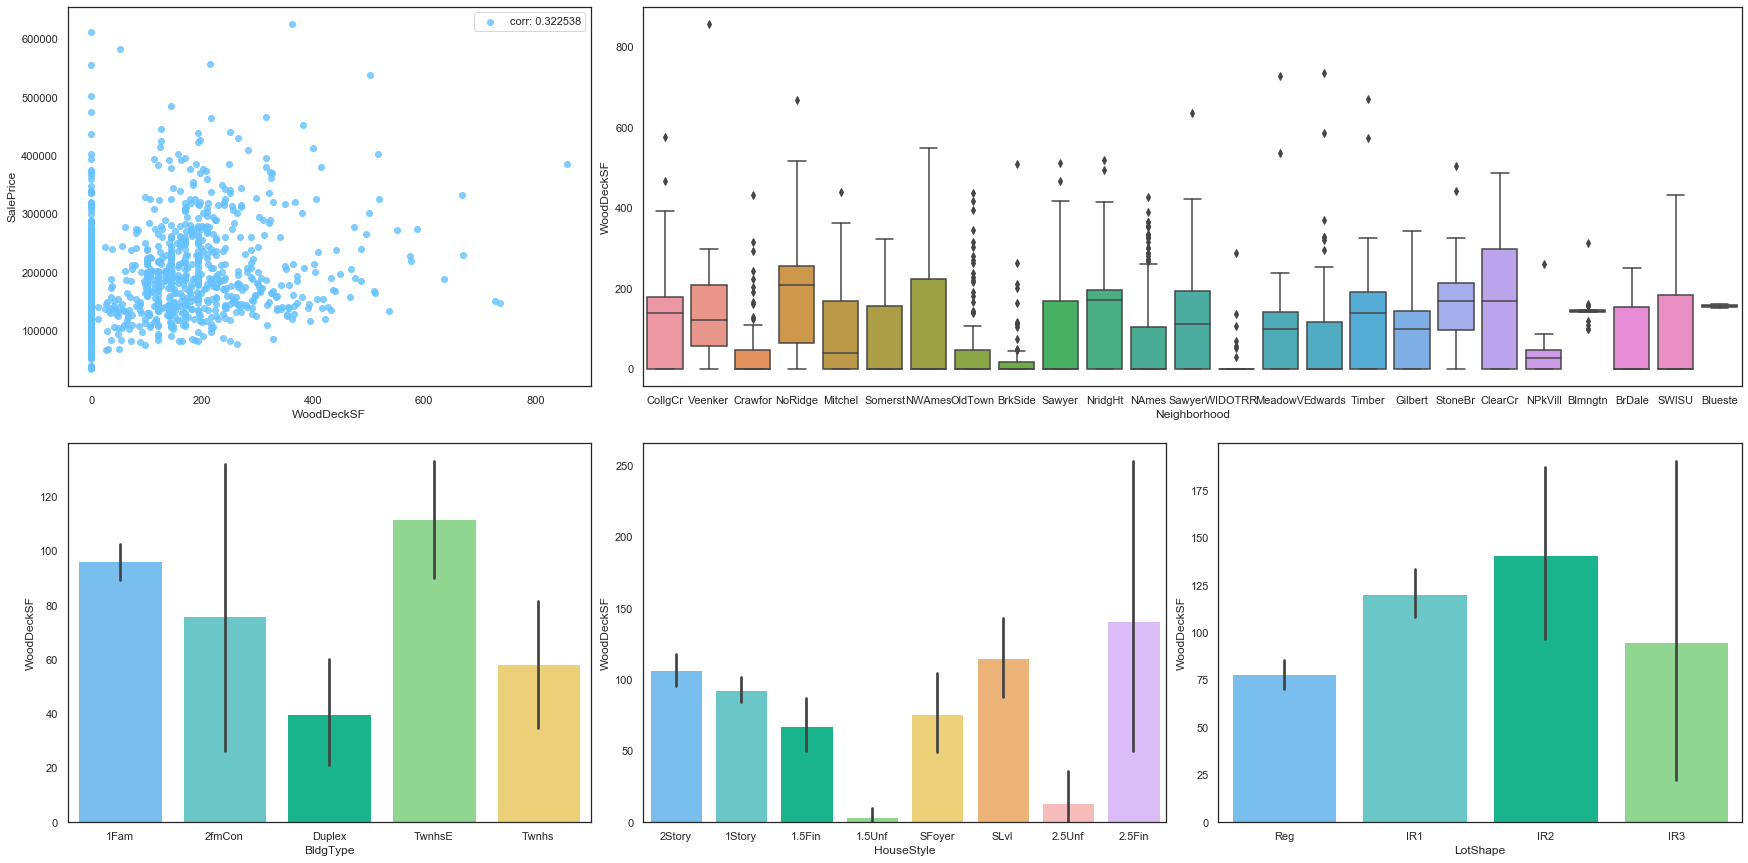

In [107]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['WoodDeckSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['WoodDeckSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="WoodDeckSF", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="WoodDeckSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="WoodDeckSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="WoodDeckSF", data=train, palette = mycols);

Эта особенность имеет высокую положительную корреляцию с SalePrice.
Мы также видим, что она сильно варьируется в зависимости от местоположения, типа здания, стиля и размера лота.
Существует значительное количество точек данных со значением 0, поэтому я создам флаг, указывающий на отсутствие деревянной палубы. Затем, так как это непрерывная числовая функция, и я считаю ее важной, я создам бинокль этой функции, а затем создам фиктивные функции.

In [108]:

def WoodDeckFlag(col):
    if col['WoodDeckSF'] == 0:
        return 1
    else:
        return 0
    
all_data['NoWoodDeck_Flag'] = all_data.apply(WoodDeckFlag, axis=1)

all_data['WoodDeckSF_Band'] = pd.cut(all_data['WoodDeckSF'], 4)

all_data.loc[all_data['WoodDeckSF']<=356, 'WoodDeckSF'] = 1
all_data.loc[(all_data['WoodDeckSF']>356) & (all_data['WoodDeckSF']<=712), 'WoodDeckSF'] = 2
all_data.loc[(all_data['WoodDeckSF']>712) & (all_data['WoodDeckSF']<=1068), 'WoodDeckSF'] = 3
all_data.loc[all_data['WoodDeckSF']>1068, 'WoodDeckSF'] = 4
all_data['WoodDeckSF'] = all_data['WoodDeckSF'].astype(int)

all_data.drop('WoodDeckSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["WoodDeckSF"], prefix="WoodDeckSF")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  GarageQual_TA  GarageCond_High  \
0       Norm       Norm      SBrkr  ...              1                0   
1      Feedr       Norm      SBrkr  ...              1                0   
2       Norm       Norm      SBrkr  ...              1                0   

  GarageCond_Low  GarageCond_None  GarageCond_TA  NoWoodDeck_Flag  \
0              0                0              1                1   
1              0                0              1                0   
2              0                0              1                1   

   WoodDeckSF_1 WoodDeckSF_2 WoodDeckSF_3  WoodDeckSF_4  
0             1            0            0             0  
1             1            0            0             0  
2             1            0            0             0  

[3 rows x 248 columns]

In [109]:
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch'] 
train['TotalPorchSF'] = train['OpenPorchSF'] + train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

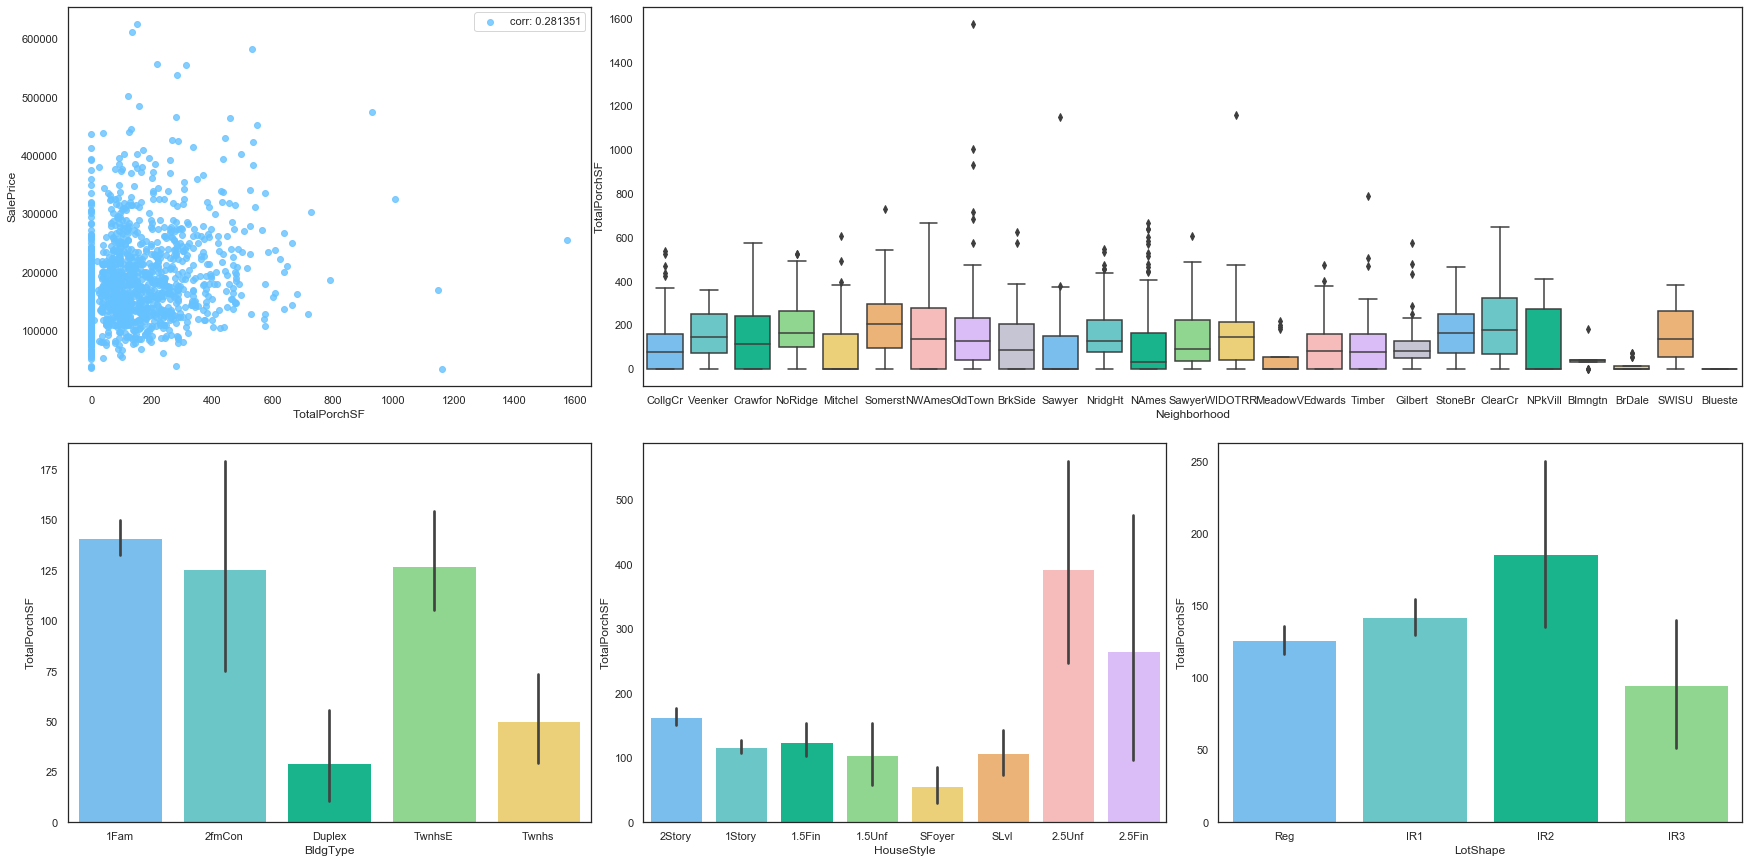

In [110]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['TotalPorchSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['TotalPorchSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="TotalPorchSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="TotalPorchSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="TotalPorchSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="TotalPorchSF", data=train, palette = mycols);

Здесь мы снова видим большое количество точек данных, имеющих значение 0.
Кроме того, мы видим высокую положительную корреляцию с SalePrice, показывающую, что это может быть влиятельным фактором для анализа.
Наконец, мы видим, что это значение широко варьируется в зависимости от местоположения, типа здания, стиля и лота.
Я создам флаг, указывающий на отсутствие открытого крыльца, затем создам бинокль функции и создадим фиктивные переменные.

In [111]:
def PorchFlag(col):
    if col['TotalPorchSF'] == 0:
        return 1
    else:
        return 0
    
all_data['NoPorch_Flag'] = all_data.apply(PorchFlag, axis=1)

all_data['TotalPorchSF_Band'] = pd.cut(all_data['TotalPorchSF'], 4)
all_data['TotalPorchSF_Band'].unique()

[(-1.724, 431.0], (431.0, 862.0], (862.0, 1293.0], (1293.0, 1724.0]]
Categories (4, interval[float64]): [(-1.724, 431.0] < (431.0, 862.0] < (862.0, 1293.0] < (1293.0, 1724.0]]

In [112]:
all_data.loc[all_data['TotalPorchSF']<=431, 'TotalPorchSF'] = 1
all_data.loc[(all_data['TotalPorchSF']>431) & (all_data['TotalPorchSF']<=862), 'TotalPorchSF'] = 2
all_data.loc[(all_data['TotalPorchSF']>862) & (all_data['TotalPorchSF']<=1293), 'TotalPorchSF'] = 3
all_data.loc[all_data['TotalPorchSF']>1293, 'TotalPorchSF'] = 4
all_data['TotalPorchSF'] = all_data['TotalPorchSF'].astype(int)

all_data.drop('TotalPorchSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["TotalPorchSF"], prefix="TotalPorchSF")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  NoWoodDeck_Flag  WoodDeckSF_1  \
0       Norm       Norm      SBrkr  ...                1             1   
1      Feedr       Norm      SBrkr  ...                0             1   
2       Norm       Norm      SBrkr  ...                1             1   

  WoodDeckSF_2  WoodDeckSF_3  WoodDeckSF_4  NoPorch_Flag  TotalPorchSF_1  \
0            0             0             0             0               1   
1            0             0             0             1               1   
2            0             0             0             0               1   

  TotalPorchSF_2 TotalPorchSF_3  TotalPorchSF_4  
0              0              0               0  
1              0              0               0  
2              0              0               0  

[3 rows x 253 columns]

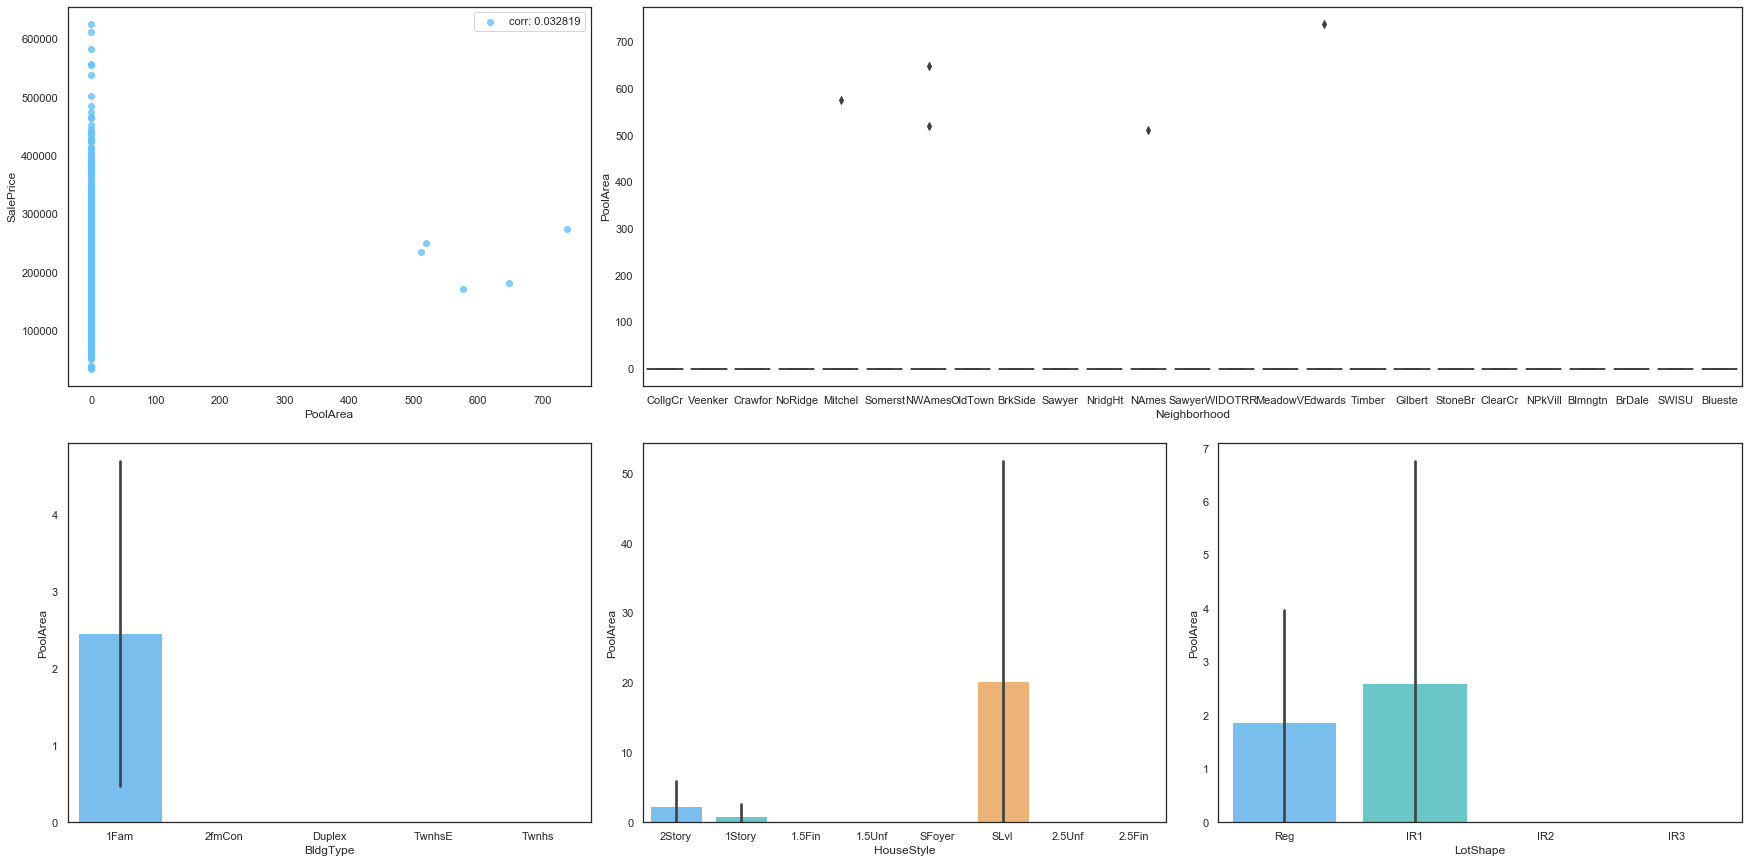

In [113]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['PoolArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['PoolArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="PoolArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="PoolArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="PoolArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="PoolArea", data=train, palette = mycols);

Мы видим почти 0 корреляцию из-за большого количества домов без бассейна.
Следовательно, я создам здесь флаг.

In [114]:
def PoolFlag(col):
    if col['PoolArea'] == 0:
        return 0
    else:
        return 1
    
all_data['HasPool_Flag'] = all_data.apply(PoolFlag, axis=1)
all_data.drop('PoolArea', axis=1, inplace=True)

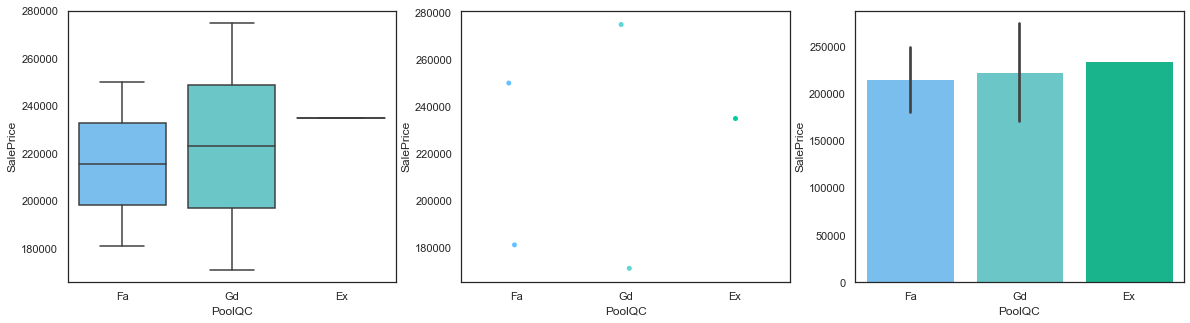

In [115]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="PoolQC", y="SalePrice", data=train, order=["Fa", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="PoolQC", y="SalePrice", data=train, size = 5, jitter = True, order=["Fa", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="PoolQC", y="SalePrice", data=train, order=["Fa", "Gd", "Ex"], palette = mycols);

В связи с тем, что не так много домов имеют бассейн, мы видим очень мало наблюдений для каждого класса.
Так как в нем не так много информации, я просто удалю его.

In [116]:
all_data.drop('PoolQC', axis=1, inplace=True)

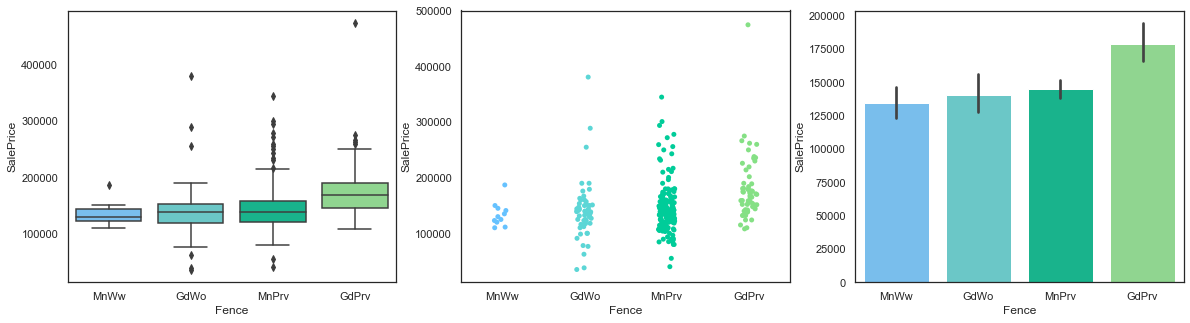

In [117]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Fence", y="SalePrice", data=train, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Fence", y="SalePrice", data=train, size = 5, jitter = True, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Fence", y="SalePrice", data=train, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"], palette = mycols);

Здесь мы видим, что дома с наибольшим уединением имеют самый высокий средний SalePrice.
Кажется, что внутри классов есть небольшой порядок, однако некоторые описания классов немного неоднозначны, поэтому здесь я создам фиктивные переменные из этой категоричной особенности

In [118]:
all_data = pd.get_dummies(all_data, columns = ["Fence"], prefix="Fence")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  TotalPorchSF_1  TotalPorchSF_2  \
0       Norm       Norm      SBrkr  ...               1               0   
1      Feedr       Norm      SBrkr  ...               1               0   
2       Norm       Norm      SBrkr  ...               1               0   

   TotalPorchSF_3  TotalPorchSF_4  HasPool_Flag  Fence_GdPrv Fence_GdWo  \
0               0               0             0            0          0   
1               0               0             0            0          0   
2               0               0             0            0          0   

  Fence_MnPrv  Fence_MnWw  Fence_None  
0           0           0           1  
1           0           0           1  
2           0           0           1  

[3 rows x 256 columns]

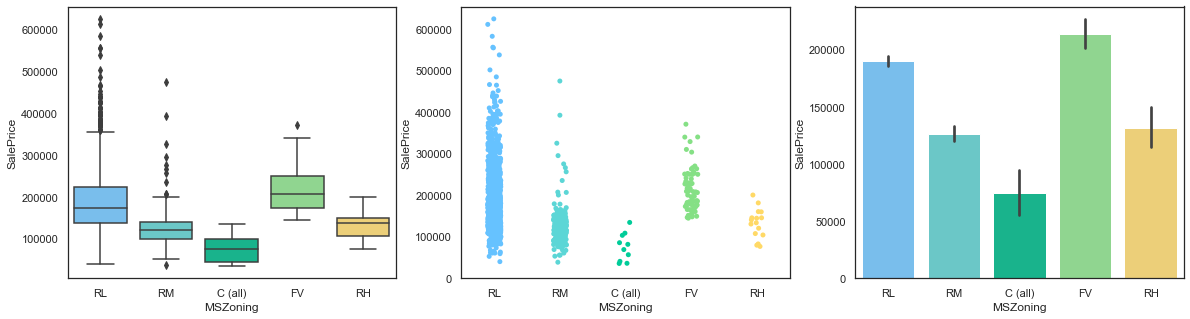

In [119]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MSZoning", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="MSZoning", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MSZoning", y="SalePrice", data=train, palette = mycols);

Так как это категорическая функция без порядка, и каждый из классов имеет очень разный диапазон и средний для SalePrice, я создам здесь функции манекена.

In [120]:
all_data = pd.get_dummies(all_data, columns = ["MSZoning"], prefix="MSZoning")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  Fence_GdPrv  Fence_GdWo  Fence_MnPrv  \
0       Norm       Norm      SBrkr  ...            0           0            0   
1      Feedr       Norm      SBrkr  ...            0           0            0   
2       Norm       Norm      SBrkr  ...            0           0            0   

   Fence_MnWw  Fence_None  MSZoning_C (all) MSZoning_FV MSZoning_RH  \
0           0           1                 0           0           0   
1           0           1                 0           0           0   
2           0           1                 0           0           0   

   MSZoning_RL  MSZoning_RM  
0            1            0  
1            1            0  
2            1            0  

[3 rows x 260 columns]

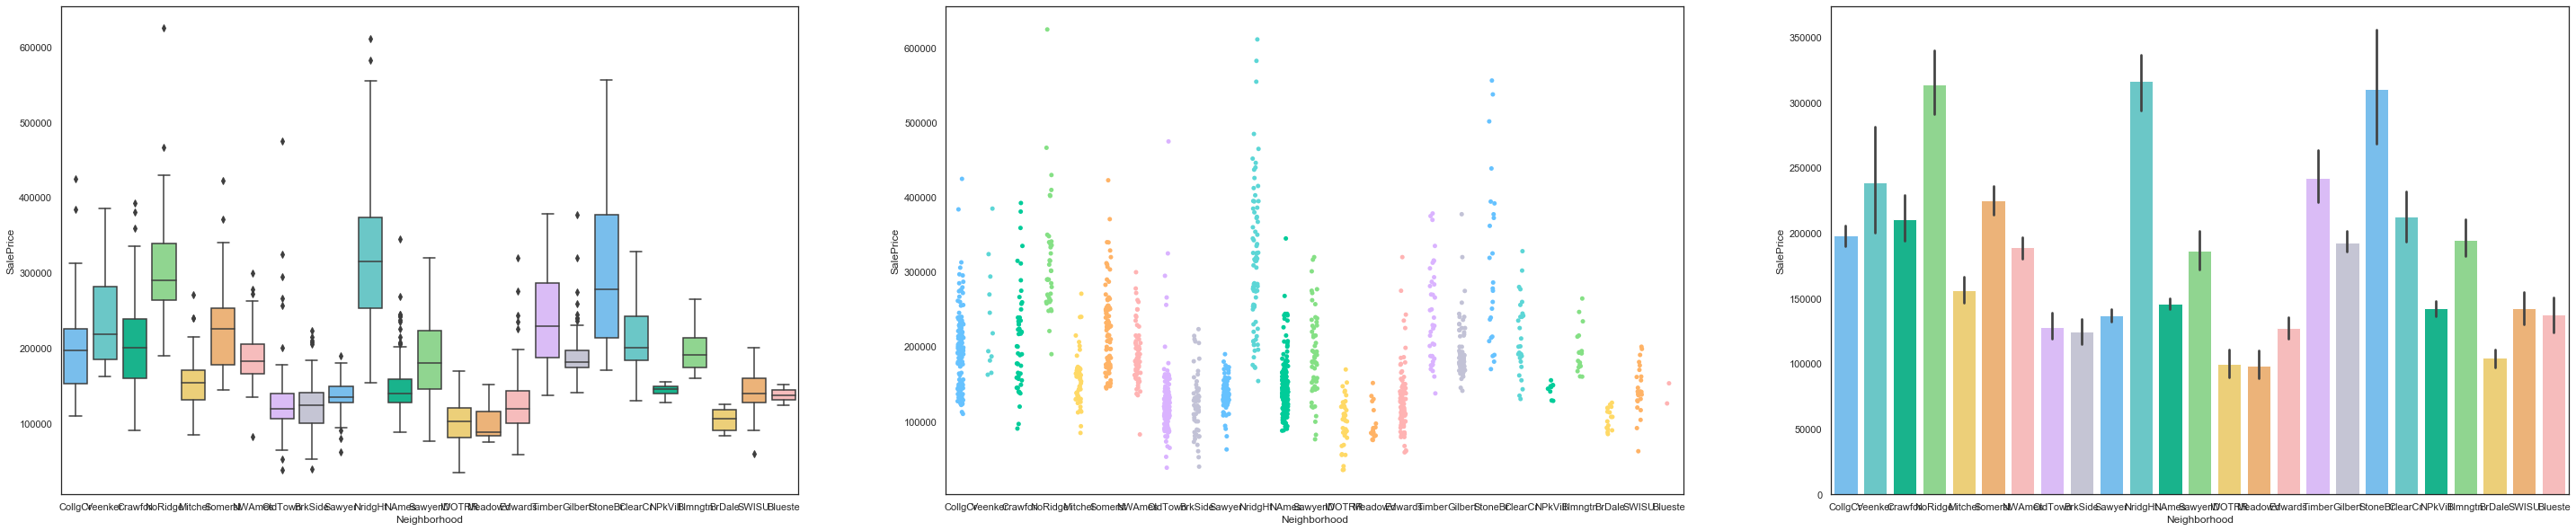

In [121]:
plt.subplots(figsize =(50, 10))

plt.subplot(1, 3, 1)
sns.boxplot(x="Neighborhood", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Neighborhood", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Neighborhood", y="SalePrice", data=train, palette = mycols);

Соседство, безусловно, имеет важный вклад в SalePrice, так как мы видим такие высокие значения для одних районов и низкие значения для других.
Так как это категорическая характеристика без порядка, я создам фиктивные характеристики.

In [122]:
all_data = pd.get_dummies(all_data, columns = ["Neighborhood"], prefix="Neighborhood")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical  ...  Neighborhood_NoRidge  \
0       Norm       Norm      SBrkr  ...                     0   
1      Feedr       Norm      SBrkr  ...                     0   
2       Norm       Norm      SBrkr  ...                     0   

   Neighborhood_NridgHt  Neighborhood_OldTown  Neighborhood_SWISU  \
0                     0                     0                   0   
1                     0                     0                   0   
2                     0                     0                   0   

   Neighborhood_Sawyer  Neighborhood_SawyerW Neighborhood_Somerst  \
0                    0                     0                    0   
1                    0                     0                    0   
2                    0                     0                    0   

  Neighborhood_StoneBr  Neighborhood_Timber  Neighborhood_Veenker  
0                    0                    0                     0  
1                    0                    0                     1  
2                    0                    0                     0  

[3 rows x 284 columns]

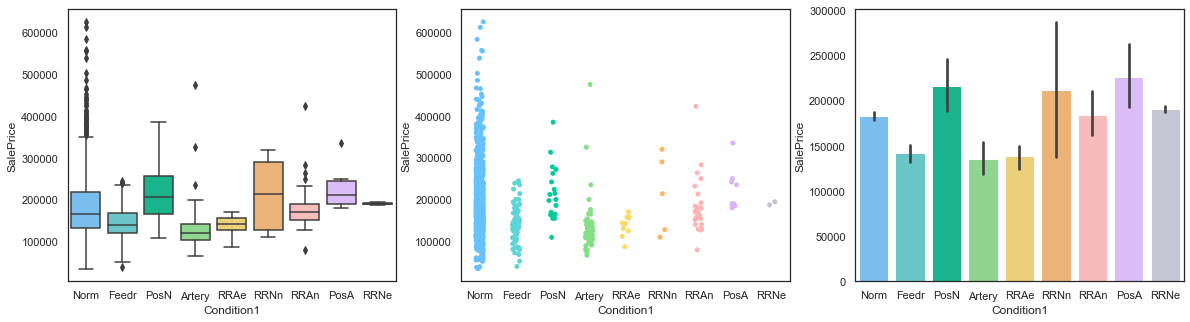

In [123]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Condition1", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Condition1", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Condition1", y="SalePrice", data=train, palette = mycols);

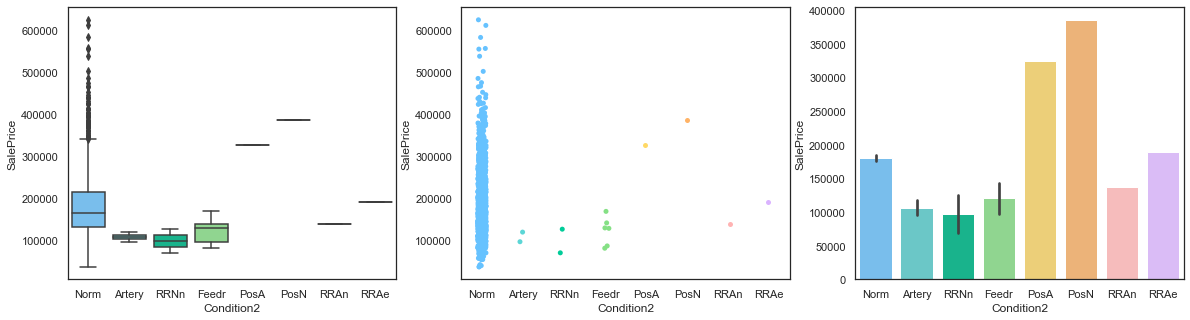

In [124]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Condition2", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Condition2", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Condition2", y="SalePrice", data=train, palette = mycols);

Так как эта функция основана на местных особенностях, понятно, что наличие более желательных вещей, таких как парки... поблизости, является фактором, который будет способствовать более высокой SalePrice. 
Для этой функции я собираюсь сконцентрировать классы, основанные на описании класса. Затем, я создам фиктивные функции. 
Затем я опущу "Condition2" после создания флага, чтобы указать, является ли условие, отличное от первого поблизости.

In [125]:
all_data['Condition1'] = all_data['Condition1'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
all_data['Condition2'] = all_data['Condition2'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})

In [126]:
def ConditionMatch(col):
    if col['Condition1'] == col['Condition2']:
        return 0
    else:
        return 1
    
all_data['Diff2ndCondition_Flag'] = all_data.apply(ConditionMatch, axis=1)
all_data.drop('Condition2', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["Condition1"], prefix="Condition1")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  ...  Neighborhood_SawyerW  \
0      SBrkr              0          3  ...                     0   
1      SBrkr              0          2  ...                     0   
2      SBrkr              0          3  ...                     0   

   Neighborhood_Somerst  Neighborhood_StoneBr  Neighborhood_Timber  \
0                     0                     0                    0   
1                     0                     0                    0   
2                     0                     0                    0   

  Neighborhood_Veenker Diff2ndCondition_Flag  Condition1_Norm  Condition1_Pos  \
0                    0                     0                1               0   
1                    1                     1                0               0   
2                    0                     0                1               0   

  Condition1_Street Condition1_Train  
0                 0                0  
1                 1                0  
2                 0                0  

[3 rows x 287 columns]

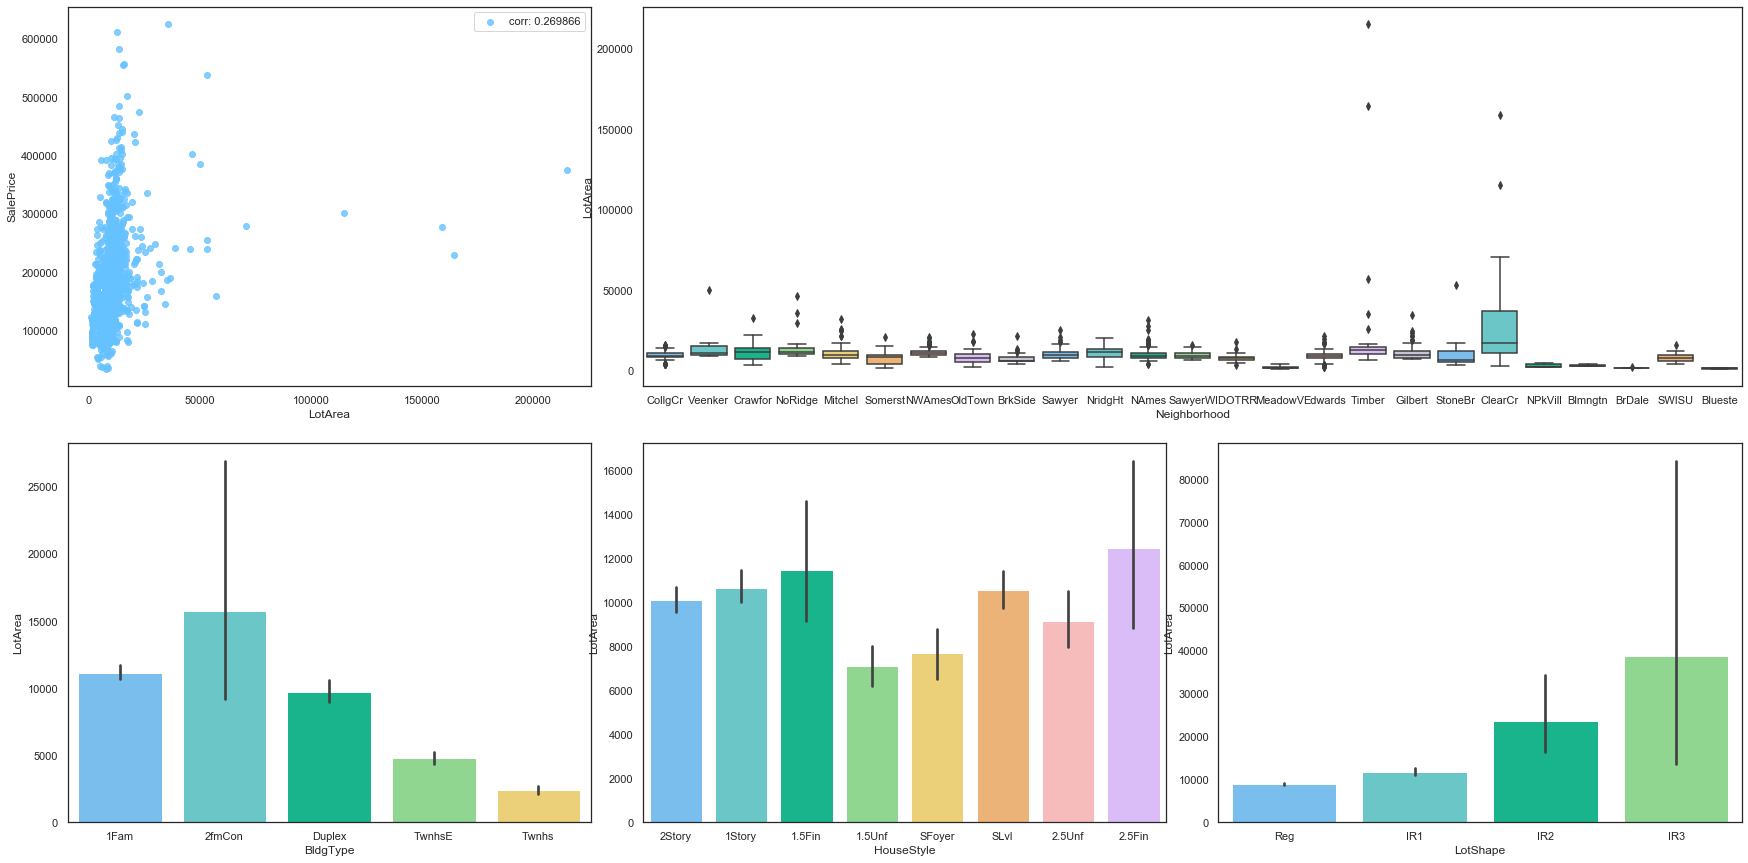

In [127]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['LotArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['LotArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="LotArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="LotArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="LotArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="LotArea", data=train, palette = mycols);

Эта особенность показывает высокую корреляцию, но она очень позитивно искажена. 
Поэтому я создам квантильные бункеры и манекены. Квантильные бункеры не основываются на приблизительно одинаковых по размеру бункетах, вместо этого создаются бункеты с одинаковой частотой точек данных внутри каждого бункета.

In [128]:
all_data['LotArea_Band'] = pd.qcut(all_data['LotArea'], 8)
all_data['LotArea_Band'].unique()

[(7474.0, 8520.0], (9450.0, 10355.25], (10355.25, 11554.5], (13613.0, 215245.0], (5684.75, 7474.0], (11554.5, 13613.0], (1299.999, 5684.75], (8520.0, 9450.0]]
Categories (8, interval[float64]): [(1299.999, 5684.75] < (5684.75, 7474.0] < (7474.0, 8520.0] < (8520.0, 9450.0] < (9450.0, 10355.25] < (10355.25, 11554.5] < (11554.5, 13613.0] < (13613.0, 215245.0]]

In [129]:

all_data.loc[all_data['LotArea']<=5684.75, 'LotArea'] = 1
all_data.loc[(all_data['LotArea']>5684.75) & (all_data['LotArea']<=7474), 'LotArea'] = 2
all_data.loc[(all_data['LotArea']>7474) & (all_data['LotArea']<=8520), 'LotArea'] = 3
all_data.loc[(all_data['LotArea']>8520) & (all_data['LotArea']<=9450), 'LotArea'] = 4
all_data.loc[(all_data['LotArea']>9450) & (all_data['LotArea']<=10355.25), 'LotArea'] = 5
all_data.loc[(all_data['LotArea']>10355.25) & (all_data['LotArea']<=11554.25), 'LotArea'] = 6
all_data.loc[(all_data['LotArea']>11554.25) & (all_data['LotArea']<=13613), 'LotArea'] = 7
all_data.loc[all_data['LotArea']>13613, 'LotArea'] = 8
all_data['LotArea'] = all_data['LotArea'].astype(int)

all_data.drop('LotArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["LotArea"], prefix="LotArea")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  ...  Condition1_Street  \
0      SBrkr              0          3  ...                  0   
1      SBrkr              0          2  ...                  1   
2      SBrkr              0          3  ...                  0   

   Condition1_Train  LotArea_1  LotArea_2 LotArea_3 LotArea_4  LotArea_5  \
0                 0          0          0         1         0          0   
1                 0          0          0         0         0          1   
2                 0          0          0         0         0          0   

   LotArea_6 LotArea_7 LotArea_8  
0          0         0         0  
1          0         0         0  
2          1         0         0  

[3 rows x 294 columns]

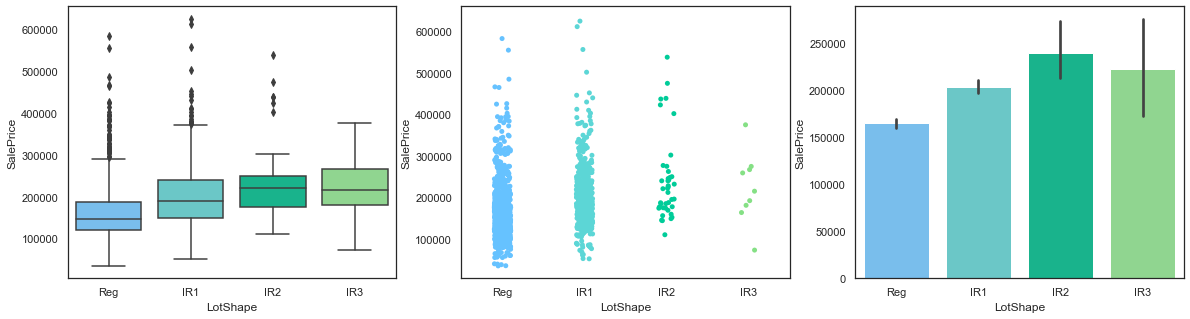

In [130]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LotShape", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LotShape", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LotShape", y="SalePrice", data=train, palette = mycols);

Очевидно, что мы видим некоторые экстремальные значения для некоторых категорий и разные SalePrice для разных классов.
"Reg" и "IR1" имеют самую высокую частоту точек данных внутри них.
Так как это категорическая функция без порядка, я создам фиктивные функции.

In [131]:
all_data = pd.get_dummies(all_data, columns = ["LotShape"], prefix="LotShape")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  ...  LotArea_3  LotArea_4  LotArea_5  \
0      SBrkr              0          3  ...          1          0          0   
1      SBrkr              0          2  ...          0          0          1   
2      SBrkr              0          3  ...          0          0          0   

   LotArea_6 LotArea_7 LotArea_8  LotShape_IR1  LotShape_IR2 LotShape_IR3  \
0          0         0         0             0             0            0   
1          0         0         0             0             0            0   
2          1         0         0             1             0            0   

  LotShape_Reg  
0            1  
1            1  
2            0  

[3 rows x 297 columns]

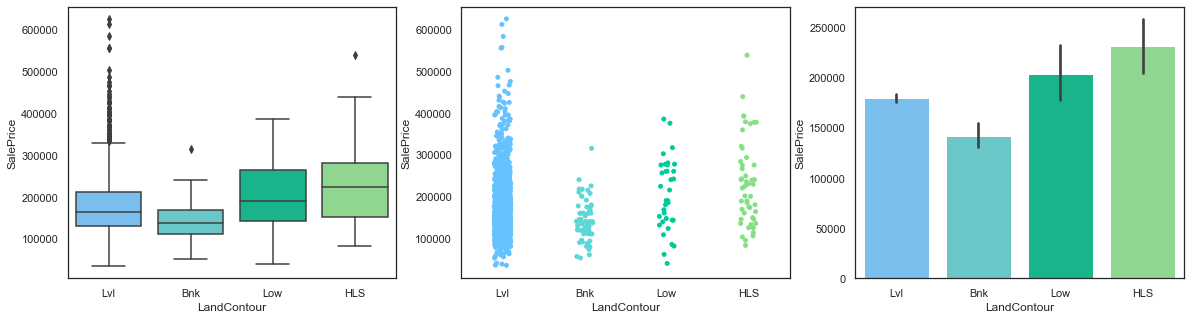

In [132]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LandContour", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LandContour", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LandContour", y="SalePrice", data=train, palette = mycols);

Большинство домов действительно находятся на плоском контуре, однако дома с самой высокой ценой SalePrice, кажется, приходят из свойств на холме интересно.
Так как это категорическая особенность без порядка, я создам фиктивные черты.

In [133]:
all_data = pd.get_dummies(all_data, columns = ["LandContour"], prefix="LandContour")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  ...  LotArea_7  LotArea_8  \
0      SBrkr              0          3  ...          0          0   
1      SBrkr              0          2  ...          0          0   
2      SBrkr              0          3  ...          0          0   

   LotShape_IR1  LotShape_IR2 LotShape_IR3 LotShape_Reg  LandContour_Bnk  \
0             0             0            0            1                0   
1             0             0            0            1                0   
2             1             0            0            0                0   

   LandContour_HLS LandContour_Low LandContour_Lvl  
0                0               0               1  
1                0               0               1  
2                0               0               1  

[3 rows x 300 columns]

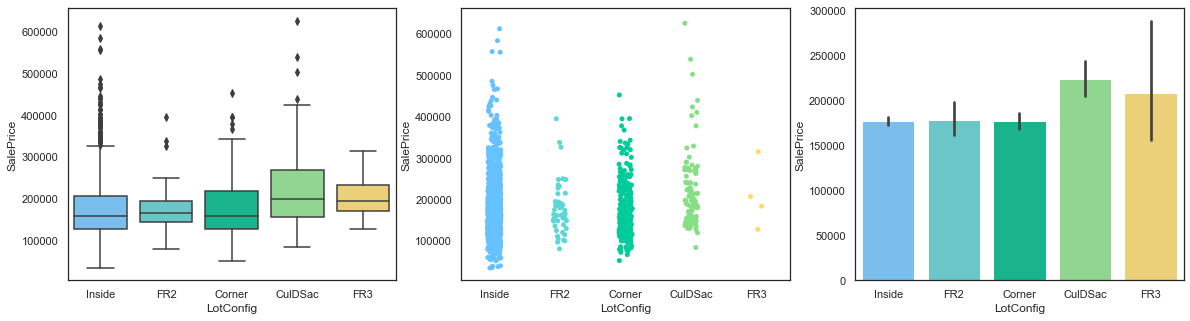

In [134]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LotConfig", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LotConfig", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LotConfig", y="SalePrice", data=train, palette = mycols);

Cul de sac, кажется, может похвастаться самыми высокими средними ценами внутри Эймса, однако большинство домов расположены внутри или на углу участка.
Чтобы упростить эту функцию, я буду кластера "FR2" и "FR3", а затем создать манекен функции.

In [135]:
all_data['LotConfig'] = all_data['LotConfig'].map({"Inside":"Inside", "FR2":"FR", "Corner":"Corner", "CulDSac":"CulDSac", "FR3":"FR"})

all_data = pd.get_dummies(all_data, columns = ["LotConfig"], prefix="LotConfig")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  ...  LotShape_IR3  LotShape_Reg  \
0      SBrkr              0          3  ...             0             1   
1      SBrkr              0          2  ...             0             1   
2      SBrkr              0          3  ...             0             0   

   LandContour_Bnk  LandContour_HLS LandContour_Low LandContour_Lvl  \
0                0                0               0               1   
1                0                0               0               1   
2                0                0               0               1   

   LotConfig_Corner  LotConfig_CulDSac LotConfig_FR  LotConfig_Inside  
0                 0                  0            0                 1  
1                 0                  0            1                 0  
2                 0                  0            0                 1  

[3 rows x 303 columns]

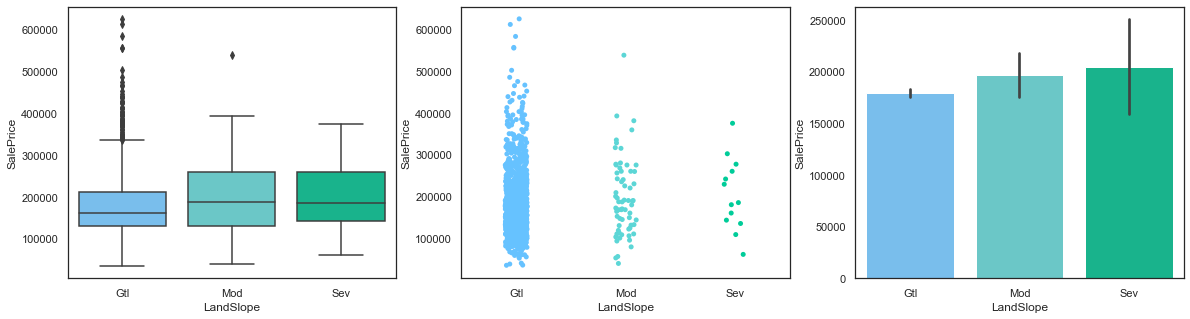

In [136]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LandSlope", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LandSlope", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LandSlope", y="SalePrice", data=train, palette = mycols);

Мы видим, что большинство домов имеют пологий склон земли и в целом, суровость склона, кажется, не оказывает большого влияния на SalePrice.
Следовательно, я собираюсь объединить "Mod" и "Sev", чтобы создать один класс, и создать новый флаг, указывающий на пологий склон или нет.

In [137]:
all_data['LandSlope'] = all_data['LandSlope'].map({"Gtl":1, "Mod":2, "Sev":2})

In [138]:
def Slope(col):
    if col['LandSlope'] == 1:
        return 1
    else:
        return 0
    
all_data['GentleSlope_Flag'] = all_data.apply(Slope, axis=1)
all_data.drop('LandSlope', axis=1, inplace=True)

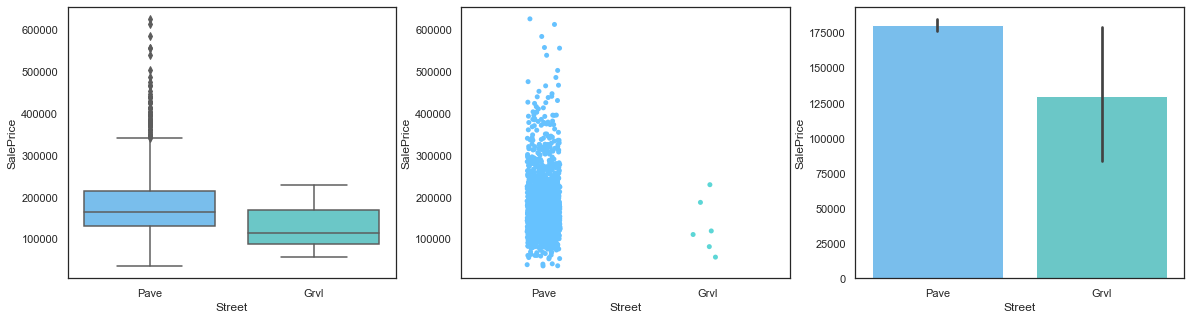

In [139]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Street", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Street", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Street", y="SalePrice", data=train, palette = mycols);

При таком меньшем количестве наблюдений, приписываемых к классу "Grvl", это избыточно внутри модели.
Следовательно, я уберу эту особенность

In [140]:
all_data.drop('Street', axis=1, inplace=True)

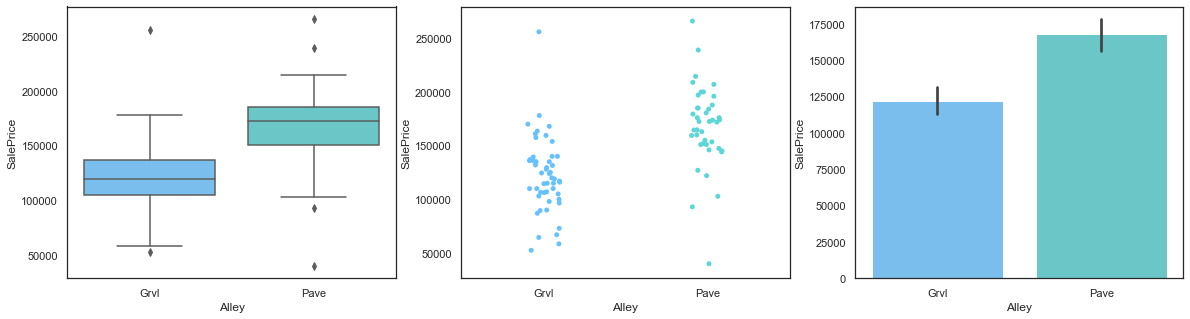

In [141]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Alley", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Alley", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Alley", y="SalePrice", data=train, palette = mycols);

Здесь мы видим довольно равномерное распределение между двумя классами по частоте, но гораздо более высокую среднюю SalePrice для переулков Paved, чем для переулков Gravel.
Таким образом, кажется, что это может быть хорошим предсказателем. Из этого я создам манекен.

In [142]:
all_data = pd.get_dummies(all_data, columns = ["Alley"], prefix="Alley")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0             3         3             1         3          Y   
1          0             3         3             4         3          Y   
2          0             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  FireplaceQu  ...  LandContour_Low  \
0      SBrkr              0          3            0  ...                0   
1      SBrkr              0          2            3  ...                0   
2      SBrkr              0          3            3  ...                0   

   LandContour_Lvl  LotConfig_Corner LotConfig_CulDSac LotConfig_FR  \
0                1                 0                 0            0   
1                1                 0                 0            1   
2                1                 0                 0            0   

   LotConfig_Inside  GentleSlope_Flag  Alley_Grvl Alley_None  Alley_Pave  
0                 1                 1           0          1           0  
1                 0                 1           0          1           0  
2                 1                 1           0          1           0  

[3 rows x 304 columns]

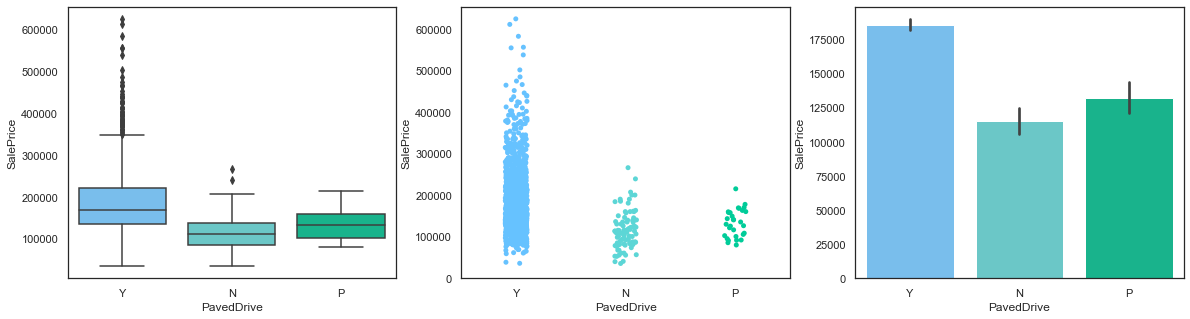

In [143]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="PavedDrive", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="PavedDrive", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="PavedDrive", y="SalePrice", data=train, palette = mycols);

Здесь мы видим самую высокую среднюю цену, востребованную у домов с мощеной подъездной дорогой, и большинство домов в этой области, похоже, имеют такую же цену.
Поскольку это категорическая особенность без порядка, я создам фиктивные переменные.

In [144]:
all_data = pd.get_dummies(all_data, columns = ["PavedDrive"], prefix="PavedDrive")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0             3         3             1         3          Y   
1          0             3         3             4         3          Y   
2          0             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  FireplaceQu  ...  LotConfig_CulDSac  \
0      SBrkr              0          3            0  ...                  0   
1      SBrkr              0          2            3  ...                  0   
2      SBrkr              0          3            3  ...                  0   

   LotConfig_FR  LotConfig_Inside GentleSlope_Flag Alley_Grvl  Alley_None  \
0             0                 1                1          0           1   
1             1                 0                1          0           1   
2             0                 1                1          0           1   

   Alley_Pave  PavedDrive_N PavedDrive_P  PavedDrive_Y  
0           0             0            0             1  
1           0             0            0             1  
2           0             0            0             1  

[3 rows x 306 columns]

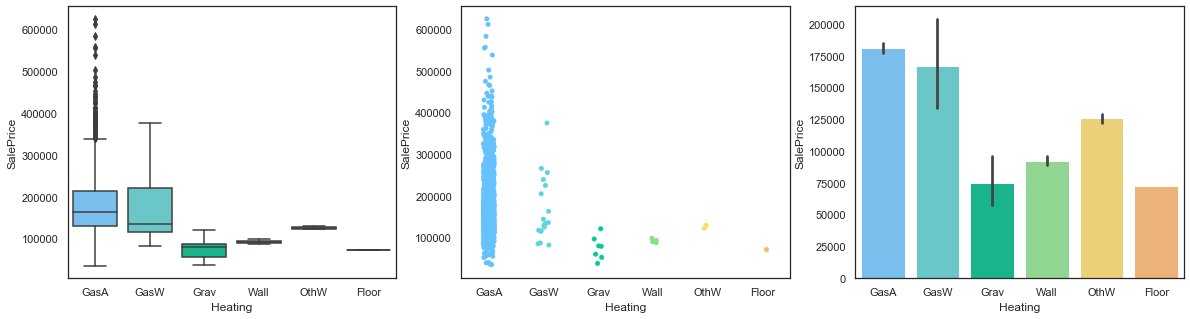

In [145]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Heating", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Heating", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Heating", y="SalePrice", data=train, palette = mycols);

Мы видим самую высокую частоту и самую высокую среднюю SalePrice от "GasA" и очень низкую частоту от всех других классов.
Поэтому я создам флаг, который будет указывать, присутствует ли "GasA" или нет.

In [146]:
all_data['GasA_Flag'] = all_data['Heating'].map({"GasA":1, "GasW":0, "Grav":0, "Wall":0, "OthW":0, "Floor":0})
all_data.drop('Heating', axis=1, inplace=True)
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0             3         3             1         3          Y   
1          0             3         3             4         3          Y   
2          0             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  FireplaceQu  ...  LotConfig_FR  \
0      SBrkr              0          3            0  ...             0   
1      SBrkr              0          2            3  ...             1   
2      SBrkr              0          3            3  ...             0   

   LotConfig_Inside  GentleSlope_Flag Alley_Grvl  Alley_None  Alley_Pave  \
0                 1                 1          0           1           0   
1                 0                 1          0           1           0   
2                 1                 1          0           1           0   

   PavedDrive_N PavedDrive_P  PavedDrive_Y  GasA_Flag  
0             0            0             1          1  
1             0            0             1          1  
2             0            0             1          1  

[3 rows x 306 columns]

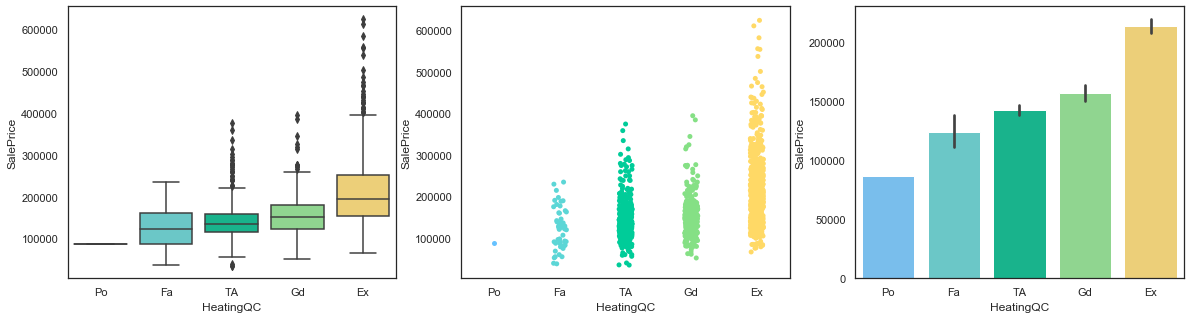

In [147]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="HeatingQC", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="HeatingQC", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="HeatingQC", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

Здесь мы видим положительную корреляцию с SalePrice по мере повышения качества отопления. С буквой "Ex" SalePrice - самая высокая средняя цена.
Мы также видим большое количество домов с таким качеством отопления, а это значит, что большинство домов имеют очень хорошее отопление!
Это категорическая особенность, но так как она показывает порядок, я заменю значения вручную цифрами.

In [148]:
all_data['HeatingQC'] = all_data['HeatingQC'].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['HeatingQC'].unique()

array([5, 4, 3, 2, 1], dtype=int64)

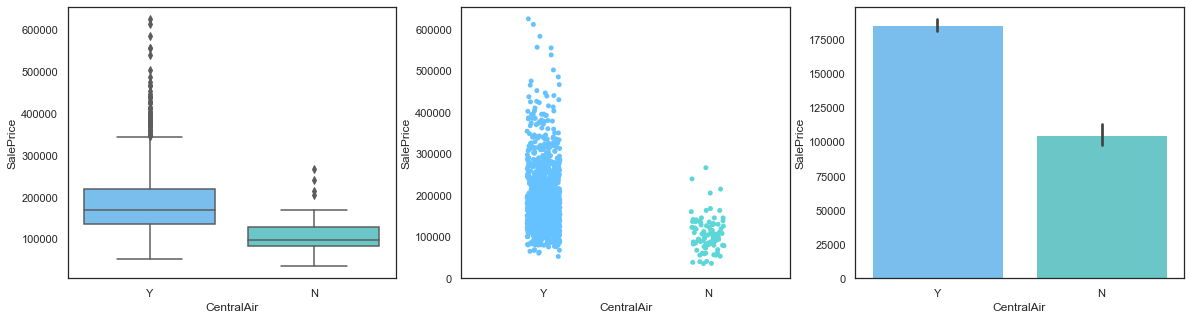

In [149]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="CentralAir", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="CentralAir", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="CentralAir", y="SalePrice", data=train, palette = mycols);

Мы видим, что дома с центральным кондиционированием воздуха могут требовать более высокую среднюю цену продажи, чем дома без него.
Для этой функции я просто заменю категории цифрами 0 и 1.

In [150]:
all_data['CentralAir'] = all_data['CentralAir'].map({"Y":1, "N":0})
all_data['CentralAir'].unique()

array([1, 0], dtype=int64)

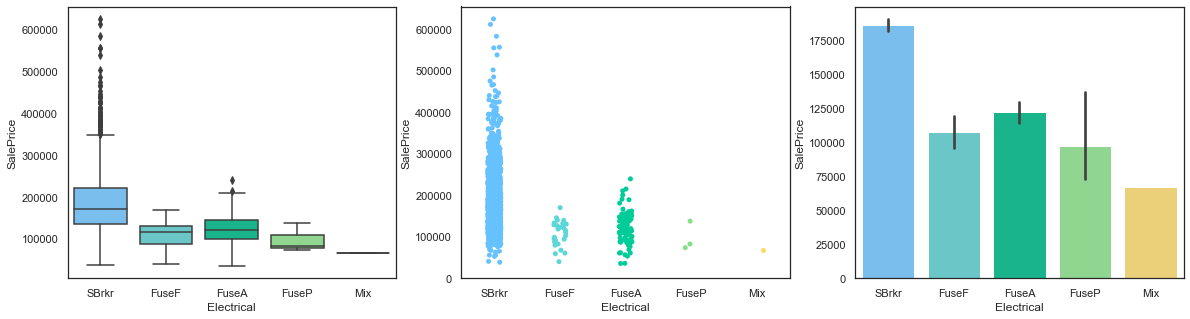

In [151]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Electrical", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Electrical", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Electrical", y="SalePrice", data=train, palette = mycols);

Мы видим самые высокие средние SalePrice поступающие из домов с "SBrkr" электрики, и это также самые частые электрические системы, установленные в домах из этой области. 
В частности, у нас есть 2 категории, которые имеют очень низкие частоты, "FuseP" и "Mix".
Я собираюсь объединить все классы, связанные с предохранителями, и класс "Mix", вероятно, будет удален во время уменьшения характеристик.

In [152]:
all_data['Electrical'] = all_data['Electrical'].map({"SBrkr":"SBrkr", "FuseF":"Fuse", "FuseA":"Fuse", "FuseP":"Fuse", "Mix":"Mix"})

all_data = pd.get_dummies(all_data, columns = ["Electrical"], prefix="Electrical")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces  ...  Alley_Grvl  \
0              0          3            0           0  ...           0   
1              0          2            3           1  ...           0   
2              0          3            3           1  ...           0   

   Alley_None  Alley_Pave  PavedDrive_N  PavedDrive_P  PavedDrive_Y GasA_Flag  \
0           1           0             0             0             1         1   
1           1           0             0             0             1         1   
2           1           0             0             0             1         1   

   Electrical_Fuse  Electrical_Mix  Electrical_SBrkr  
0                0               0                 1  
1                0               0                 1  
2                0               0                 1  

[3 rows x 308 columns]

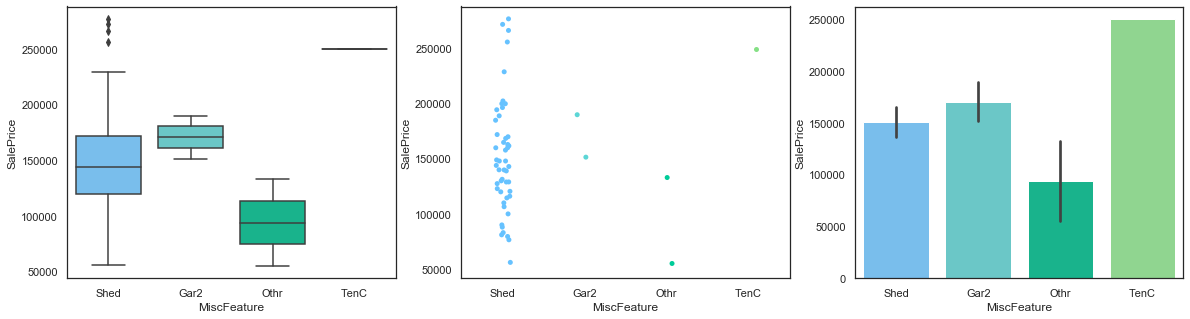

In [153]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MiscFeature", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="MiscFeature", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MiscFeature", y="SalePrice", data=train, palette = mycols);

Здесь мы видим, что только небольшое количество домов в этом районе с какими-либо ошибочными характеристиками. Следовательно, я не верю, что эта особенность вмещает много.
Поэтому я уберу эту функцию вместе с MiscVal.

In [154]:
columns=['MiscFeature', 'MiscVal']
all_data.drop(columns, axis=1, inplace=True)

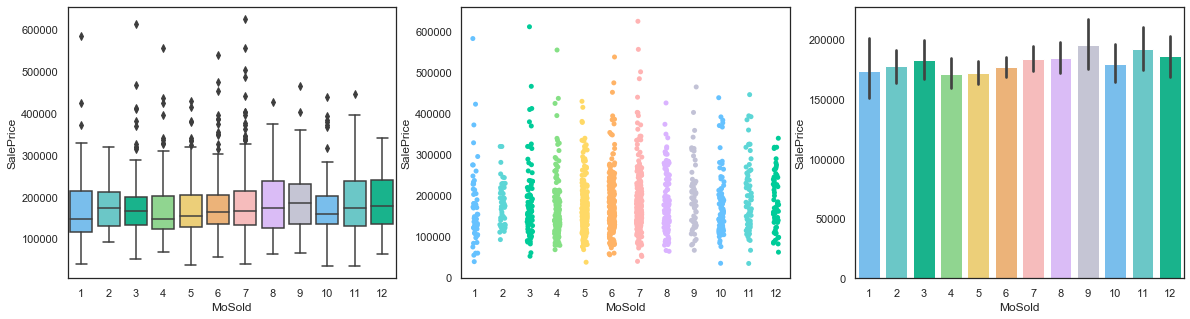

In [155]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MoSold", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="MoSold", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MoSold", y="SalePrice", data=train, palette = mycols);

Хотя эта функция является числовой, на самом деле она должна быть категорией. 
Мы видим, что не существует реального индикатора, как в случае с месяцами, когда последовательно продаются дома по более высокой цене, однако, похоже, что существует достаточно равномерное распределение значений между классами.
Из каждой категории я создам фиктивные переменные.

In [156]:
all_data = pd.get_dummies(all_data, columns = ["MoSold"], prefix="MoSold")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces  ...  MoSold_3  MoSold_4  \
0              0          3            0           0  ...         0         0   
1              0          2            3           1  ...         0         0   
2              0          3            3           1  ...         0         0   

   MoSold_5  MoSold_6  MoSold_7  MoSold_8  MoSold_9  MoSold_10  MoSold_11  \
0         0         0         0         0         0          0          0   
1         1         0         0         0         0          0          0   
2         0         0         0         0         1          0          0   

  MoSold_12  
0         0  
1         0  
2         0  

[3 rows x 317 columns]

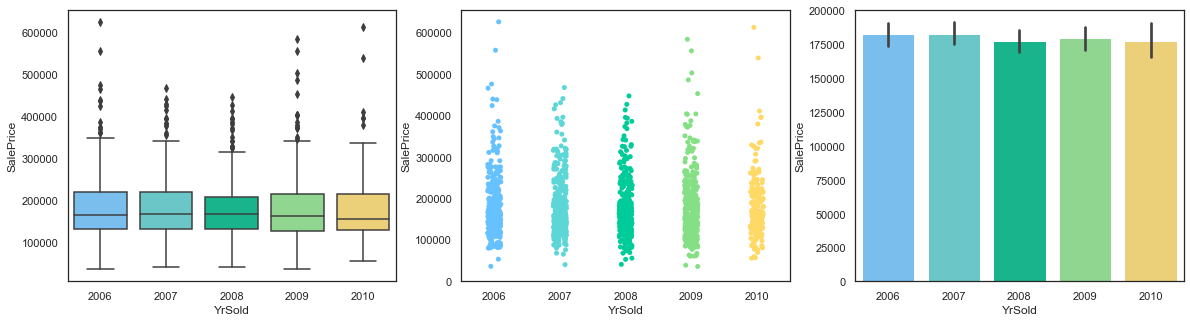

In [157]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="YrSold", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="YrSold", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="YrSold", y="SalePrice", data=train, palette = mycols);

Здесь мы видим только 5 лет, за которые были проданы дома в этом наборе данных.
Существует n равномерное распределение значений между каждым классом, и каждый год имеет очень похожий средний SalePrice.
Несмотря на то, что это числовой показатель, он должен быть категоричным. Поэтому я создам фиктивные переменные.

In [158]:
all_data = pd.get_dummies(all_data, columns = ["YrSold"], prefix="YrSold")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces  ...  MoSold_8  MoSold_9  \
0              0          3            0           0  ...         0         0   
1              0          2            3           1  ...         0         0   
2              0          3            3           1  ...         0         1   

   MoSold_10  MoSold_11  MoSold_12  YrSold_2006  YrSold_2007  YrSold_2008  \
0          0          0          0            0            0            1   
1          0          0          0            0            1            0   
2          0          0          0            0            0            1   

   YrSold_2009 YrSold_2010  
0            0           0  
1            0           0  
2            0           0  

[3 rows x 321 columns]

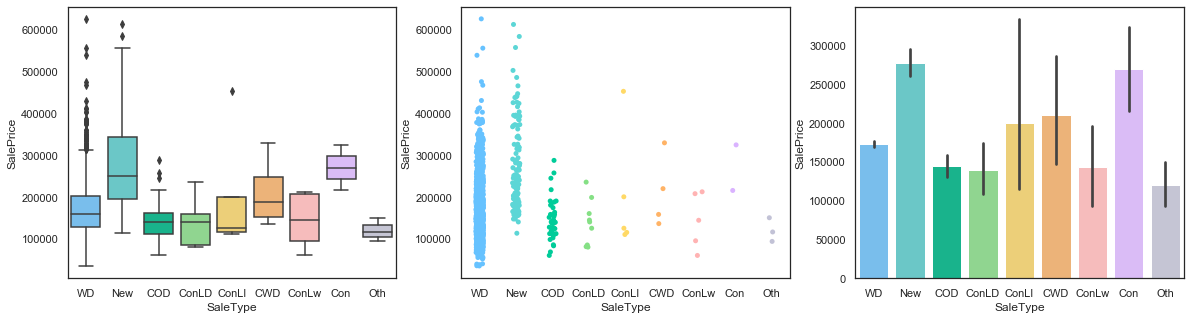

In [159]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="SaleType", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="SaleType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="SaleType", y="SalePrice", data=train, palette = mycols);

Большинство домов были проданы под категорией "WD", являясь обычной продажей, однако самая высокая SalePrice была видна из домов, которые были проданы как дома, которые были совершенно новые и только что проданы.
Для этой функции я объединил некоторые категории в группы, а затем создал фиктивные функции.

In [160]:
all_data['SaleType'] = all_data['SaleType'].map({"WD":"WD", "New":"New", "COD":"COD", "CWD":"CWD", "ConLD":"Oth", "ConLI":"Oth", 
                                                 "ConLw":"Oth", "Con":"Oth", "Oth":"Oth"})

all_data = pd.get_dummies(all_data, columns = ["SaleType"], prefix="SaleType")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces  ...  YrSold_2006  \
0              0          3            0           0  ...            0   
1              0          2            3           1  ...            0   
2              0          3            3           1  ...            0   

   YrSold_2007  YrSold_2008  YrSold_2009  YrSold_2010  SaleType_COD  \
0            0            1            0            0             0   
1            1            0            0            0             0   
2            0            1            0            0             0   

   SaleType_CWD  SaleType_New  SaleType_Oth SaleType_WD  
0             0             0             0           1  
1             0             0             0           1  
2             0             0             0           1  

[3 rows x 325 columns]

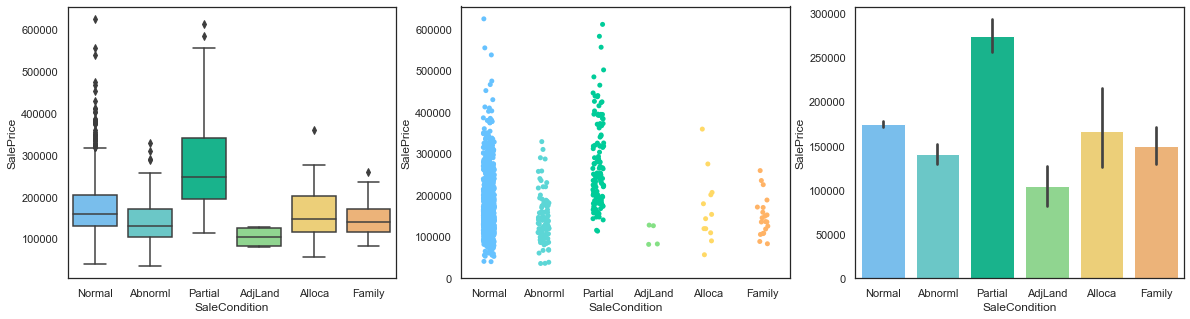

In [161]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="SaleCondition", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="SaleCondition", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="SaleCondition", y="SalePrice", data=train, palette = mycols);

Здесь мы видим, что самая большая средняя SalePrice связана с частичными продажами, а самая частая продажа, похоже, является нормальной.
Так как это категорическая особенность без заказа, я создам фиктивные функции.

In [162]:
all_data = pd.get_dummies(all_data, columns = ["SaleCondition"], prefix="SaleCondition")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces  ...  SaleType_CWD  \
0              0          3            0           0  ...             0   
1              0          2            3           1  ...             0   
2              0          3            3           1  ...             0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  

[3 rows x 330 columns]

In [163]:
print(all_data.shape)

(2915, 330)


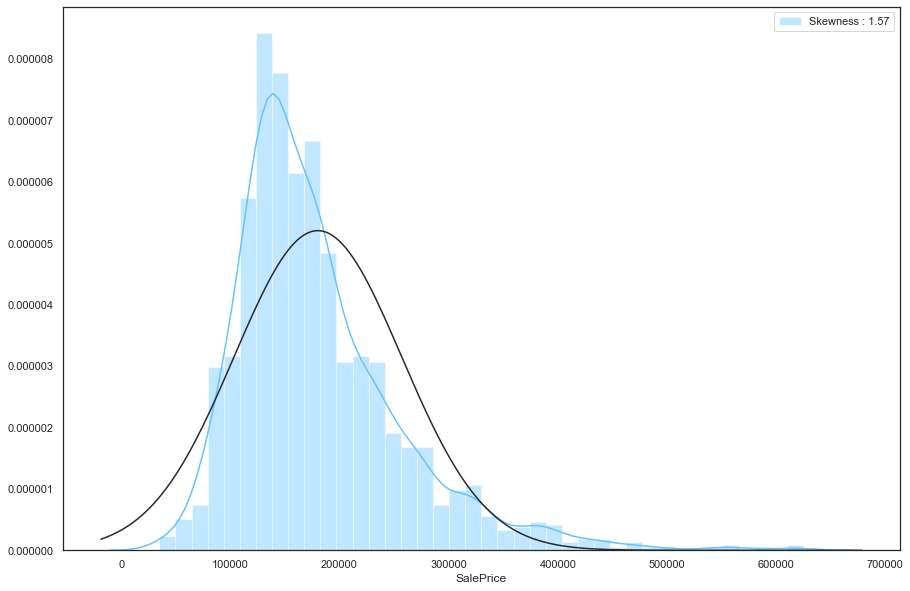

In [164]:
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

Приведем к нормальности:

In [165]:
train['SalePrice']=np.log(train['SalePrice'])

In [166]:
y_train = train["SalePrice"]

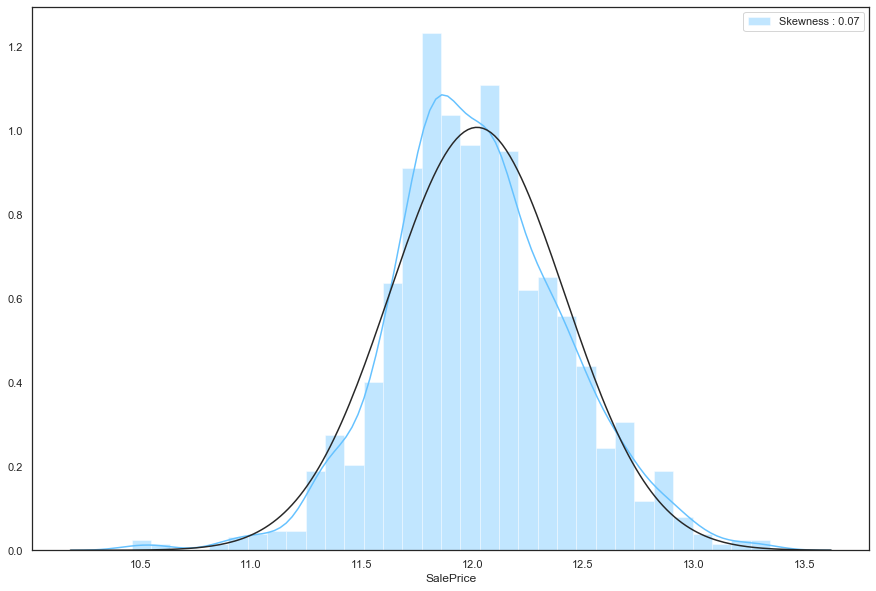

In [167]:
#Check the new distribution 
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

Моделирование

In [168]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [169]:
test.to_csv('hhouse3.csv')

In [170]:
sc=RobustScaler()
x=sc.fit_transform(train)
test=sc.transform(test)

In [171]:
model=Lasso(alpha =0.001, random_state=1)

In [172]:
model.fit(x,y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [173]:
pred=model.predict(test)
preds=np.exp(pred)

In [174]:
test2=pd.read_csv("test.csv")

In [175]:
output=pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})
output.to_csv('submit_mercedes_11_place.csv', index=False)

In [176]:
y_train.to_csv('hhouse.csv', index=False)

In [177]:
train.to_csv('hhouse2.csv')

In [178]:
from sklearn.linear_model import LinearRegression

In [179]:
LinReg = LinearRegression()

In [180]:
LinReg.fit(x,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [181]:
prediction = LinReg.predict(test)

In [182]:
preds=np.exp(prediction)

In [183]:
output=pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})
output.to_csv('submit_mercedes_12_place.csv', index=False)

In [184]:
len(x)

1456

In [185]:
len(y_train)

1456

In [186]:
X_train, X_val, y_train, y_val = train_test_split(x, y_train, test_size=0.2, shuffle=False)

In [187]:
print('Тренировочная выборка:', X_train.shape)
print('Валидационная выборка:', X_val.shape)

Тренировочная выборка: (1164, 330)
Валидационная выборка: (292, 330)


In [188]:
q = LinearRegression()
q.fit(X_train, y_train)

pred = q.predict(X_val)

In [189]:
from sklearn.metrics import mean_absolute_error

In [190]:
mean_absolute_error(pred, y_val)

0.08926975147252467

In [191]:
model.fit(X_train, y_train)

pred = model.predict(X_val)

In [192]:
mean_absolute_error(pred, y_val)

0.08123661203235376